# Exercise: Application of Machine Learning in Real Estate Price Prediction - Yarden Vardi & Ori Cohen

## Objective:
Understand and apply machine learning techniques to predict housing prices using the Kaggle dataset.

                                        


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.mixture import GaussianMixture 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pickle
import os
import warnings
from scipy.stats import norm
from scipy import stats

%matplotlib inline
%load_ext autoreload

In [2]:
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv')
df_test = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\test.csv')

df_orig = df.copy()
df_test_orig = df_test.copy()

### Functions and Classes Used:

In [5]:
scores = dict()

def divide_features(df):
    """A function to divide the data into numerical and categorical features.

    Args:
        df (DataFrame): The dataframe to divide into numerical and categorical features.

    Returns:
        numerical_features: All the numerical features in the dataframe.
        categorical_features: All the categorical features in the dataframe.
    """
    numerical_cols = df.select_dtypes(include=[np.number])
    categorical_cols = df.select_dtypes(include=[object])
    return numerical_cols.columns, categorical_cols.columns


def display_numerical_features(df, feature_names, target):
    """A function to display a subplots of the numerical features.

    Args:
        df (DataFrame): The dataframe to display the subplots of the numerical features.
        feature_names (list | index): The list of numerical features to display.
        target (Series): The target variable.
    """
    for feature in feature_names:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
        sns.distplot(df[feature], fit=norm, ax=axs[0], bins=100)
        sns.scatterplot(x=feature, y=target, data=df, ax=axs[1])
        plt.show()


def display_categorical_features(df, features_names, target):
    """A function to display a subplots of the categorical features. 
    The first subplot is a count plot of the feature and the second subplot is a box plot of the feature vs the target variable.

    Args:
        df (DataFrame): The dataframe to display the subplots of the categorical features.
        features (list | index): The list of categorical features to display.
        target (Series): The target variable.
    """
    for feature in features_names:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
        sns.countplot(x=feature, data=df, ax=axs[0])
        sns.boxplot(x=feature, y=target, data=df, ax=axs[1])
        plt.show()


def display_missing_values(df):
    """A function to find the missing values for each feature 
    and display them in a dataframe along with the percentage of missing values for each feature.

    Args:
        df (DataFrame): The dataframe to display the missing values.

    Returns:
        DataFrame: A dataframe containing the missing values and the percentage of missing values for each feature.
    """
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_values = missing_values[missing_values > 0]
    missing_values = pd.DataFrame(missing_values, columns=['Missing Values'])
    missing_values['Percentage'] = missing_values['Missing Values'] / df.shape[0]
    return missing_values


class DuplicateFeatureRemover(BaseEstimator, TransformerMixin):
    """A transformer to remove duplicate features from the output of the one hot encoder. 
    The transformer is used in the pipeline to remove duplicate features from the output of the one hot encoder.
    """
    
    def __init__(self, categorical_features):
        """Initialize the transformer with the list of categorical features."""
        self.categorical_features = categorical_features
        
    def fit(self, X, y=None):
        """Fit the transformer."""
        return self
        
    def transform(self, X):
        """Transform the dataframe by removing the duplicate features from the output of the one hot encoder."""
        # Get the names of the input features from the one hot encoder
        input_features = X.columns

        # Get all the suffixes in the output features 
        # by removing the feature names in the categorical features from the feature names in the input features
        suffixes = input_features.difference(self.categorical_features)

        # Delete repeated suffixes
        suffixes = suffixes.drop_duplicates()

        # for each suffix, check if there are more than one feature with the same suffix.
        # Make sure that the suffix is not in the list of categorical features.
        # if there are more than one feature with the same suffix, delete all the features with the first occurrence of the suffix 
        # except the first feature
        for suffix in suffixes:
            if len(input_features[input_features.str.endswith(suffix)]) > 1 and suffix not in self.categorical_features:
                X = X.drop(input_features[input_features.str.endswith(suffix)][1:], axis=1)
        
        # Convert the output back to an output that can be used by the  column transformer
        return X


def build_pipeline(numerical_columns, categorical_columns):
    """A function to build a pipeline that contains a preprocessor to impute missing values for numerical features with the median value of each feature,
    impute missing values for categorical features with most frequent values, and one hot encode categorical features, and a RandomForestRegressor model.

    Args:
        numerical_columns (_type_): _description_
        categorical_columns (_type_): _description_

    Returns:
        Pipeline: A pipeline that contains a preprocessor, and a RandomForestRegressor model.
    """
    
    # Preprocessor for numerical data
    numerical_transformer = SimpleImputer(strategy='median')
    
    # OneHotEncoder
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Preprocessor for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', one_hot_encoder)
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ])

    # Define model
    model = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Bundle preprocessing and modeling code in a pipeline
    pipeline = Pipeline(
        steps=[
        ('preprocessor', preprocessor),
        ('model', model)
        ]
                        )
    return pipeline


# Impute missing values of categorical features based on the markdown above
def impute_no_feature(df, feature_list):
    """A function to impute missing values of categorical features whose missing values represent a lack of the feature.

    Args:
        df (DataFrame): The dataframe to impute the missing values of categorical features.
        feature_list (list): The list of categorical features to impute their missing values.
    """
    for feature in feature_list:
        df[feature] = df[feature].fillna(f'No {feature}')

def log_rmse(y_true, y_pred):
    """Calculate the RMSE with logarithmic transformation."""
    return np.sqrt(mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1)))

def cross_validate_estimator(estimator, X, y, cv):
    """Cross-validate an estimator with custom, negative mean squared error, and custom RMSE scoring.

    Args:
        estimator (model): The estimator to use for cross-validation.
        X (DataFrame): Features for cross-validation.
        y (Series): Target variable for cross-validation.
        cv (int): Number of folds for cross-validation.

    Returns:
        dict: Dictionary with average and std of cross-validation score for each score type.
    """
    # Default cross-validation
    cv_scores = cross_val_score(estimator, X, y, cv=cv, n_jobs=-1)
    print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean()}, std: {cv_scores.std()}\n")
    
    # Negative mean squared error cross-validation
    cv_scores_neg_mse = -cross_val_score(estimator, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    print(f"MSE Cross-validation scores: {cv_scores_neg_mse}, scores average: {cv_scores_neg_mse.mean()}, std: {cv_scores_neg_mse.std()}\n")    

    # Custom RMSE cross-validation
    log_rmse_scorer = make_scorer(log_rmse, greater_is_better=False)
    cv_scores_log_rmse = -cross_val_score(estimator, X, y, cv=cv, scoring=log_rmse_scorer, n_jobs=-1)
    print(f"Log RMSE Cross-validation scores: {cv_scores_log_rmse}, scores average: {cv_scores_log_rmse.mean()}, std: {cv_scores_log_rmse.std()}")

    return {
        'average_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'average_cv_score_neg_mse': cv_scores_neg_mse.mean(),
        'std_cs_score_neg_mse': cv_scores_neg_mse.std(),
        'average_cv_score_log_rmse': cv_scores_log_rmse.mean(),
        'std_cv_score_log_rmse': cv_scores_log_rmse.std()
    }


def convert_to_categorical(df, columns, num_features, cat_features):
    """A function to convert numerical features to categorical features.

    Args:
        df (DataFrame): The dataframe to convert the numerical features to categorical features.
        columns (list): The list of numerical features to convert to categorical features.
        num_features (Index): The list of numerical features.
        cat_features (Index): The list of categorical features.

    Returns:
        num_features (Index): The updated list of numerical features.
        cat_features (Index): The updated list of categorical features.
    """
    # Convert Index objects to lists for modification
    num_features_list = num_features.tolist()
    cat_features_list = cat_features.tolist()

    for col in columns:
        if col in num_features_list:
            # Convert the column to categorical in the DataFrame
            df[col] = df[col].astype('object')

            # Update lists
            num_features_list.remove(col)
            cat_features_list.append(col)

    # Convert lists back to Index objects
    return pd.Index(num_features_list), pd.Index(cat_features_list)


def convert_to_numerical(df, columns, num_features, cat_features):
    """A function to convert categorical features to numerical features.

    Args:
        df (DataFrame): The dataframe to convert categorical features to numerical features.
        columns (list): The list of categorical features to convert to numerical features.
        num_features (Index): The list of numerical features.
        cat_features (Index): The list of categorical features.

    Returns:
        num_features (Index): The updated list of numerical features.
        cat_features (Index): The updated list of categorical features.
    """
    # Convert Index objects to lists for modification
    num_features_list = num_features.tolist()
    cat_features_list = cat_features.tolist()

    for col in columns:
        if col in cat_features_list:
            # Convert the column to numerical in the DataFrame (assuming it can be converted directly)
            df[col] = pd.to_numeric(df[col], errors='coerce')

            # Update lists
            cat_features_list.remove(col)
            num_features_list.append(col)

    # Convert lists back to Index objects
    return pd.Index(num_features_list), pd.Index(cat_features_list)


def pickle_object(var):
    """A function to pickle an object. You must specify the directory path and the file name.

    Args:
        var (some variable): The variable to pickle.
    """
    # Specify the directory path
    directory = input("Path to directory: ")  # Replace with your desired path
    file_name = input("File name: ")  # Replace with your desired file name

    # Ensure the directory exists, create if it doesn't
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Specify the file path
    file_path = os.path.join(directory, file_name)

    # Save the object to the specified directory
    with open(file_path, 'wb') as file:
        pickle.dump(var, file)


def outlier_removal(data, column):
    """A function to remove outliers from a specified column in a dataframe.

    Args:
        data (DataFrame): The dataframe to remove outliers from.
        column (Series): The column to remove outliers from.
    """
    # Calculate Q1, Q3, and IQR for the specified column
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Adjust outliers
    data.loc[data[column] < lower_bound, column] = lower_bound
    data.loc[data[column] > upper_bound, column] = upper_bound


def model_prediction(pipeline, model, X_test, original_data, numerical_features, categorical_features):
    """A function to make predictions using a model and save the predictions to a csv file along with the Id column.

    Args:
        model (estimator): The model to make predictions with.
        X_test (DataFrame): The test data to make predictions on.
        original_data (DataFrame): The original data to get the Id column from.
    """
    # Access the preprocessor from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']
    
    # Transform the test data
    X_test_processed = preprocessor.transform(X_test)
    
    # Get the feature names from ColumnTransformer
    column_transformer = preprocessor.named_transformers_['cat']
    
    # Access the one hot encoder
    one_hot_encoder = column_transformer.named_steps['onehot']
    
    # Get the feature names from the one hot encoder
    cat_one_hot_features = one_hot_encoder.get_feature_names_out(categorical_features)
    
    # Create a DataFrame of the transformed test data
    X_test_processed = pd.DataFrame(
        data=X_test_processed,
        columns=(list(numerical_features) + list(cat_one_hot_features))
    )   
    
    # Remove duplicate features from the transformed test data
    duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features)
    X_test_transformed = duplicate_feature_remover.transform(X_test_processed)    
        
    # PModel predictions
    predictions = model.predict(X_test_transformed)

    # Prepare submission file
    submission = pd.DataFrame({
        'Id': original_data['Id'],
        'SalePrice': predictions
    })

    # Get file name from user
    file_name = input('File Name: ')

    # Save submission file as csv
    submission.to_csv(f'{file_name}.csv', index=False)


def display_feature_importance(model, feature_names, n=None):
    """
    A function to display the feature importance of the top n features.

    Args:
        model (estimator): The model to display the feature importance from.
        categorical_features (list): List of categorical feature names.
        numerical_features (list): List of numerical feature names.
        n (int, optional): The number of features to display. Defaults to the total number of features.
    """

    # Get feature importances
    importances = model.feature_importances_

    # Calculate total features if n is not specified
    if n is None:
        n = len(feature_names)

    # Create a DataFrame of feature importances
    feature_importances = pd.DataFrame(importances, index=feature_names, columns=['importance'])

    # Sort the DataFrame in descending order of feature importance
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)

    # Plot the feature importances of n most important features in horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.title(f'Top {n} most important features')
    sns.barplot(x=feature_importances['importance'][:n], y=feature_importances.index[:n])
    plt.show()


def remove_feature(train_data, test_data, feature, feature_index):
    """A function to remove a feature from the training and test data.

    Args:
        train_data (DataFrame): The training data to remove the feature from.
        test_data (DataFrame): The test data to remove the feature from.
        feature (str): The name of the feature to remove.
        feature_index (index): The index of the feature to remove.
    """
    features_list = feature_index.tolist()
    features_list.remove(feature)
    feature_index = pd.Index(features_list)
    train_data = train_data.drop(feature, axis=1)
    test_data = test_data.drop(feature, axis=1)
    
    return train_data, test_data, feature_index


def extract_processed_df(pipeline, df, numerical_features, categorical_features):
    """A function to extract the processed dataframe from the pipeline.

    Args:
        pipeline (Pipeline): The pipeline to extract the processed dataframe from.
        X (DataFrame): The features to use for cross-validation.

    Returns:
        DataFrame: The processed dataframe.
    """
    # Access the preprocessor
    preprocessor = pipeline.named_steps['preprocessor']

    # Access the column transformer
    column_transformer = preprocessor.named_transformers_['cat']

    # Access the one hot encoder
    one_hot = column_transformer.named_steps['onehot']

    # Get the feature names from the one hot encoder
    cat_one_hot_features = one_hot.get_feature_names_out(categorical_features)
    
    # reform the dataframe
    processed_df = pd.DataFrame(
        data=preprocessor.transform(df),
        columns=(list(numerical_features) + list(cat_one_hot_features))
    )
    
    return processed_df  


def model_rebuilder(X, y, numerical_features, categorical_features, n_features, title):
    """A function to rebuild the pipeline after removing or changing features.

    Args:
        X (DataFrame): The features to use for cross-validation.
        y (Series): The target variable to use for cross-validation.
        numerical_features (Index): The list of numerical features.
        categorical_features (Index): The list of categorical features.

    Returns:
        Pipeline: A pipeline that contains a preprocessor, and a RandomForestRegressor model.
    """
    # Build the data pipeline
    rf_pipeline = build_pipeline(numerical_columns=numerical_features, categorical_columns=categorical_features)

    # Fit the pipeline
    rf_pipeline.fit(X, y)
    
    # Extract the processed dataframe from the pipeline
    processed_X = extract_processed_df(
        pipeline=rf_pipeline, 
        df=X, 
        numerical_features=numerical_features, 
        categorical_features=categorical_features
        )
    
    # Remove duplicate features from the transformed dataframe
    duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features)

    transformed_X = duplicate_feature_remover.transform(processed_X)

    # Refit the model from the pipeline on the transformed dataframe
    rf_model = rf_pipeline.named_steps['model']
    rf_model.fit(transformed_X, y)
    
    # Print title
    print(title)
    
    # Cross validation
    current_scores = cross_validate_estimator(estimator=rf_model, X=transformed_X, y=y, cv=5)

    display_feature_importance(
        model=rf_model,
        feature_names=transformed_X.columns,
        n=n_features
    )
        
    # Save the cross validation scores to the scores dictionary
    scores[title] = current_scores

    return rf_model, rf_pipeline


def convert_quality_features(df, feature_list, categorical_features):
    """Convert quality features to numerical features by mapping categorical values to numerical values.
    
    Args:
        df (DataFrame): The dataframe to convert the quality features.
        feature_list (list): The list of quality features to convert.
        categorical_features (Index): The list of categorical features.
    
    Returns:
        df (DataFrame): The dataframe with the converted quality features.
        categorical_features (Index): The updated list of categorical features.    
    """
    # Convert Index to list for manipulation
    categorical_features = list(categorical_features)
    
    # Create a list to store the new feature names
    new_feature_list = []

    for feature in feature_list:
        # Map categorical values to numerical values
        df[f'{feature}_binned'] = df[feature].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

        # Remove outliers from the converted quality features
        outlier_removal(data=df, column=f'{feature}_binned')

        # Check the number of unique values in each quality feature
        unique_vals = df[f'{feature}_binned'].nunique()
        print(f'{feature}_binned: {unique_vals}')

        if unique_vals > 1:
            num_bins = min(6, unique_vals)
            bin_labels = [str(i) for i in range(1, num_bins)]

            try:
                df[f'{feature}_binned'] = pd.qcut(
                    df[f'{feature}_binned'], q=num_bins, labels=bin_labels, duplicates='drop'
                )
                print(f'{feature} binned successfully')
                
                # Remove the original feature from the dataframe
                df = df.drop(feature, axis=1)

                # Update categorical features list
                if feature in categorical_features:
                    categorical_features.remove(feature)
                categorical_features.append(f'{feature}_binned')
                
                # Add the new feature name to the new feature list
                new_feature_list.append(f'{feature}_binned')
                
                # Convert the new feature to quality labels 'poor', 'fair', 'average', 'good', 'excellent' according to the number of bins
                if num_bins == 2:
                    df[f'{feature}_binned'] = df[f'{feature}_binned'].map({'1': 'poor', '2': 'good'})
                elif num_bins == 3:
                    df[f'{feature}_binned'] = df[f'{feature}_binned'].map({'1': 'poor', '2': 'average', '3': 'good'})
                elif num_bins == 4:
                    df[f'{feature}_binned'] = df[f'{feature}_binned'].map({'1': 'poor', '2': 'fair', '3': 'good', '4': 'excellent'})
                elif num_bins == 5:
                    df[f'{feature}_binned'] = df[f'{feature}_binned'].map({'1': 'poor', '2': 'fair', '3': 'average', '4': 'good', '5': 'excellent'})

            except ValueError as e:
                print(f"Error in binning {feature}: {e}")
                df = df.drop(f'{feature}_binned', axis=1)
                
        else:
            print(f'Not enough unique values in {feature} to bin')
            df = df.drop(f'{feature}_binned', axis=1)
            
            # Map the numerical values back to categorical values
            df[feature] = df[feature].map({1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'})

    # Convert list back to Index if required
    categorical_features = pd.Index(categorical_features)
    return df, categorical_features, new_feature_list


def build_XGB_pipeline(
    numerical_columns, 
    categorical_columns, 
    enable_categorical=True, 
    tree_method='gpu_hist', 
    n_estimators=1000, 
    learning_rate=0.05, 
    n_jobs=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    min_child_weight=1,
    reg_alpha=0.005,
    reg_lambda=0.01,
    gamma=0.0
    ):
    """A function to build a pipeline that contains a preprocessor to impute missing values for numerical features with the median value of each feature,
    impute missing values for categorical features with most frequent values, and one hot encode categorical features, and a RandomForestRegressor model.

    Args:
        numerical_columns (_type_): _description_
        categorical_columns (_type_): _description_

    Returns:
        Pipeline: A pipeline that contains a preprocessor, and a RandomForestRegressor model.
    """
    
    # Preprocessor for numerical data
    numerical_transformer = SimpleImputer(strategy='median')
    
    # OneHotEncoder
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Preprocessor for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', one_hot_encoder)
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ])

    # Define model
    model = XGBRegressor(
        random_state=42, 
        n_jobs=n_jobs, 
        tree_method=tree_method, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        enable_categorical=enable_categorical
        )

    # Bundle preprocessing and modeling code in a pipeline
    pipeline = Pipeline(
        steps=[
        ('preprocessor', preprocessor),
        ('model', model)
        ]
                        )
    return pipeline

#Validation function
n_folds = 5

def rmsle_cv(model, train, y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-1 * cross_val_score(estimator=model, X=train.values, y=y_train, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    """A class to stack multiple models and average their predictions.
    """
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        """Fit the data on clones of the original models.

        Args:
            X (DataFrame): The features to use for cross-validation.
            y (Series): The target variable to use for cross-validation.
        """
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        # Create empty arrays to store predictions
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kf.split(X, y):
                # Clone the model
                instance = clone(model)
                # Fit the model
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                # Predict the holdout set
                y_pred = instance.predict(X.iloc[holdout_index])
                # Store the predictions
                out_of_fold_predictions[holdout_index, i] = y_pred
                # Store the model
                self.base_models_[i].append(instance)

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)

        return self
    
    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        """Do the predictions of all base models on the test data and use the averaged predictions as
        meta-features for the final prediction which is done by the meta-model.

        Args:
            X (DataFrame): The test data to make predictions on.

        Returns:
            Series: The predictions of the meta-model.
        """
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)
    

def remove_outliers_zscore(df, column):
    mean = np.mean(df[column])
    std = np.std(df[column])
    threshold = 3
    df = df[np.abs(df[column] - mean) <= threshold * std]
    return df

## Preparation

### Short EDAs

In [6]:
# create a target variable
y = df['SalePrice']

# Get the numerical and categorical features without the target variable and Id
numerical_features, categorical_features = divide_features(df.drop(['SalePrice', 'Id'], axis=1))

# Create a list of all features
all_features = list(numerical_features) + list(categorical_features)

Skewness: 1.882876
Kurtosis: 6.536282


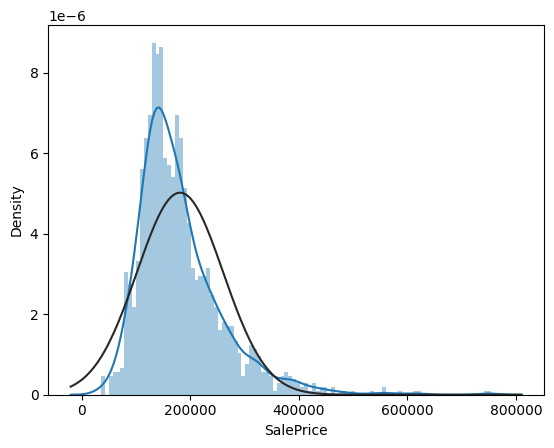

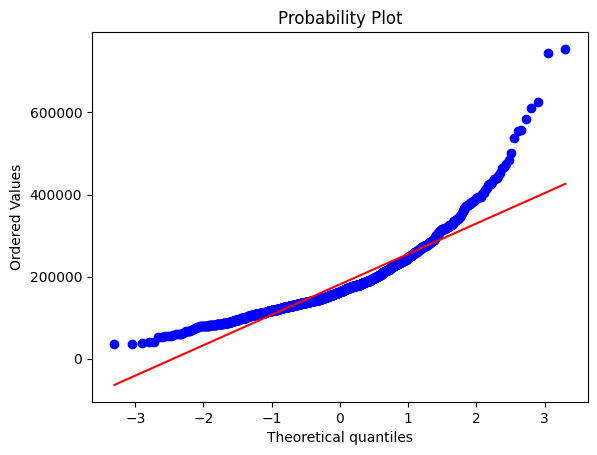

In [7]:
# Describe the target variable
y.describe()

# Plot the distribution of the target variable and show the skewness and kurtosis as well as compare it to a normal distribution
sns.distplot(y, fit=norm, bins=100, kde=True);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

# Skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

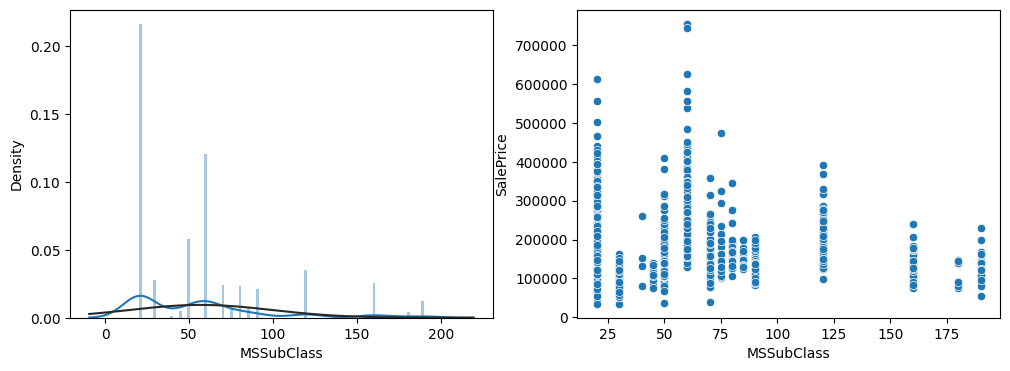

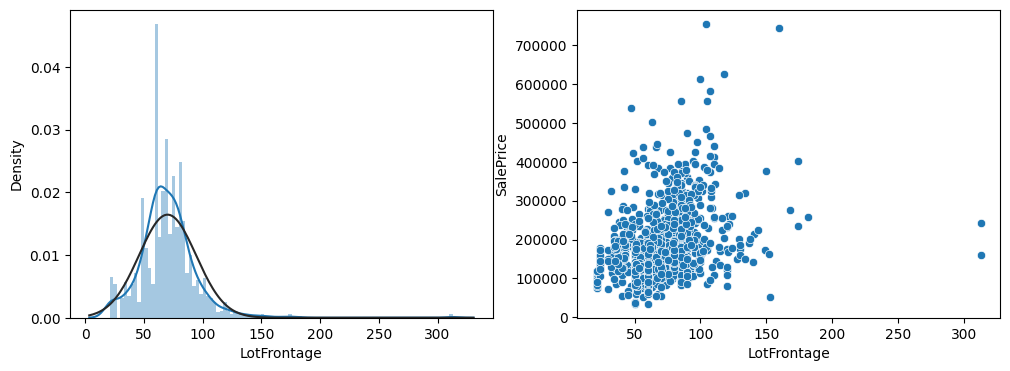

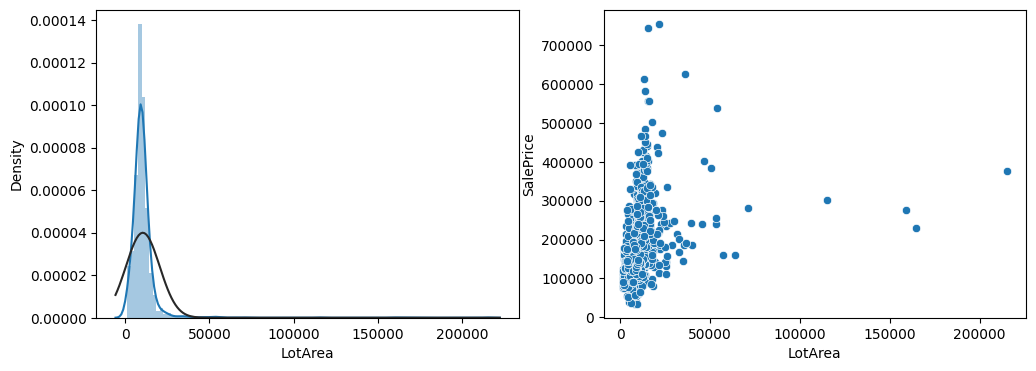

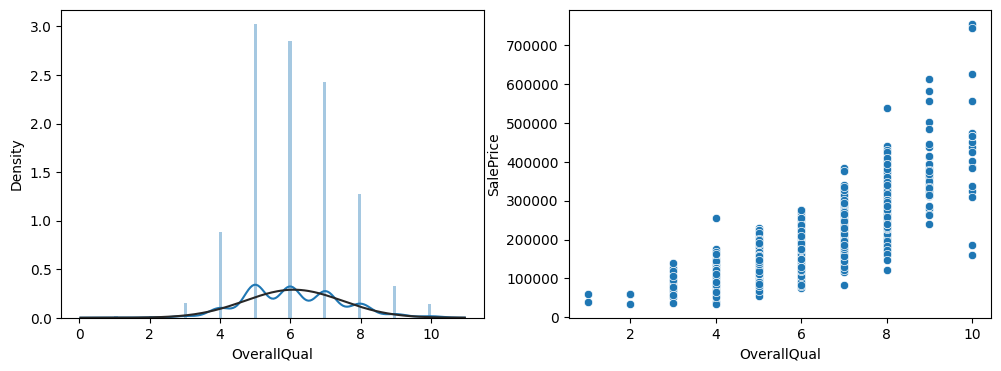

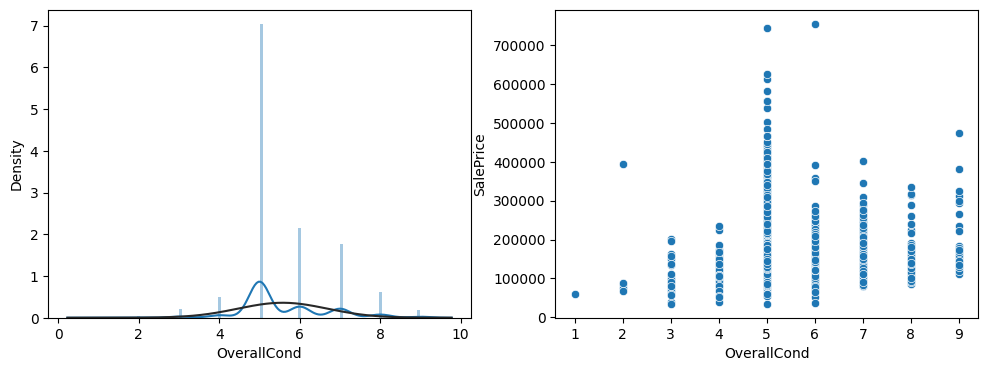

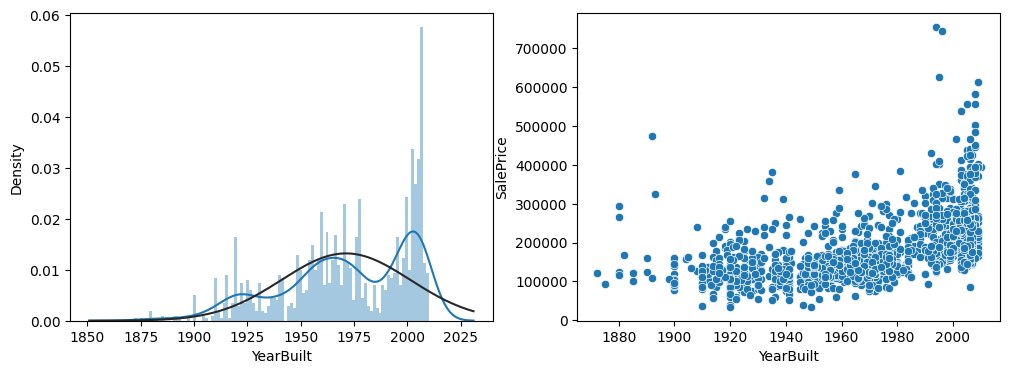

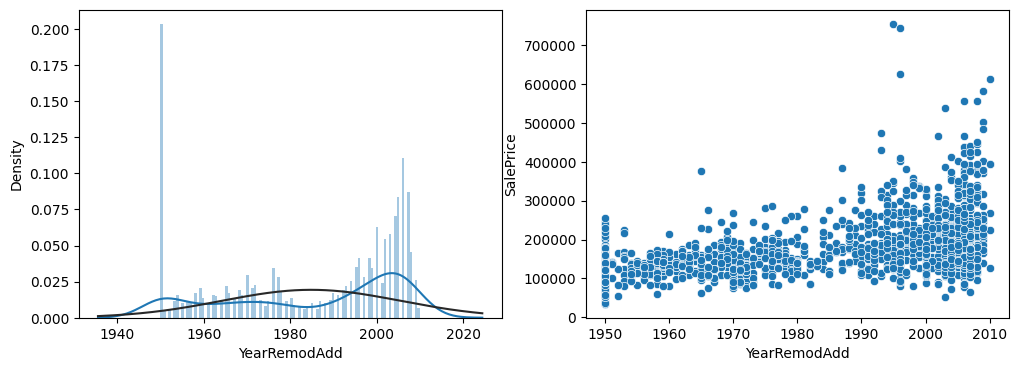

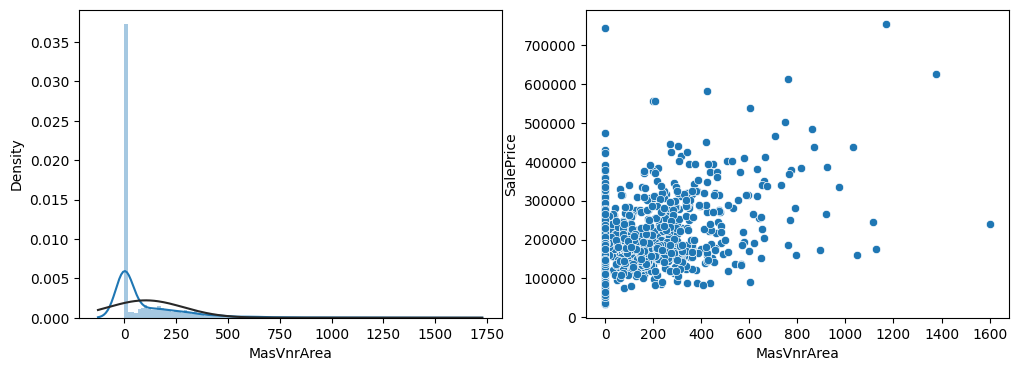

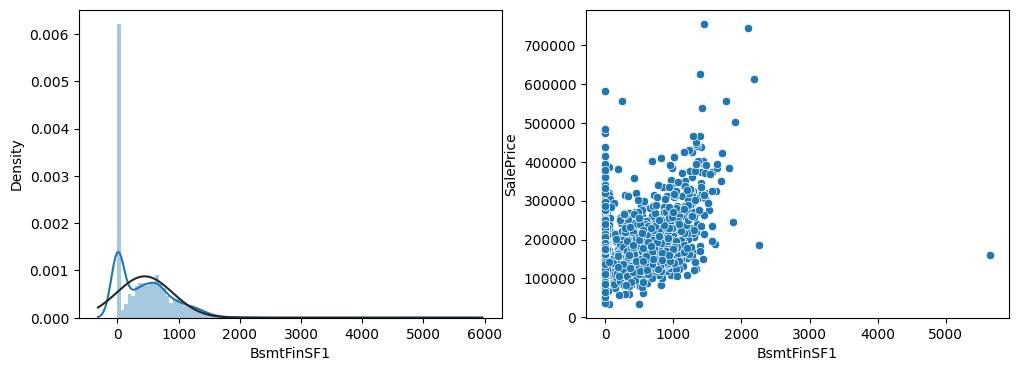

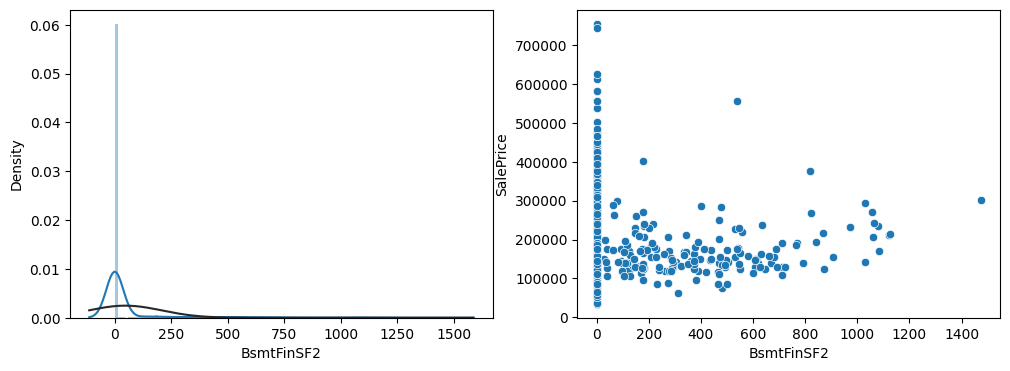

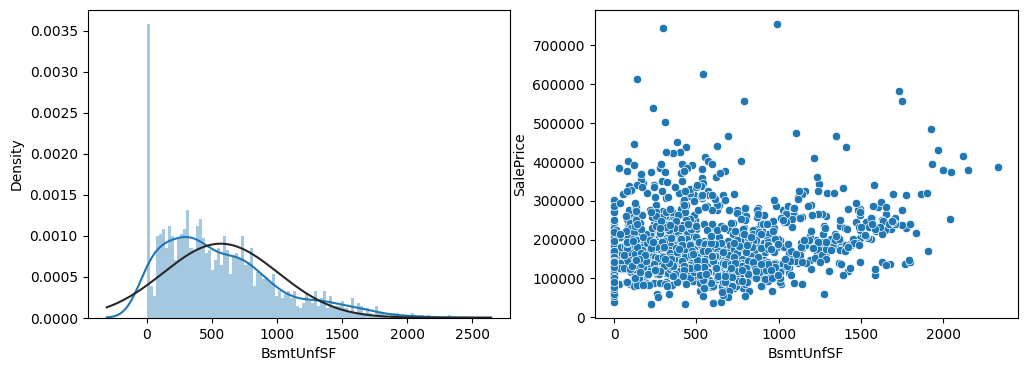

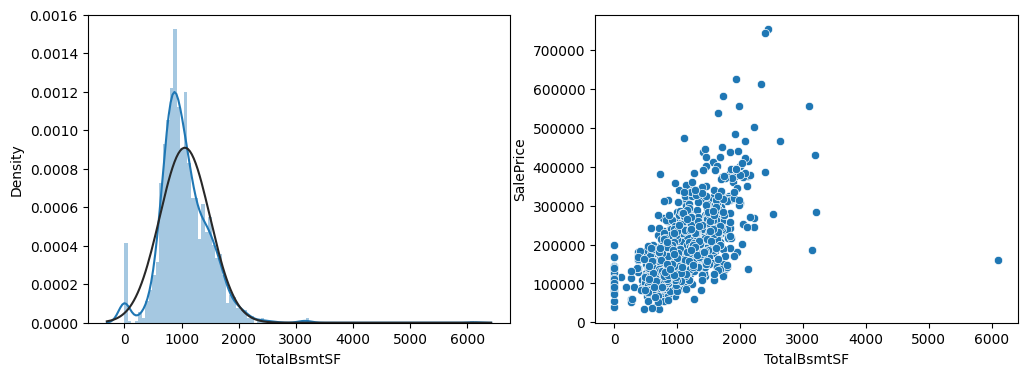

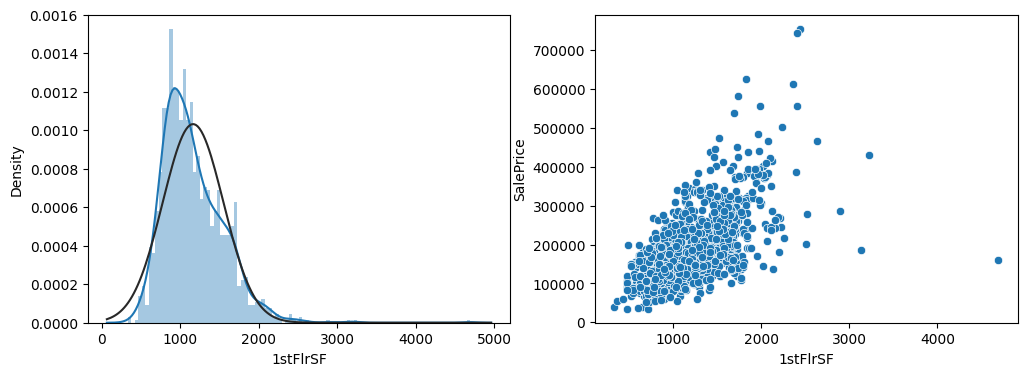

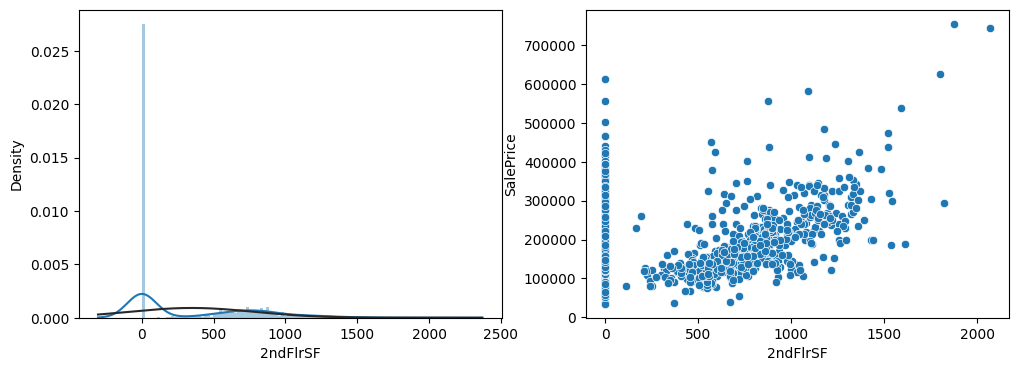

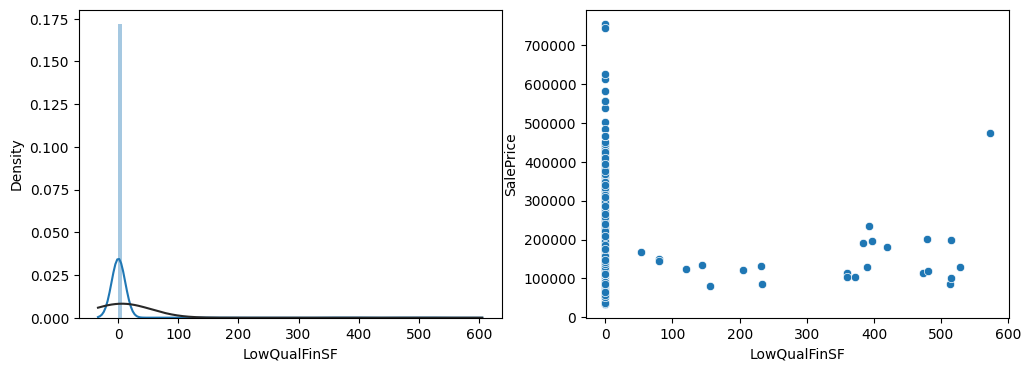

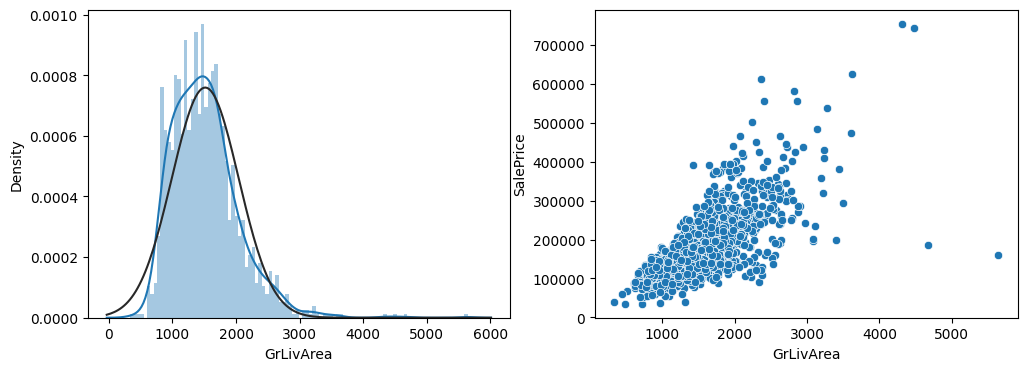

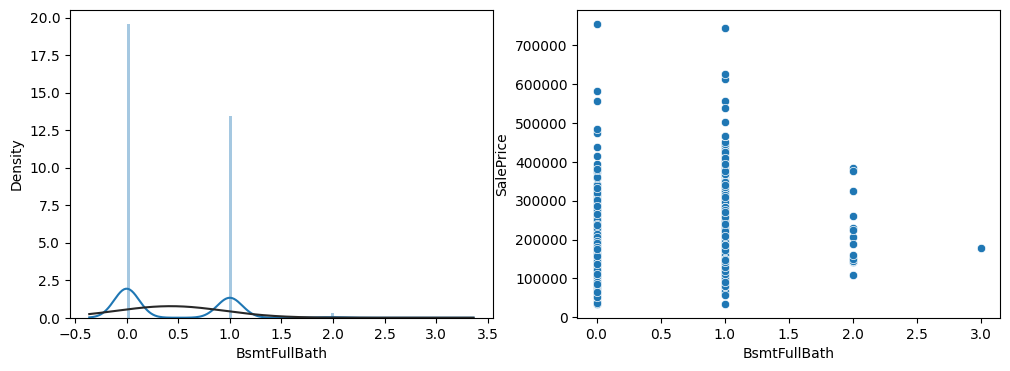

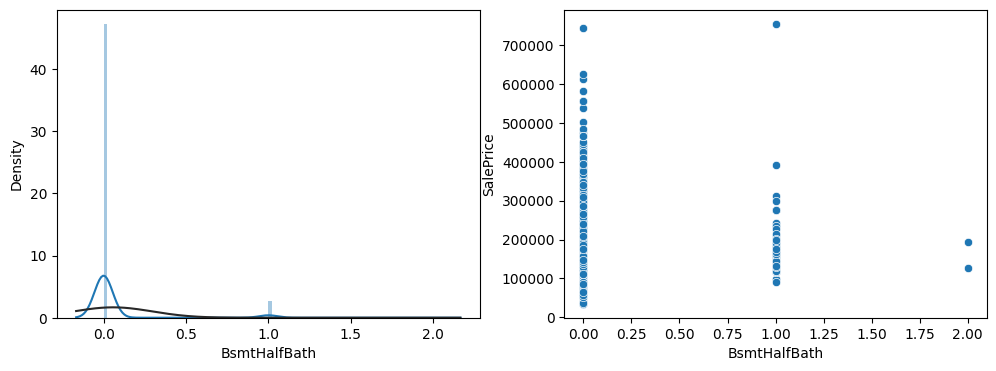

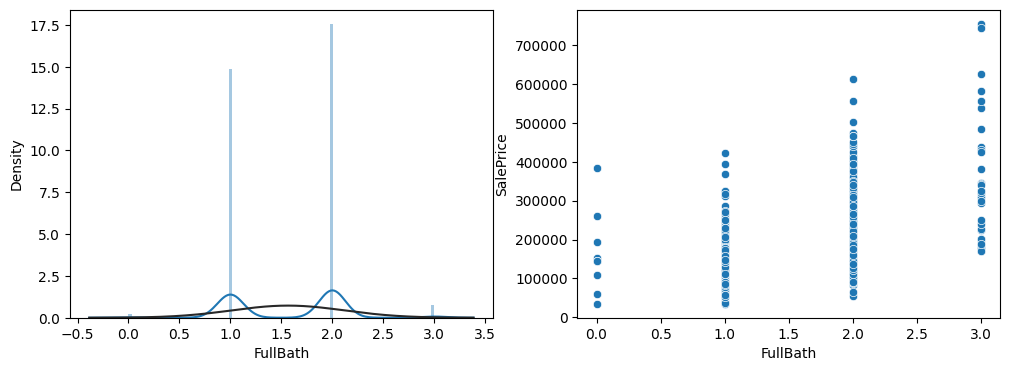

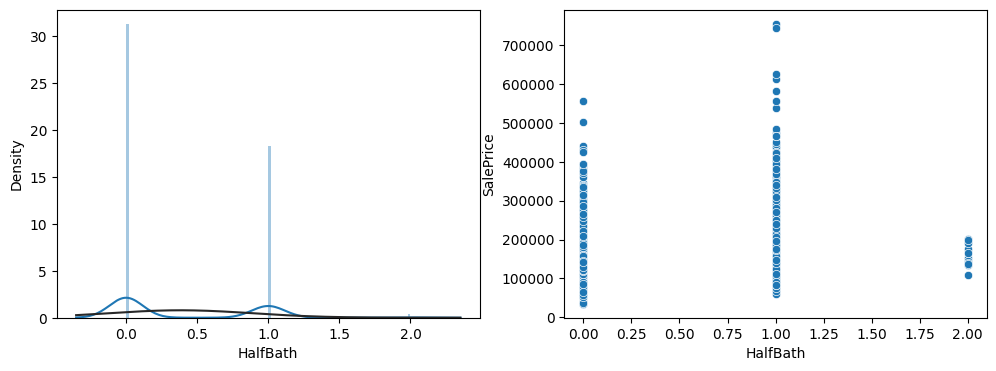

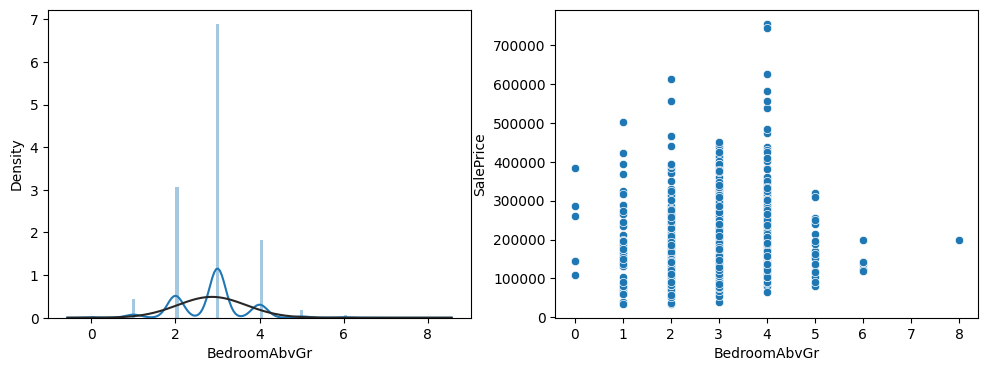

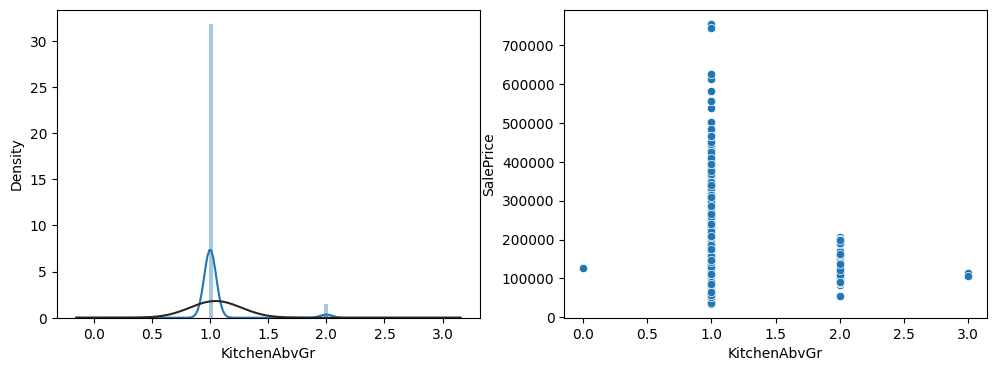

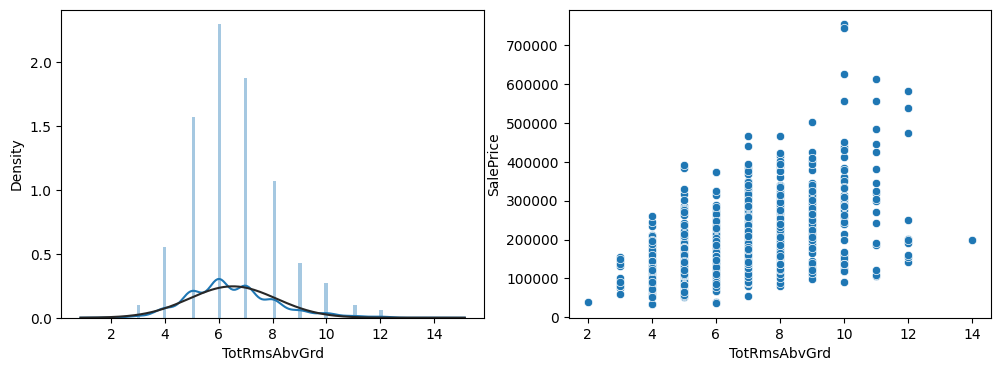

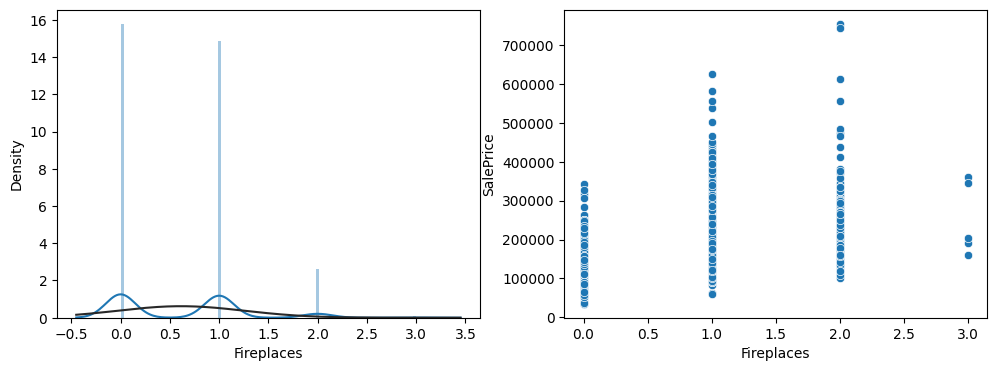

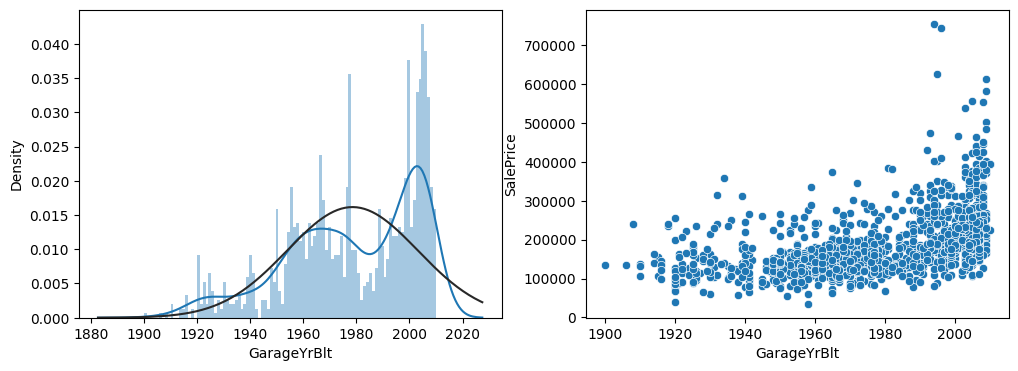

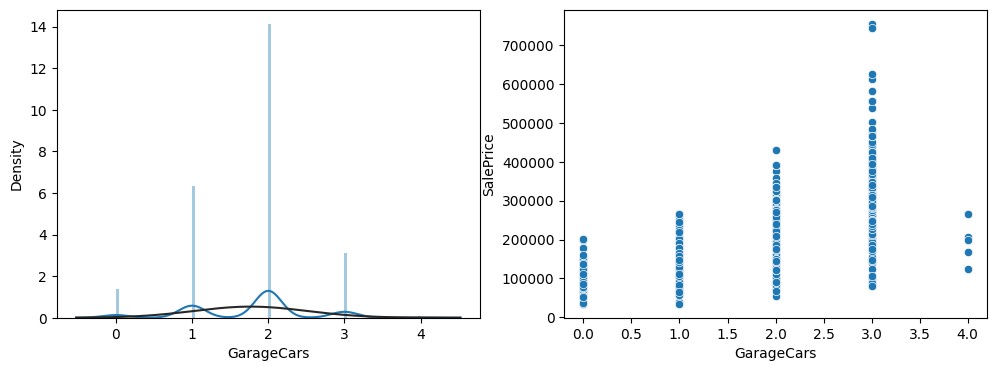

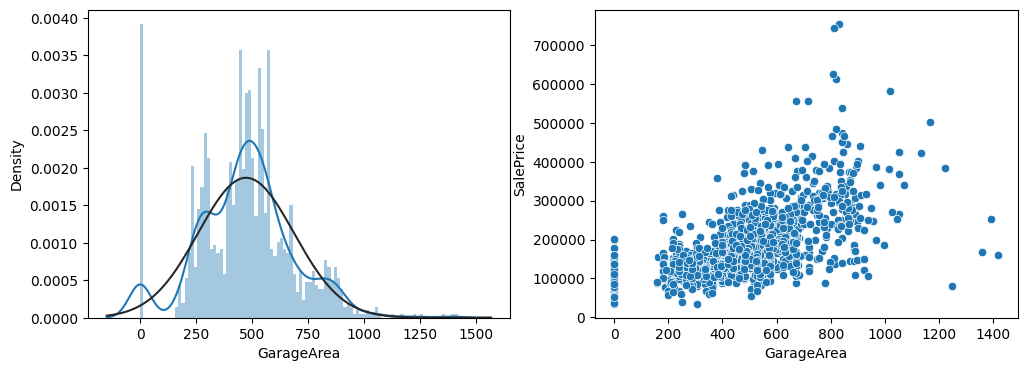

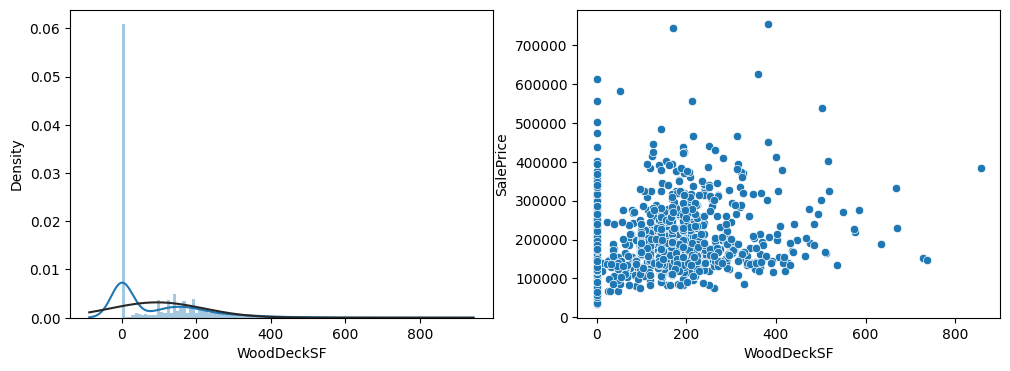

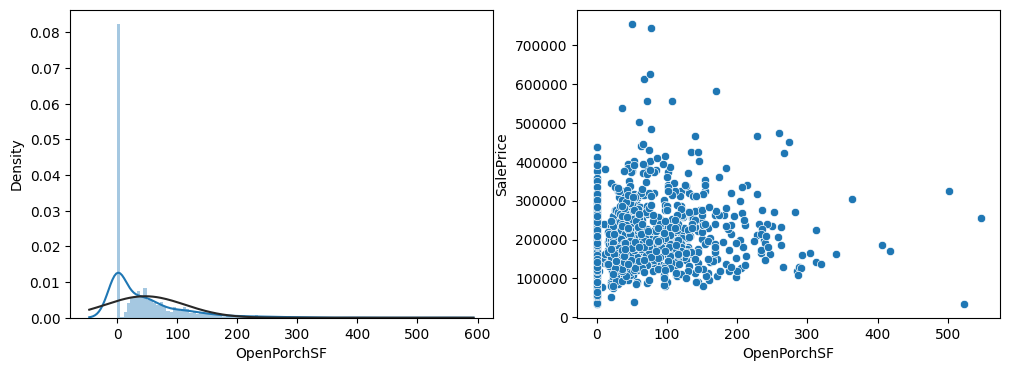

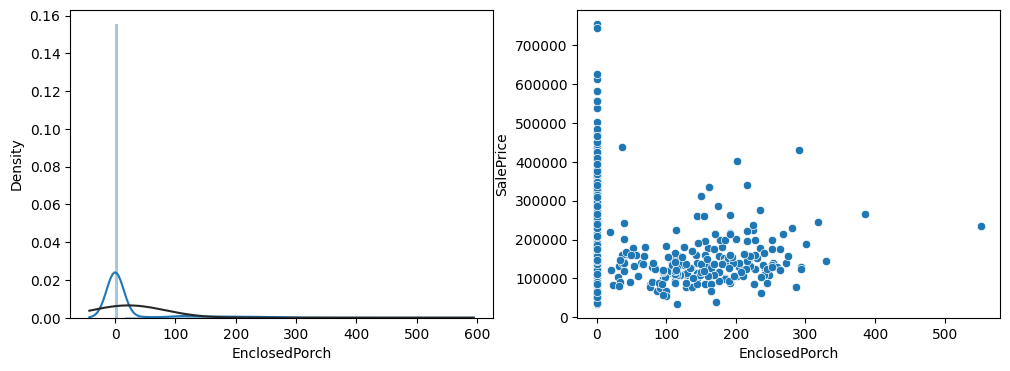

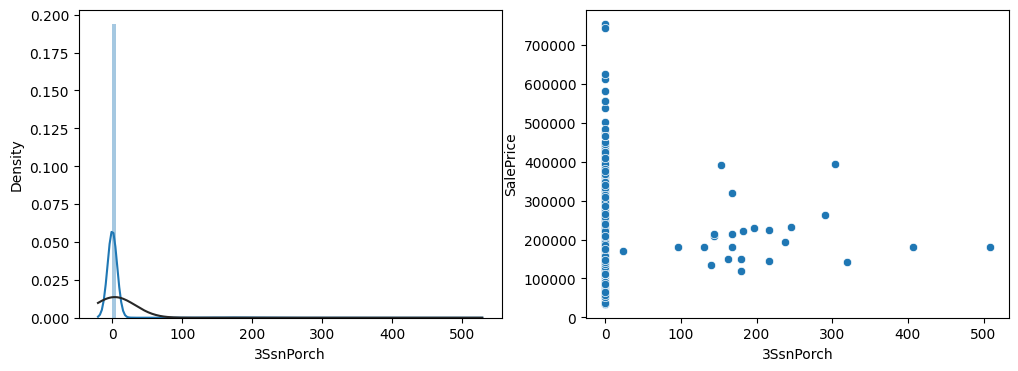

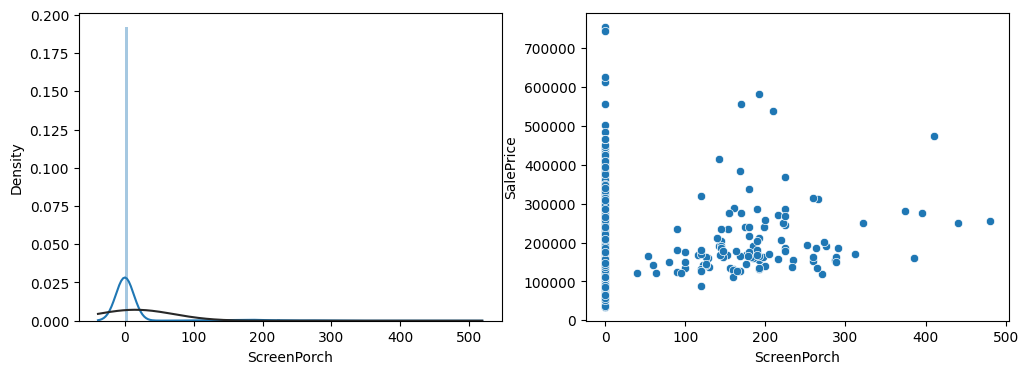

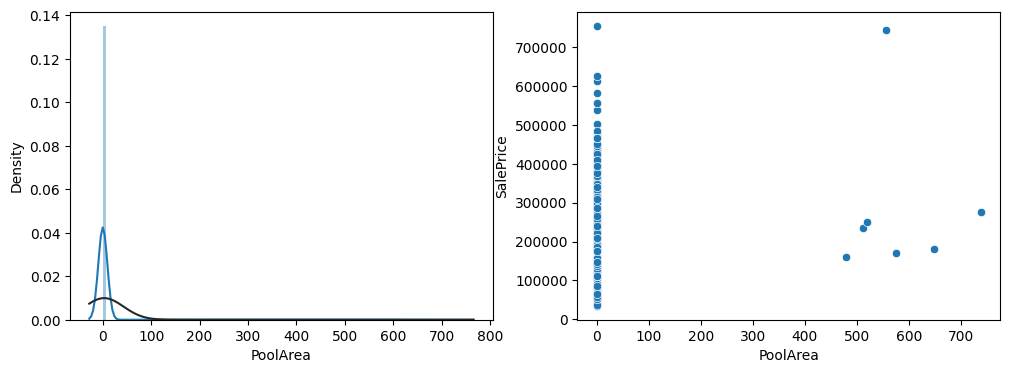

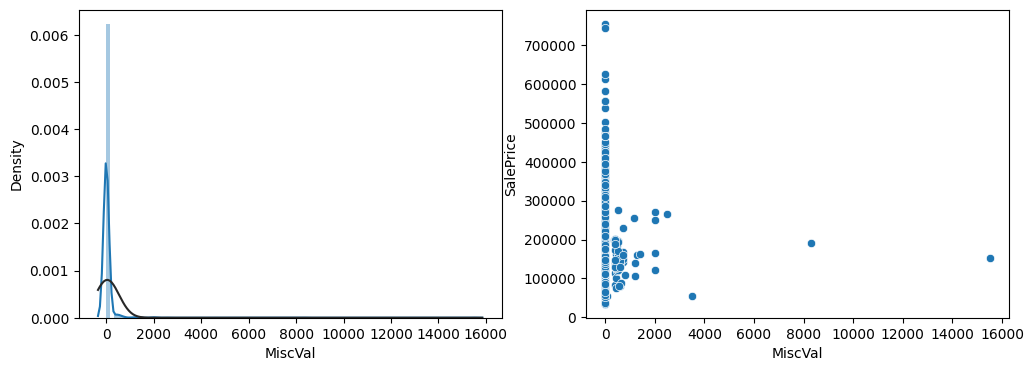

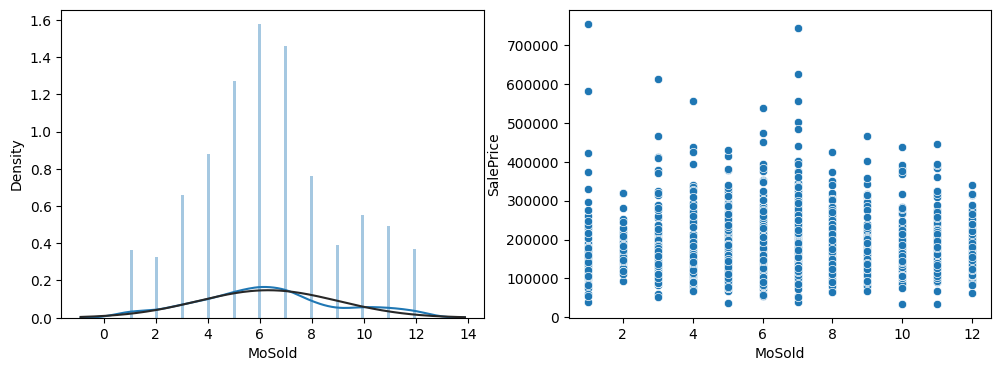

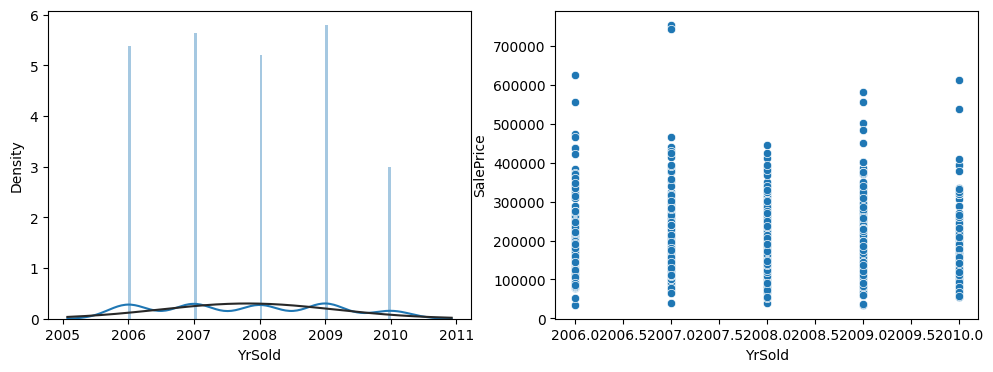

In [8]:
display_numerical_features(df=df, feature_names=numerical_features, target=y)

- There are features that should be categorical but are numerical. We will convert them to categorical features:
    - MSSubClass
    - MoSold
    - YrSold
    - OverallQual
    - OverallCond
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - PoolArea
    - MiscVal

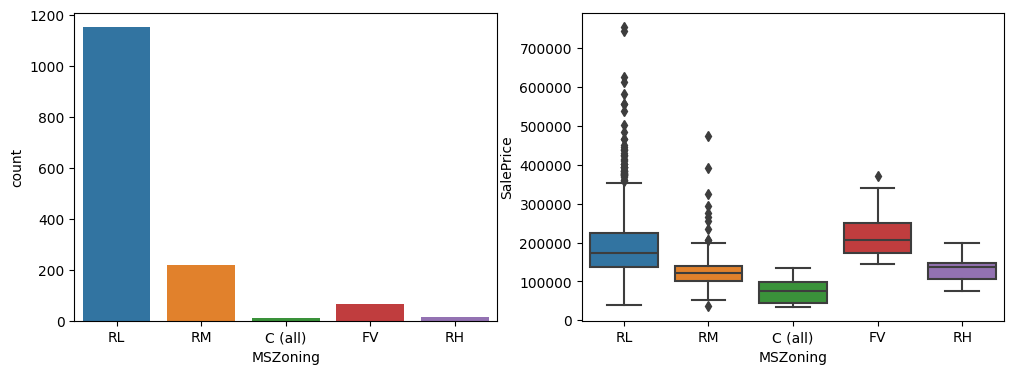

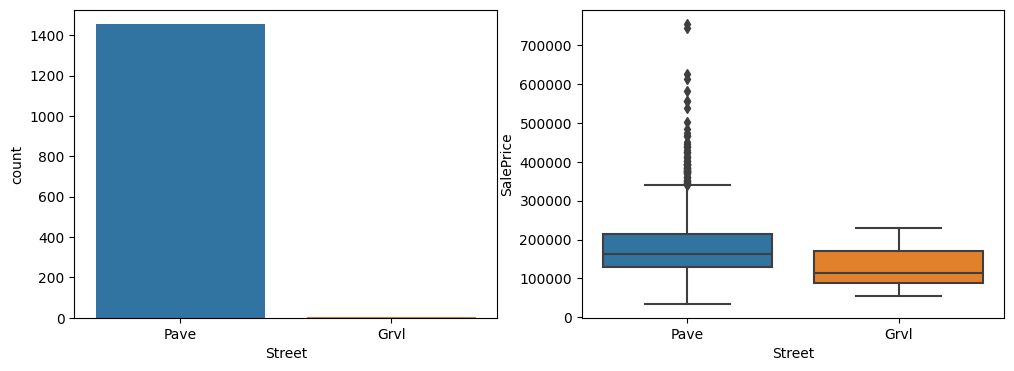

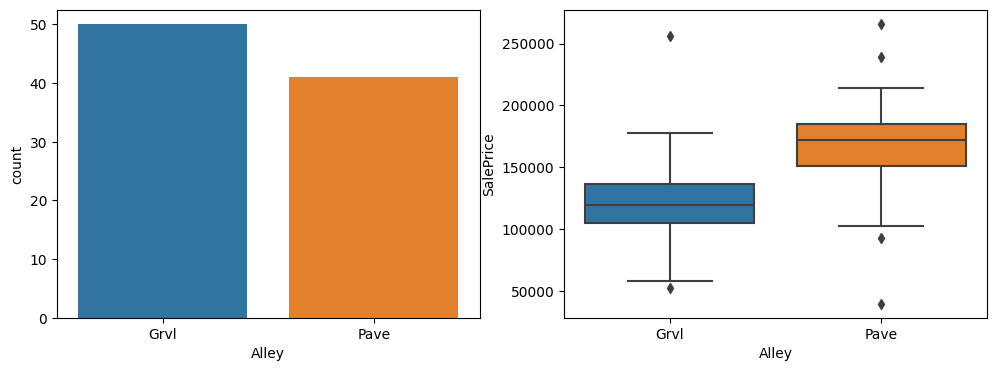

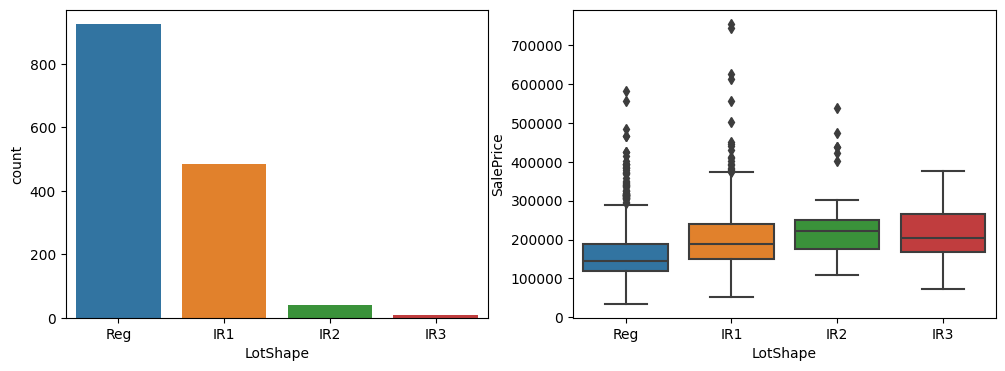

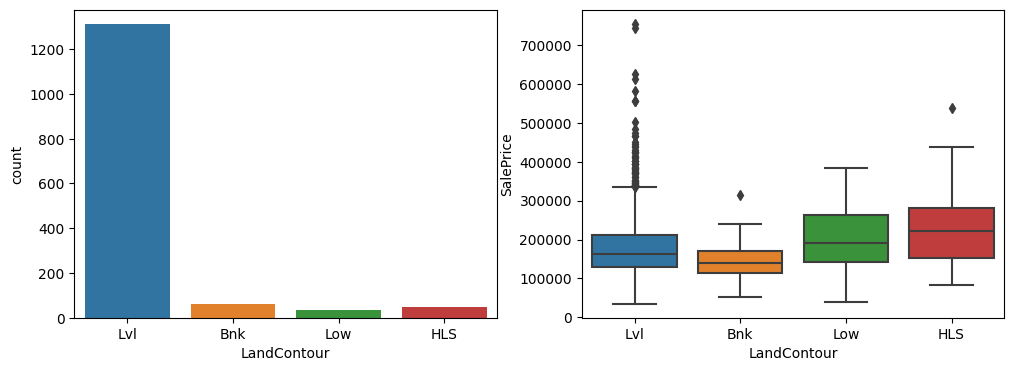

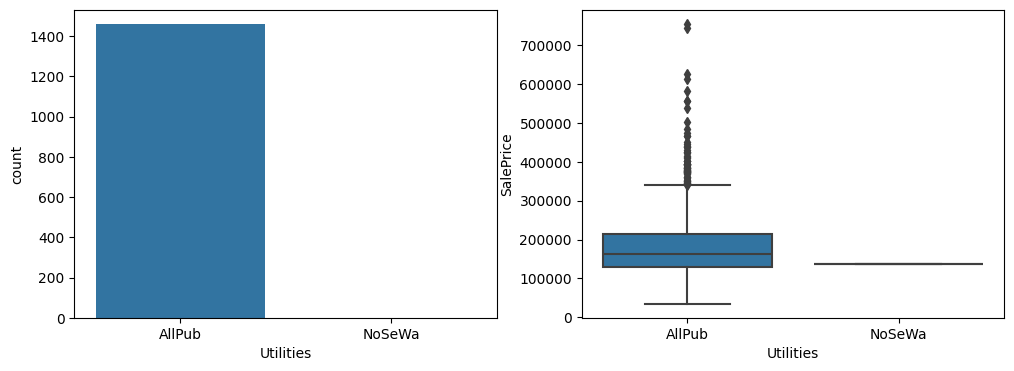

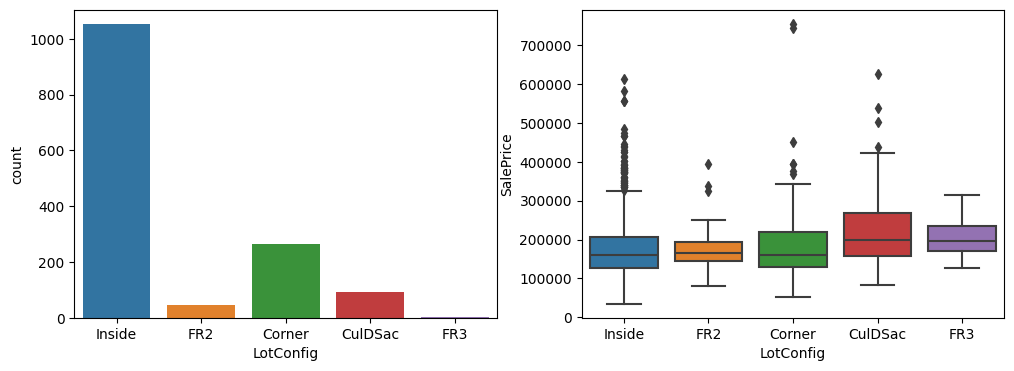

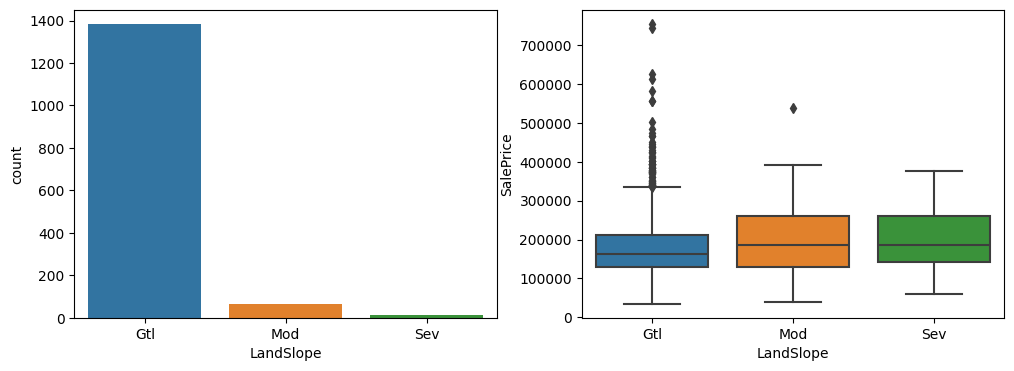

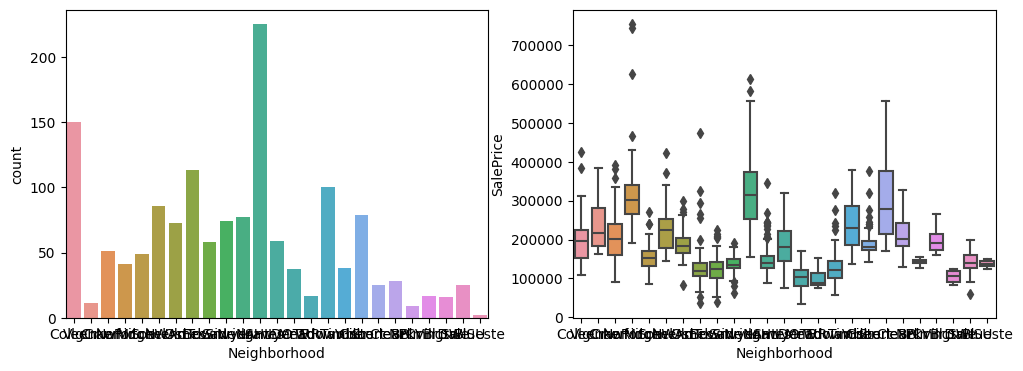

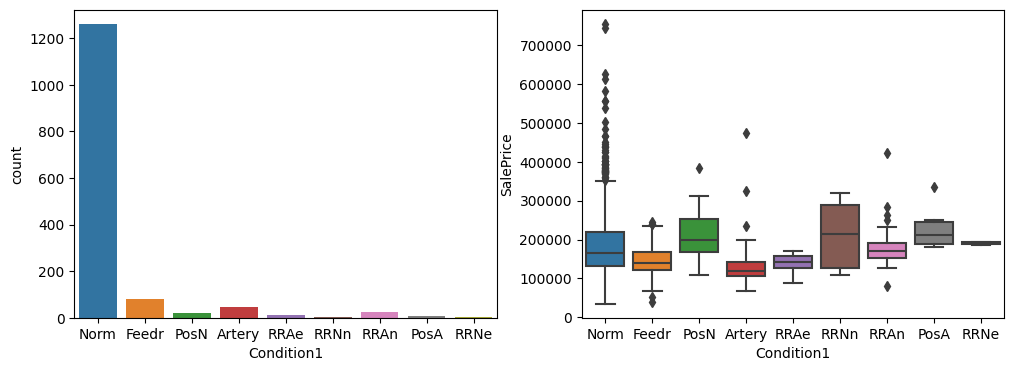

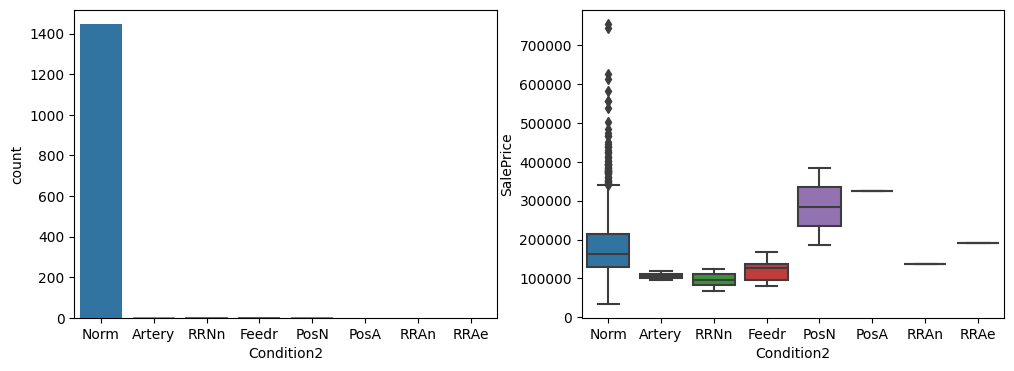

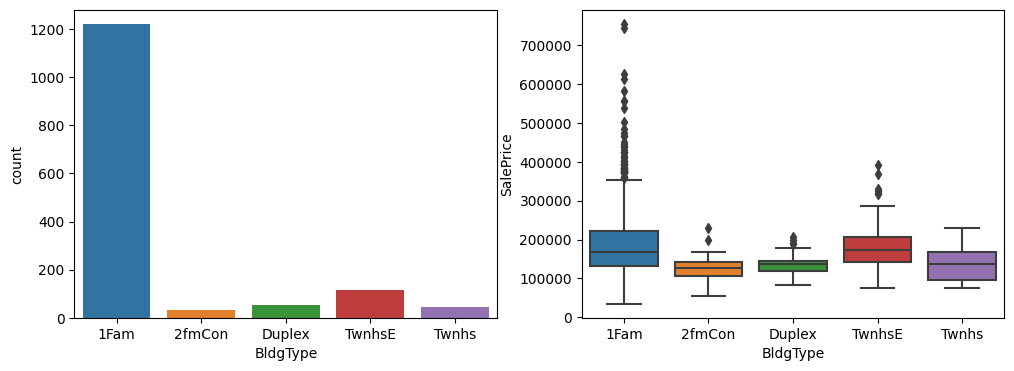

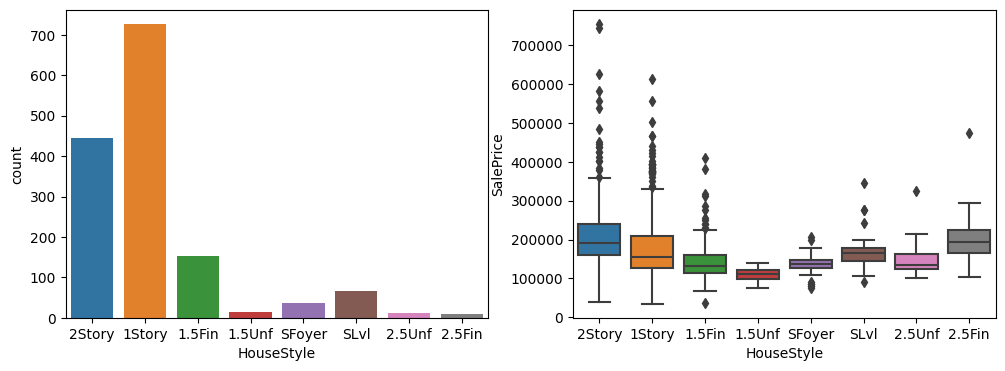

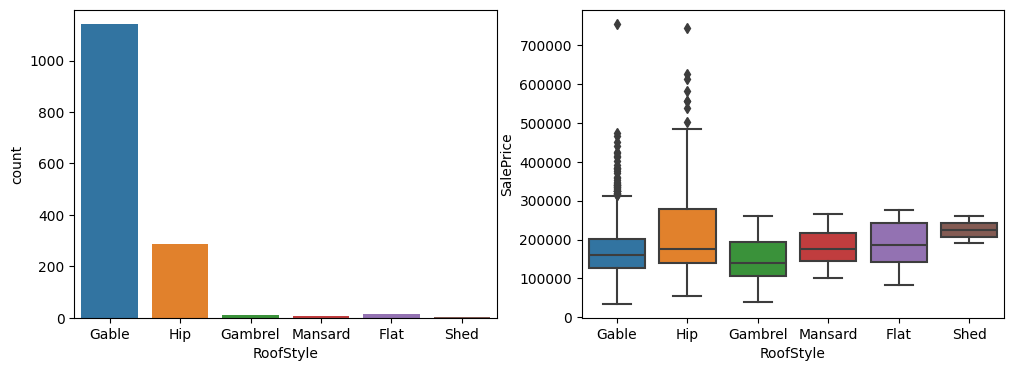

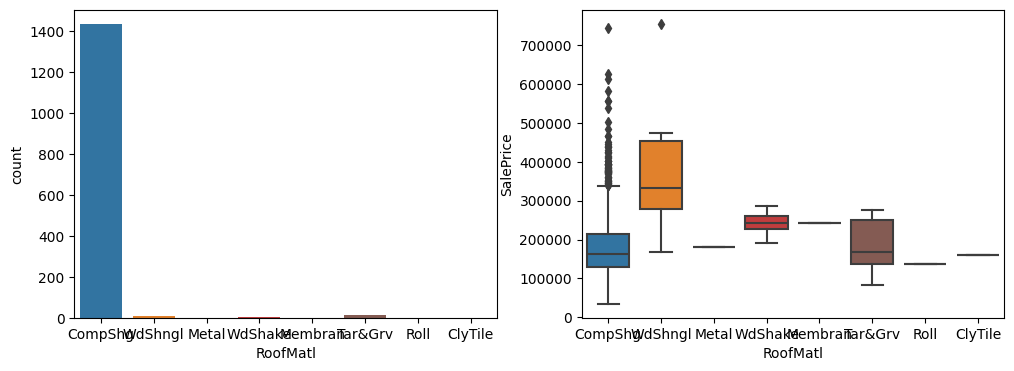

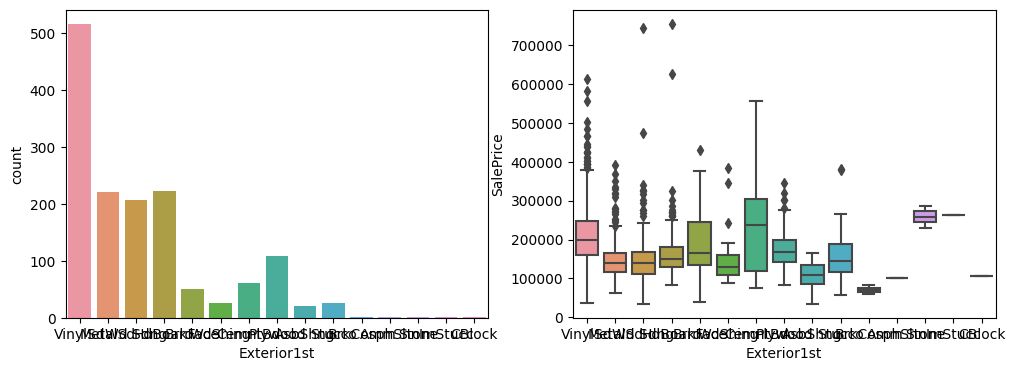

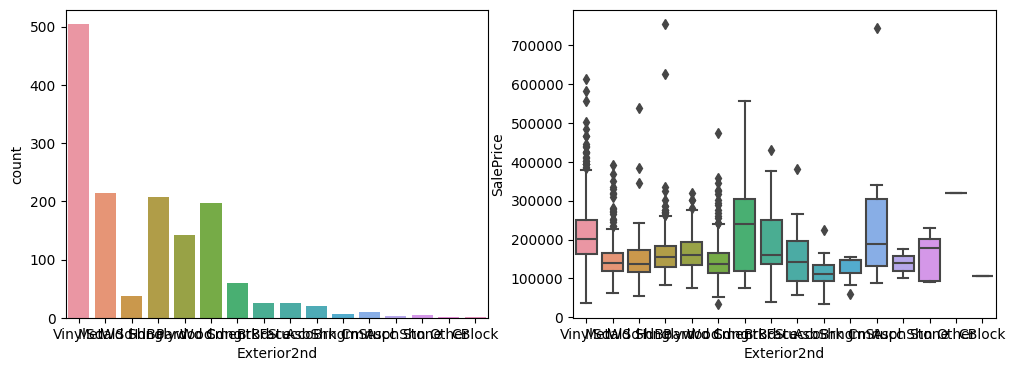

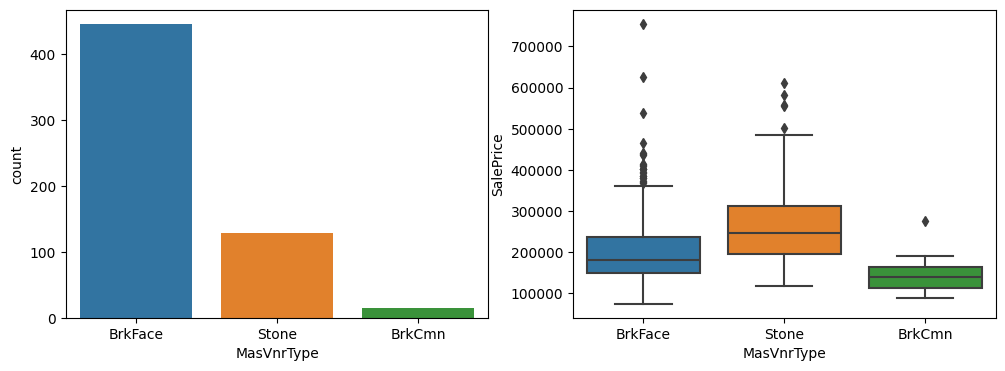

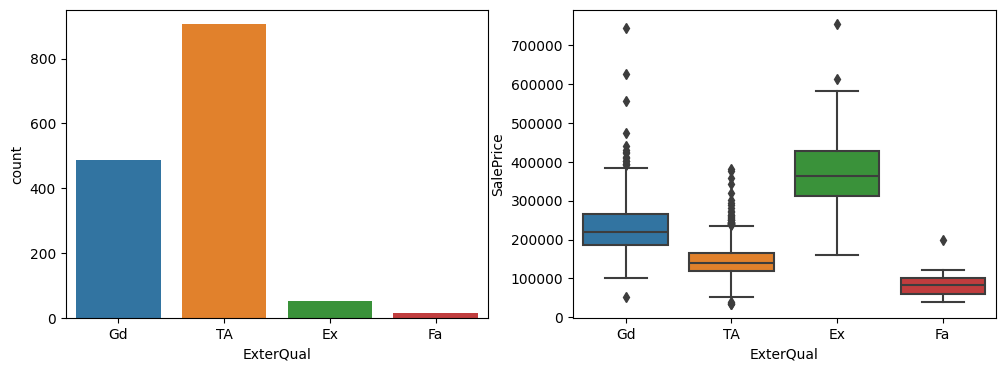

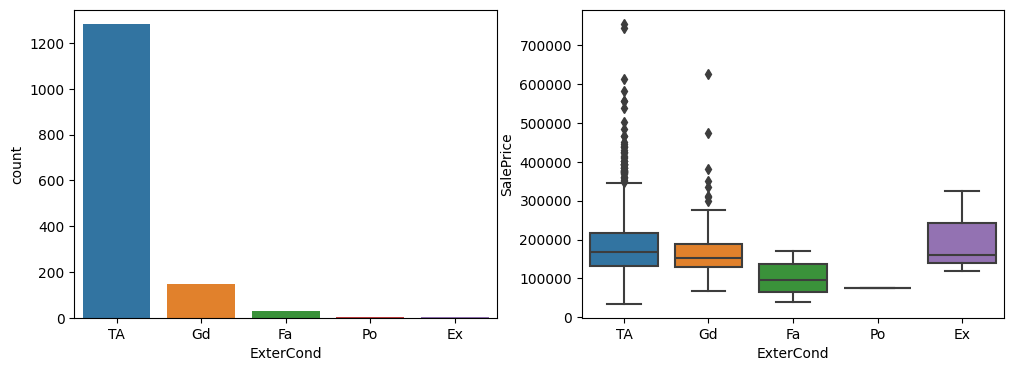

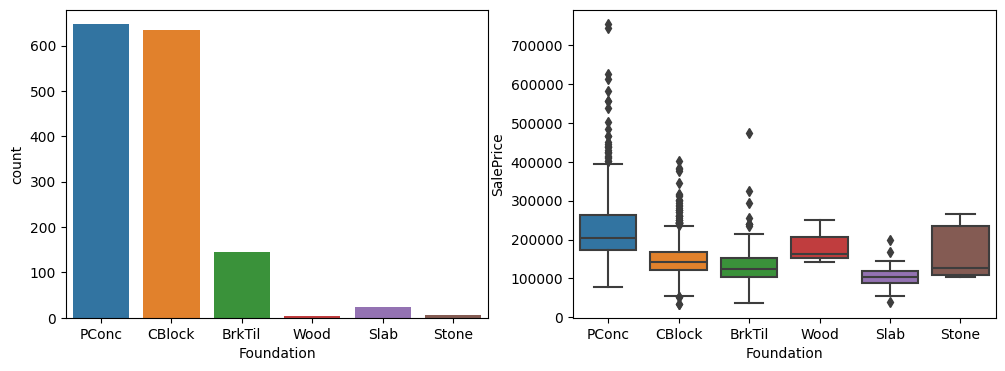

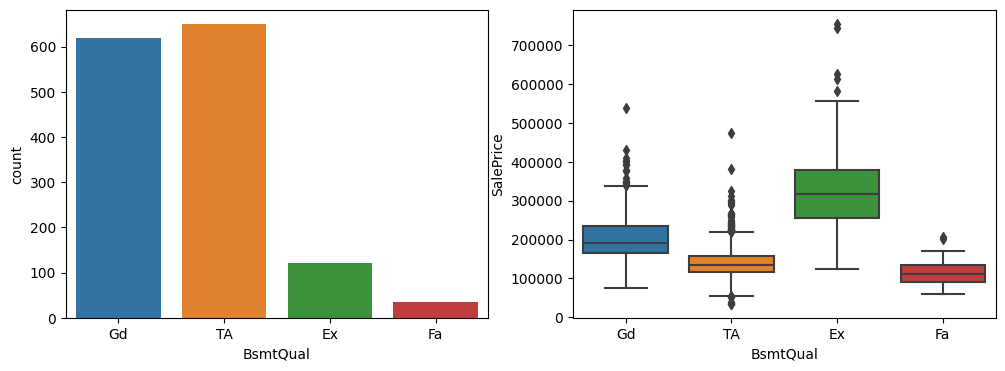

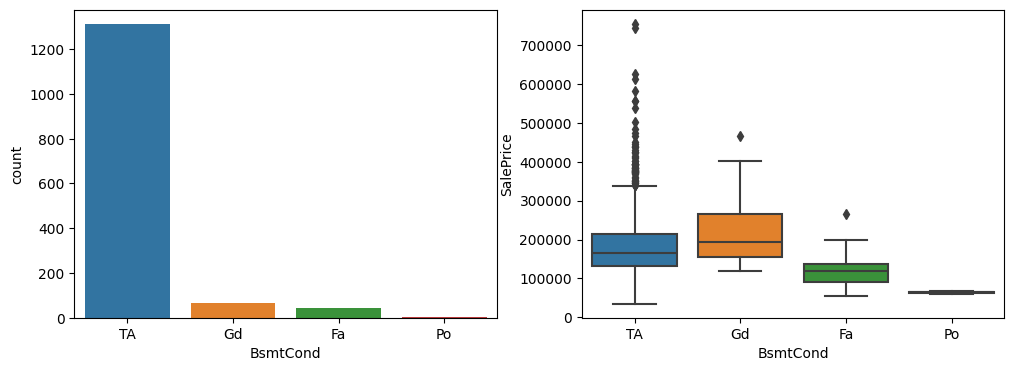

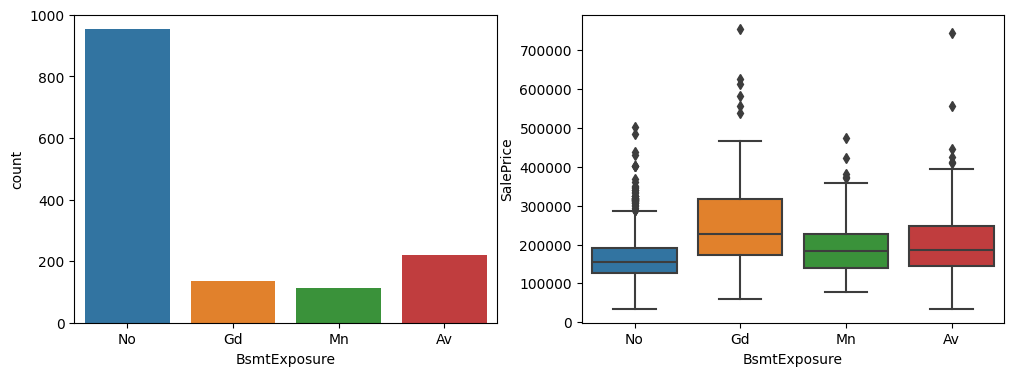

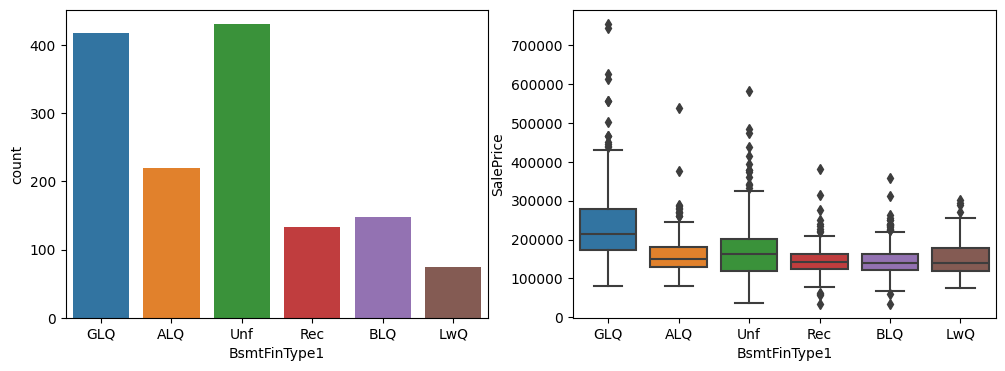

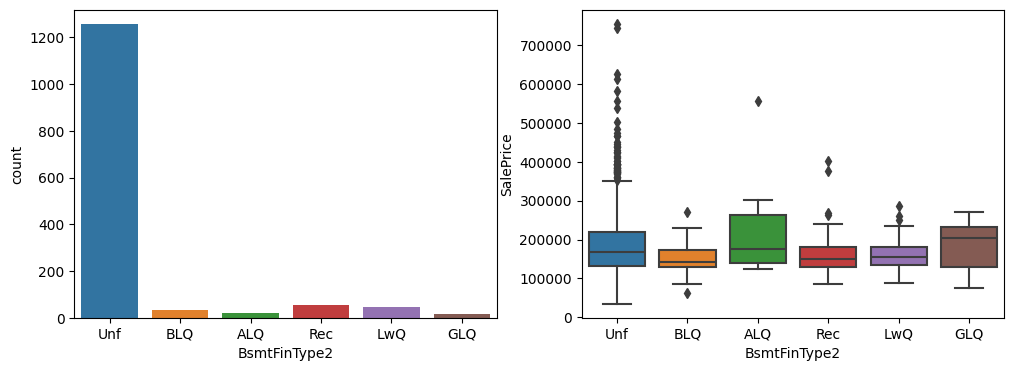

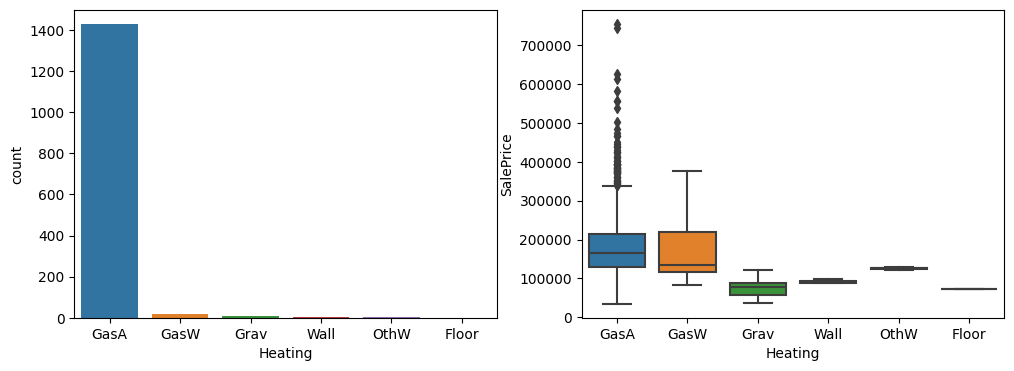

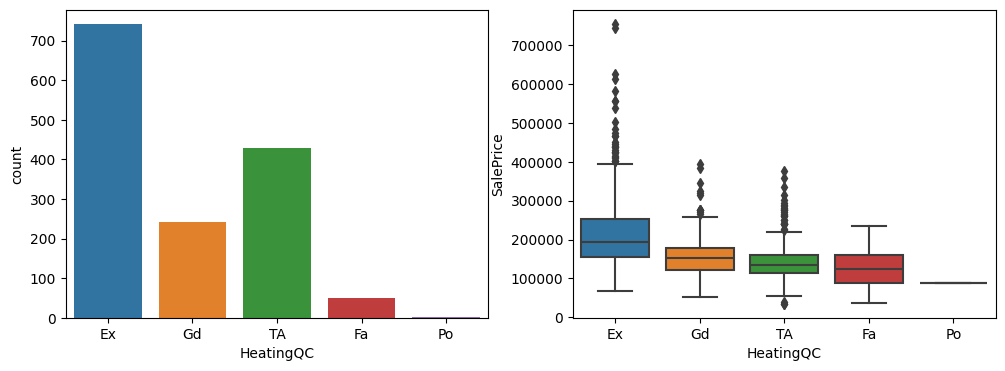

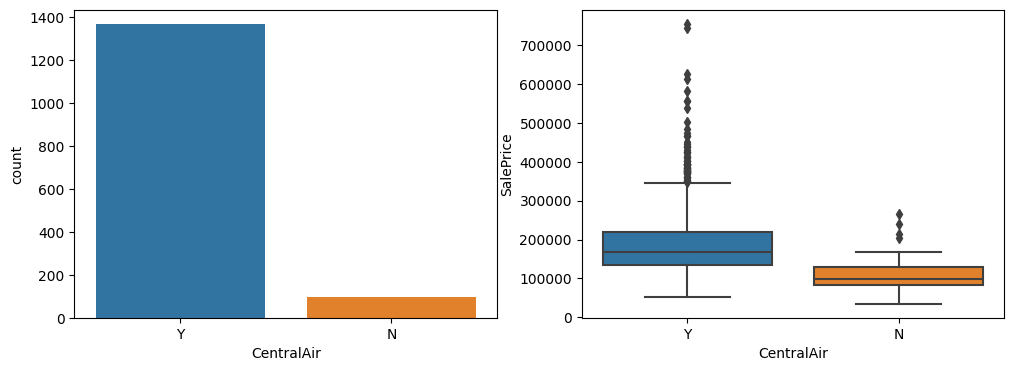

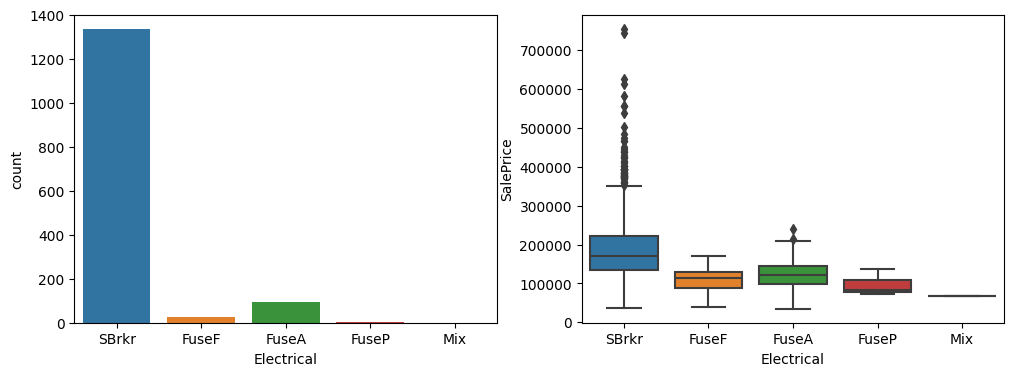

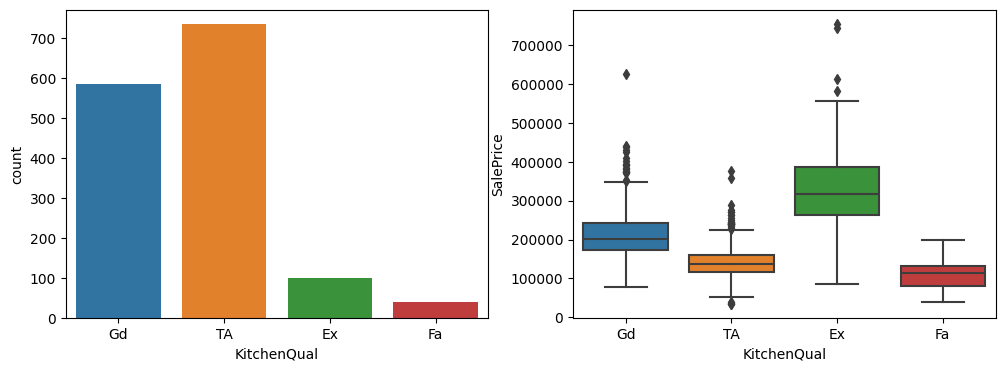

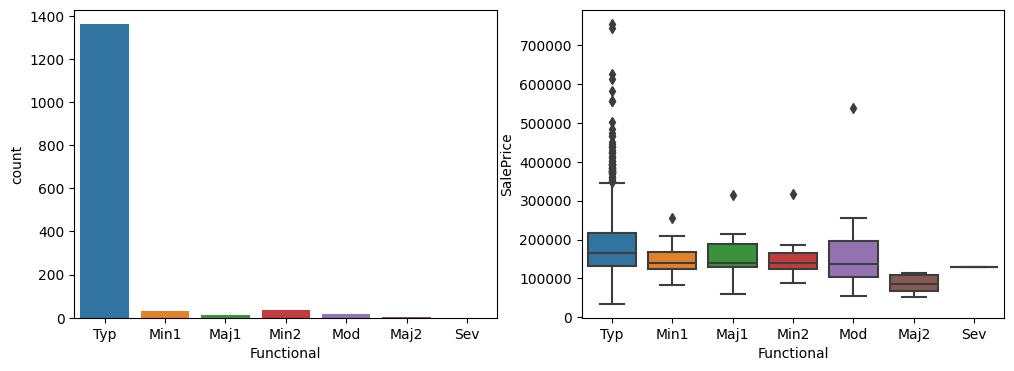

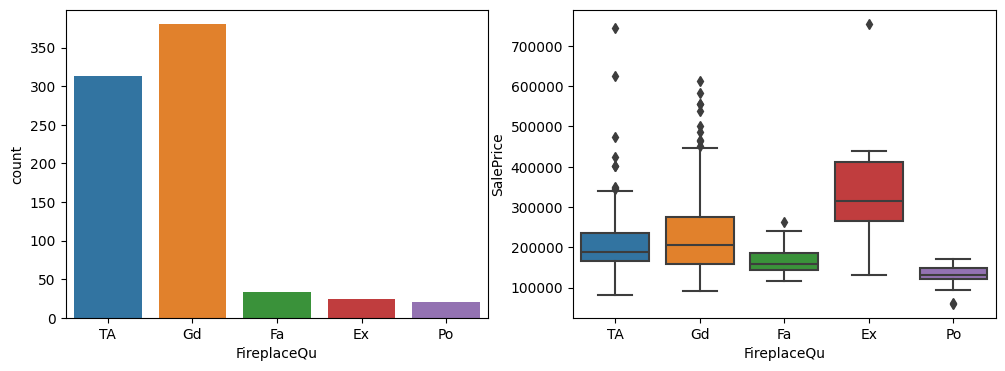

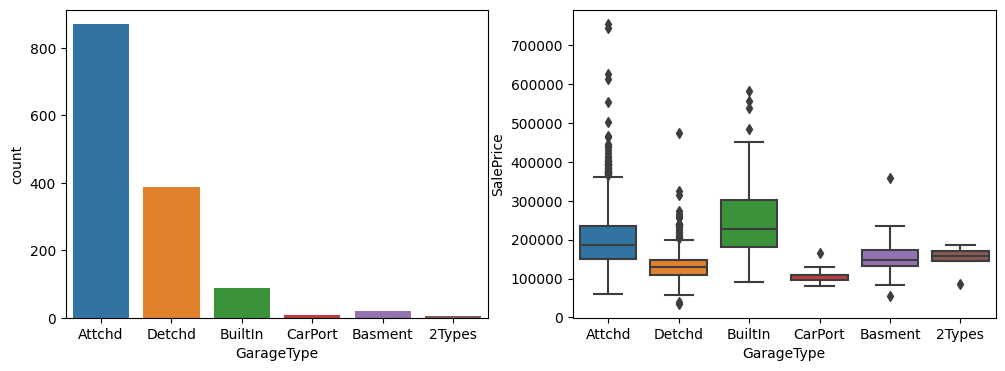

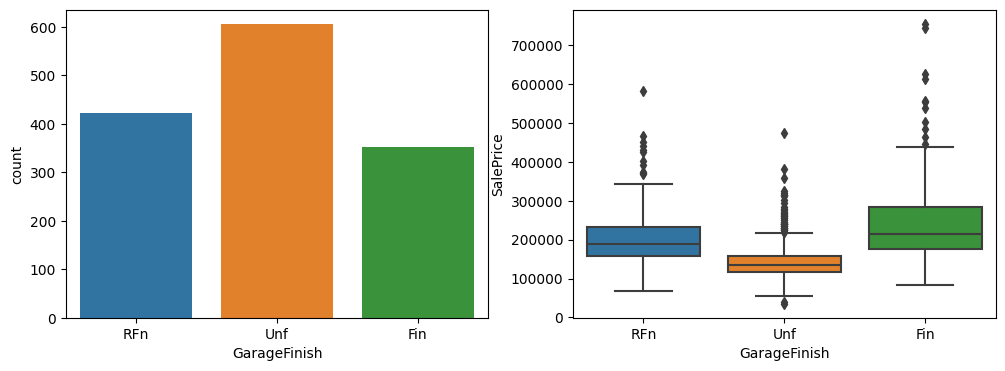

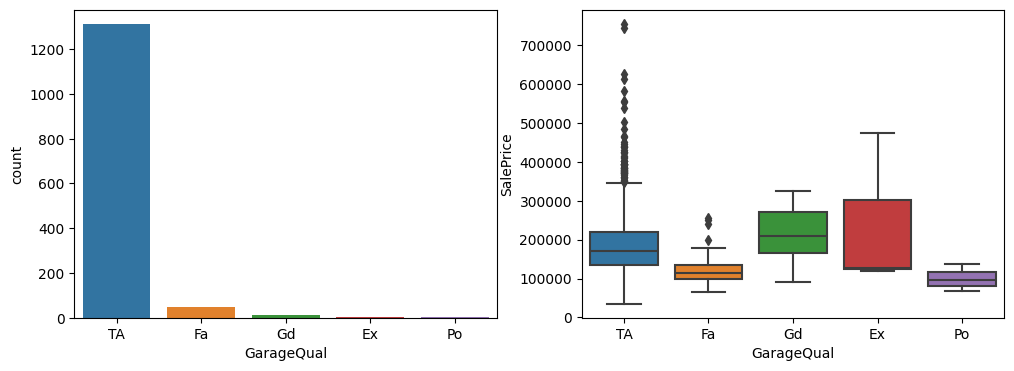

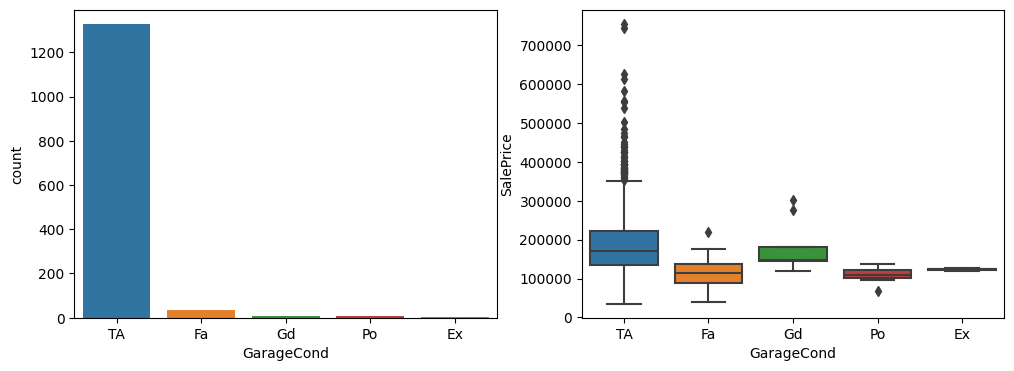

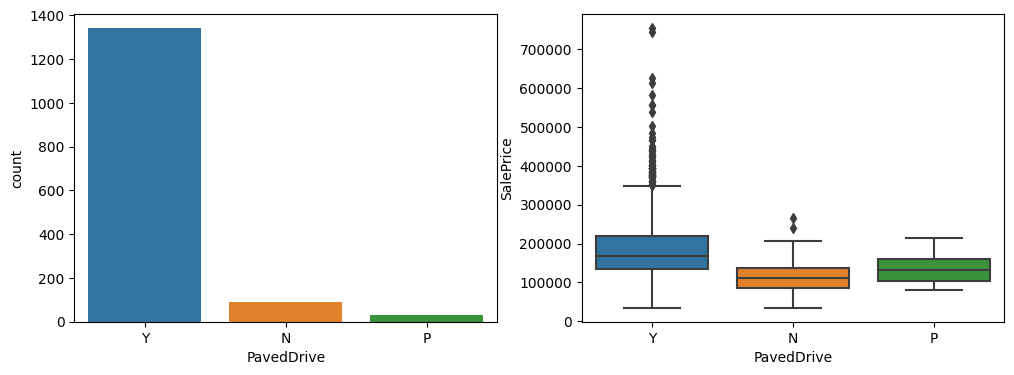

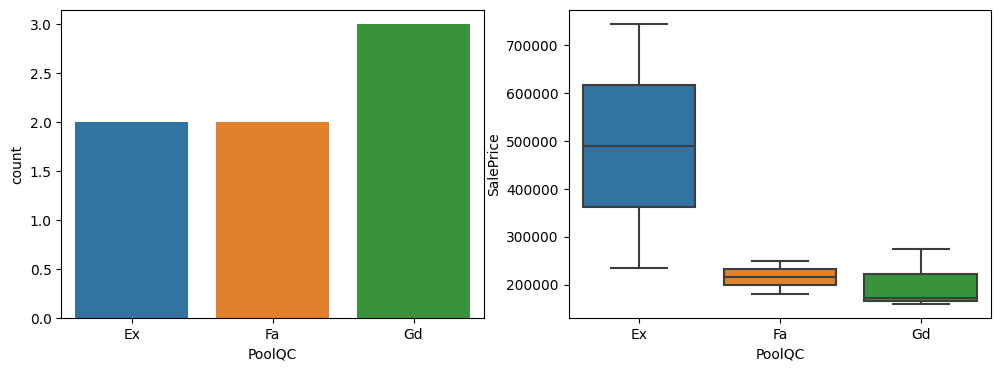

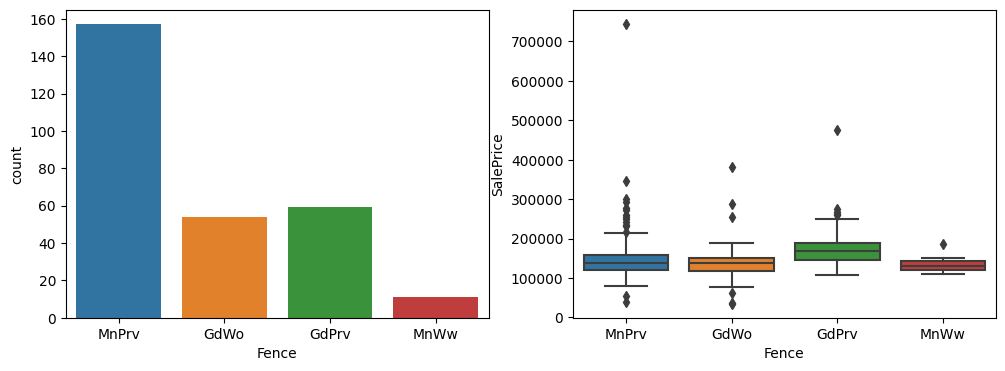

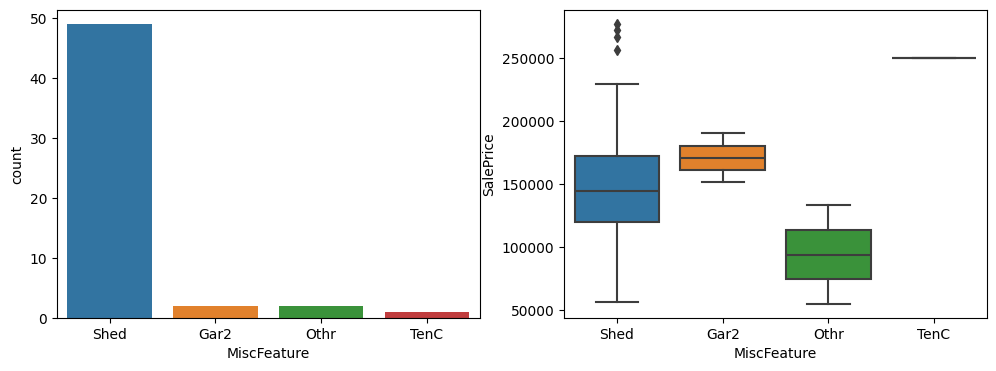

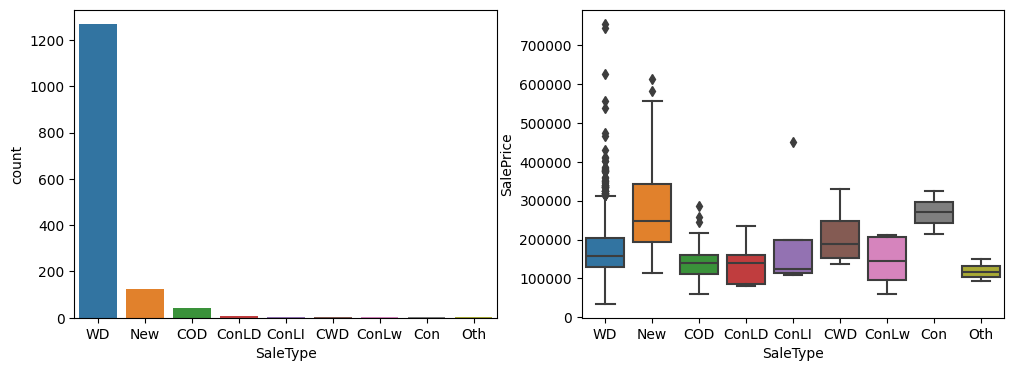

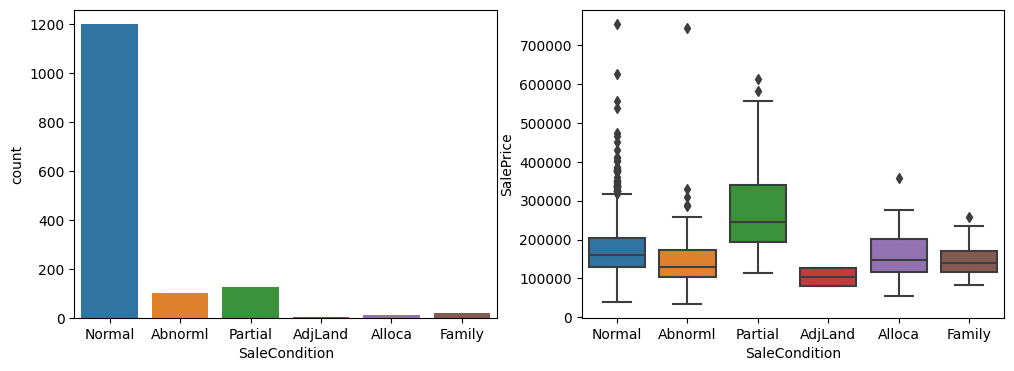

In [9]:
display_categorical_features(df=df, features_names=categorical_features, target=y)

### Exploration of the SF features:

In [10]:
temp = df[['GrLivArea','1stFlrSF','2ndFlrSF','GarageArea','TotalBsmtSF','LowQualFinSF','OpenPorchSF','EnclosedPorch','SalePrice']] # check the connection between all the SF features
temp.head(50)

GrLivArea  1stFlrSF  2ndFlrSF  GarageArea  TotalBsmtSF  LowQualFinSF  \
0        1710       856       854         548          856             0   
1        1262      1262         0         460         1262             0   
2        1786       920       866         608          920             0   
3        1717       961       756         642          756             0   
4        2198      1145      1053         836         1145             0   
5        1362       796       566         480          796             0   
6        1694      1694         0         636         1686             0   
7        2090      1107       983         484         1107             0   
8        1774      1022       752         468          952             0   
9        1077      1077         0         205          991             0   
10       1040      1040         0         384         1040             0   
11       2324      1182      1142         736         1175             0   
12        912       912         0         352          912             0   
13       1494      1494         0         840         1494             0   
14       1253      1253         0         352         1253             0   
15        854       854         0         576          832             0   
16       1004      1004         0         480         1004             0   
17       1296      1296         0         516            0             0   
18       1114      1114         0         576         1114             0   
19       1339      1339         0         294         1029             0   
20       2376      1158      1218         853         1158             0   
21       1108      1108         0         280          637             0   
22       1795      1795         0         534         1777             0   
23       1060      1060         0         572         1040             0   
24       1060      1060         0         270         1060             0   
25       1600      1600         0         890         1566             0   
26        900       900         0         576          900             0   
27       1704      1704         0         772         1704             0   
28       1600      1600         0         319         1484             0   
29        520       520         0         240          520             0   
30       1317       649       668         250          649             0   
31       1228      1228         0         271         1228             0   
32       1234      1234         0         484         1234             0   
33       1700      1700         0         447         1398             0   
34       1561      1561         0         556         1561             0   
35       2452      1132      1320         691         1117             0   
36       1097      1097         0         672         1097             0   
37       1297      1297         0         498         1297             0   
38       1057      1057         0         246         1057             0   
39       1152      1152         0           0            0             0   
40       1324      1324         0         440         1088             0   
41       1328      1328         0         308         1350             0   
42        884       884         0         504          840             0   
43        938       938         0         308          938             0   
44       1150      1150         0         300         1150             0   
45       1752      1752         0         576         1752             0   
46       2149      1518       631         670         1434             0   
47       1656      1656         0         826         1656             0   
48       1452       736       716           0          736             0   
49        955       955         0         386          955             0   

    OpenPorchSF  EnclosedPorch  SalePrice  
0            61              0     208500  
1             0              0     1815

## Part 1: Data Preprocessing and Feature Engineering
- Task: Handle missing values and categorize data in the dataset.
- Use techniques learned in Meeting 15 to deal with missing values and categories.
- Feature Engineering:
    - Implement fixed-width and quantile-based binning strategies from Meeting 16.
    - Document the rationale behind choosing specific bins and the impact on the dataset.


In [11]:
# Display missing values for numerical features in the training data
print("Missing values for numerical features in the training data:")
print(display_missing_values(df[numerical_features]))
print()

# Display missing values for categorical features in the training data
print("Missing values for categorical features in the training data:")
print(display_missing_values(df[categorical_features]))
print()

# Display missing values for numerical features in the test data
print("Missing values for numerical features in the test data:")
display_missing_values(df_test[numerical_features])
print()

# Display missing values for categorical features in the test data
print("Missing values for categorical features in the test data:")
display_missing_values(df_test[categorical_features])
print()

Missing values for numerical features in the training data:
             Missing Values  Percentage
LotFrontage             259       0.177
GarageYrBlt              81       0.055
MasVnrArea                8       0.005

Missing values for categorical features in the training data:
              Missing Values  Percentage
PoolQC                  1453       0.995
MiscFeature             1406       0.963
Alley                   1369       0.938
Fence                   1179       0.808
MasVnrType               872       0.597
FireplaceQu              690       0.473
GarageType                81       0.055
GarageCond                81       0.055
GarageQual                81       0.055
GarageFinish              81       0.055
BsmtFinType2              38       0.026
BsmtExposure              38       0.026
BsmtFinType1              37       0.025
BsmtQual                  37       0.025
BsmtCond                  37       0.025
Electrical                 1       0.001

Missing values for 

- Choose which strategy to use to impute each numerical feature:
    - 'LotFrontage': 'Zero'
    - 'MasVnrArea': 'mean' (will leave to the imputer)
    - 'GarageYrBlt': 'Zero'
- Choose which strategy to use to impute each categorical feature:
    - 'Alley': Null percentage is too high, will drop the column
    - 'MasVnrType': Null percentage is too high, will drop the column
    - 'BsmtQual': 'No Basement'
    - 'BsmtCond': 'No Basement'
    - 'BsmtExposure': 'No Basement'
    - 'BsmtFinType1': 'None'
    - 'BsmtFinType2': 'None'
    - 'Electrical': 'Most common value' (will leave to the imputer)
    - 'FireplaceQu': 'No Fireplace'
    - 'GarageType': 'No Garage'
    - 'GarageFinish': 'No Garage'
    - 'GarageQual': 'No Garage'
    - 'GarageCond': 'No Garage'
    - 'PoolQC': Null percentage is too high, will drop the column
    - 'Fence': Null percentage is too high, will drop the column
    - 'MiscFeature': Null percentage is too high, will drop the column

*** We do the imputation manually because in many of the features missing values actually mean lack of that feature.

In [12]:
# Impute missing values of numerical features based on the markdown above
df['LotFrontage'] = df['LotFrontage'].fillna(0)

df['YearBuilt'] = df['YearBuilt'].fillna(0)

In [13]:
# Impute missing values of categorical features based on the markdown above

# Find all missing value columns and put their names in a list
cat_features_with_missing = display_missing_values(df[categorical_features]).index.to_list()
cat_features_with_missing.remove('MiscFeature') # Remove 'MiscFeature' in order to impute separately

# Manually impute categorical features
impute_no_feature(df=df, feature_list=cat_features_with_missing)

df['MiscFeature'] = df['MiscFeature'].fillna('None')

### Outliers

In [14]:
# Remove outliers from the numerical features in the training data
for feature in numerical_features:
    outlier_removal(data=df, column=feature)
    remove_outliers_zscore(df=df, column=feature)
    
# Remove outliers from the numerical features in the test data
for feature in numerical_features:
    outlier_removal(data=df_test, column=feature)
    remove_outliers_zscore(df=df_test, column=feature)

In [15]:
# Remove outliers from the target variable
outlier_removal(data=df, column='SalePrice')
df = remove_outliers_zscore(df=df, column='SalePrice')

### Binning

- There were two features whose distributions were clearly split into more than one section: 'YearBuilt' and 'YearRemodAdd'.
- We will use the Gaussian Mixture Model to split these features into bins.

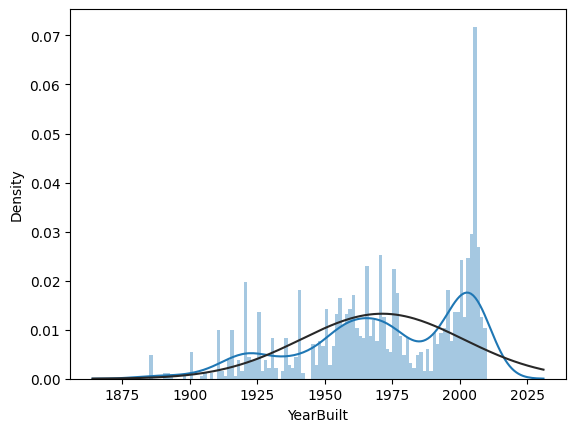

In [16]:
# Display original 'YearBuilt' distribution
sns.distplot(df['YearBuilt'], fit=norm, bins=100, kde=True);

In [17]:
# Segment 'YearBuilt' based on distribution into 3 separate bins
# Generate the Gaussian mixture model 
gmm = GaussianMixture(n_components=3, random_state=42)

# Fit the model on the data and predict the cluster for each data point
df['YearBuilt_binned'] = gmm.fit_predict(df[['YearBuilt']])

# Check the means and covariances
print(gmm.means_)
print(gmm.covariances_)

[[1924.65769072]
 [2002.41802977]
 [1966.72693242]]
[[[250.87128375]]

 [[ 21.15569047]]

 [[158.98926954]]]


In [18]:
# Group the data by the binned feature and display the nin and max values to find the cutoff points
df.groupby('YearBuilt_binned')['YearBuilt'].agg(['min', 'max'])

min   max
YearBuilt_binned            
0                 1885  1942
1                 1992  2010
2                 1945  1991

In [19]:
# Rename the binned feature values to year ranges
df['YearBuilt_binned'] = df['YearBuilt_binned'].map({0: '1992-2010', 1: 'Before 1945', 2: '1945-1991'})

In [20]:
# Bin the 'YearBuilt' feature in the test data via custom function based on the cutoff points found in the training data
def bin_year_built(year):
    if year <= 1945:
        return 'Before 1945'
    elif year <= 1991:
        return '1945-1991'
    else:
        return '1992-2010'

df_test['YearBuilt_binned'] = df_test['YearBuilt'].apply(bin_year_built)

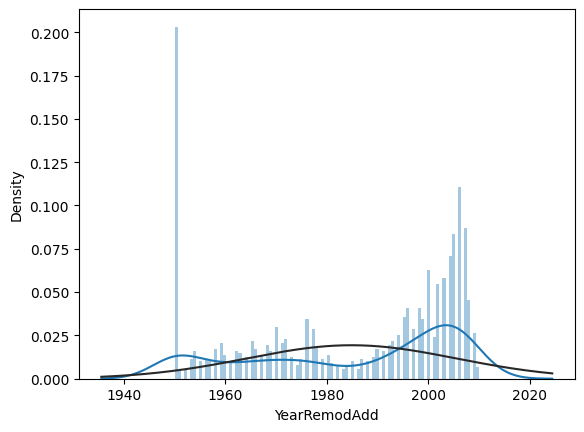

In [21]:
# Display original 'YearRemodAdd' distribution
sns.distplot(df['YearRemodAdd'], fit=norm, bins=100, kde=True);

In [22]:
# Segment 'YearRemodAdd' based on distribution into 2 separate bins
# Generate the Gaussian mixture model 
gmm = GaussianMixture(n_components=3, random_state=42)

# Fit the model on the data and predict the cluster for each data point
df['YearRemodAdd_binned'] = gmm.fit_predict(df[['YearRemodAdd']])

# Check the means and covariances
print(gmm.means_)
print(gmm.covariances_)

[[1950.        ]
 [2002.07867674]
 [1971.16440759]]
[[[1.00000000e-06]]

 [[2.38404839e+01]]

 [[1.22846724e+02]]]


In [23]:
# Group the data by the binned feature and display the nin and max values to find the cutoff points
df.groupby('YearRemodAdd_binned')['YearRemodAdd'].agg(['min', 'max'])

min      max
YearRemodAdd_binned                  
0                   1950.000 1950.000
1                   1991.000 2010.000
2                   1951.000 1990.000

In [24]:
# Rename the binned feature values to year ranges
df['YearRemodAdd_binned'] = df['YearRemodAdd_binned'].map({0: '1991-2010', 1:'1950', 2: '1951-1990'})

In [25]:
df['YearRemodAdd_binned'].value_counts()

YearRemodAdd_binned
1950         782
1951-1990    500
1991-2010    178
Name: count, dtype: int64

In [26]:
# Bin the 'YearRemodAdd' feature in the test data via custom function based on the cutoff points found in the training data
def bin_year_remod_add(year):
    if year <= 1990:
        return 'Before 1990'
    else:
        return '1990-2010'

df_test['YearRemodAdd_binned'] = df_test['YearRemodAdd'].apply(bin_year_remod_add)

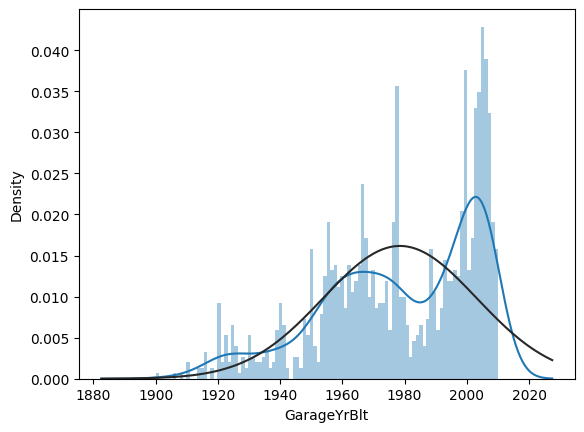

In [27]:
# Display original 'GarageYrBlt' distribution
sns.distplot(df['GarageYrBlt'], fit=norm, bins=100, kde=True);

In [28]:
# Check the number of missing values in the 'GarageYrBlt' feature
df['GarageYrBlt'].isnull().sum()

81

In [29]:
# Impute missing values of 'GarageYrBlt' with 0
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [30]:
# Segment 'GarageYrBlt' based on distribution into 3 separate bins
# Generate the Gaussian mixture model
gmm = GaussianMixture(n_components=4, random_state=42)

# Fit the model on the data and predict the cluster for each data point
df['GarageYrBlt_binned'] = gmm.fit_predict(df[['GarageYrBlt']])

# Check the means and covariances
print(gmm.means_)
print(gmm.covariances_)

[[1948.69780482]
 [   0.        ]
 [1972.13352206]
 [2002.35136505]]
[[[3.95113391e+02]]

 [[1.00000000e-06]]

 [[1.46880537e+02]]

 [[2.14037334e+01]]]


In [31]:
# Group the data by the binned feature and display the nin and max values to find the cutoff points
df.groupby('GarageYrBlt_binned')['GarageYrBlt'].agg(['min', 'max'])

min      max
GarageYrBlt_binned                  
0                  1900.000 1955.000
1                     0.000    0.000
2                  1956.000 1992.000
3                  1993.000 2010.000

In [32]:
# Rename the binned feature values to year ranges based on the cutoff points
df['GarageYrBlt_binned'] = df['GarageYrBlt_binned'].map({0: '1993-2010', 1: 'No Garage', 2: 'Before 1953', 3: '1954-1992'})

In [33]:
# Bin the 'GarageYrBlt' feature in the test data via custom function based on the cutoff points found in the training data
def bin_garage_year_built(year):
    if year <= 1953:
        return 'Before 1953'
    elif year <= 1992:
        return '1954-1992'
    elif year <= 2010:
        return '1993-2010'
    else:
        return 'No Garage'

df_test['GarageYrBlt_binned'] = df_test['GarageYrBlt'].apply(bin_garage_year_built)

In [34]:
# Add the new feature to the list of categorical features
categorical_features = categorical_features.append(pd.Index(['YearBuilt_binned', 'YearRemodAdd_binned', 'GarageYrBlt_binned']))

In [35]:
# Drop the original features from the numerical features list
numerical_features = numerical_features.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])

In [36]:
# Drop the original features from the training and test data
df = df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1)
df_test = df_test.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1)

### The Quality Features:

- We will use the quantile-based binning strategy to some of the quality features outlined below:
    - 'OverallCond'
    - 'ExterQual'
    - 'ExterCond'
    - 'BsmtQual'
    - 'BsmtCond'
    - 'HeatingQC'
    - 'KitchenQual'
    - 'FireplaceQu'
    - 'GarageQual'
    - 'GarageCond'
    - 'PoolQC'

- The incentive to do this is that most of the data points in these features are concentrated in a few bins, and the rest of the bins have very few data points. This will help us reduce the number of features in the dataset.
- We will use quantile-based binning to bin the following features because the data is ordinal and there are any outliers.
- We leave 'OverallQual' out of this list because we will later deal with it separately.

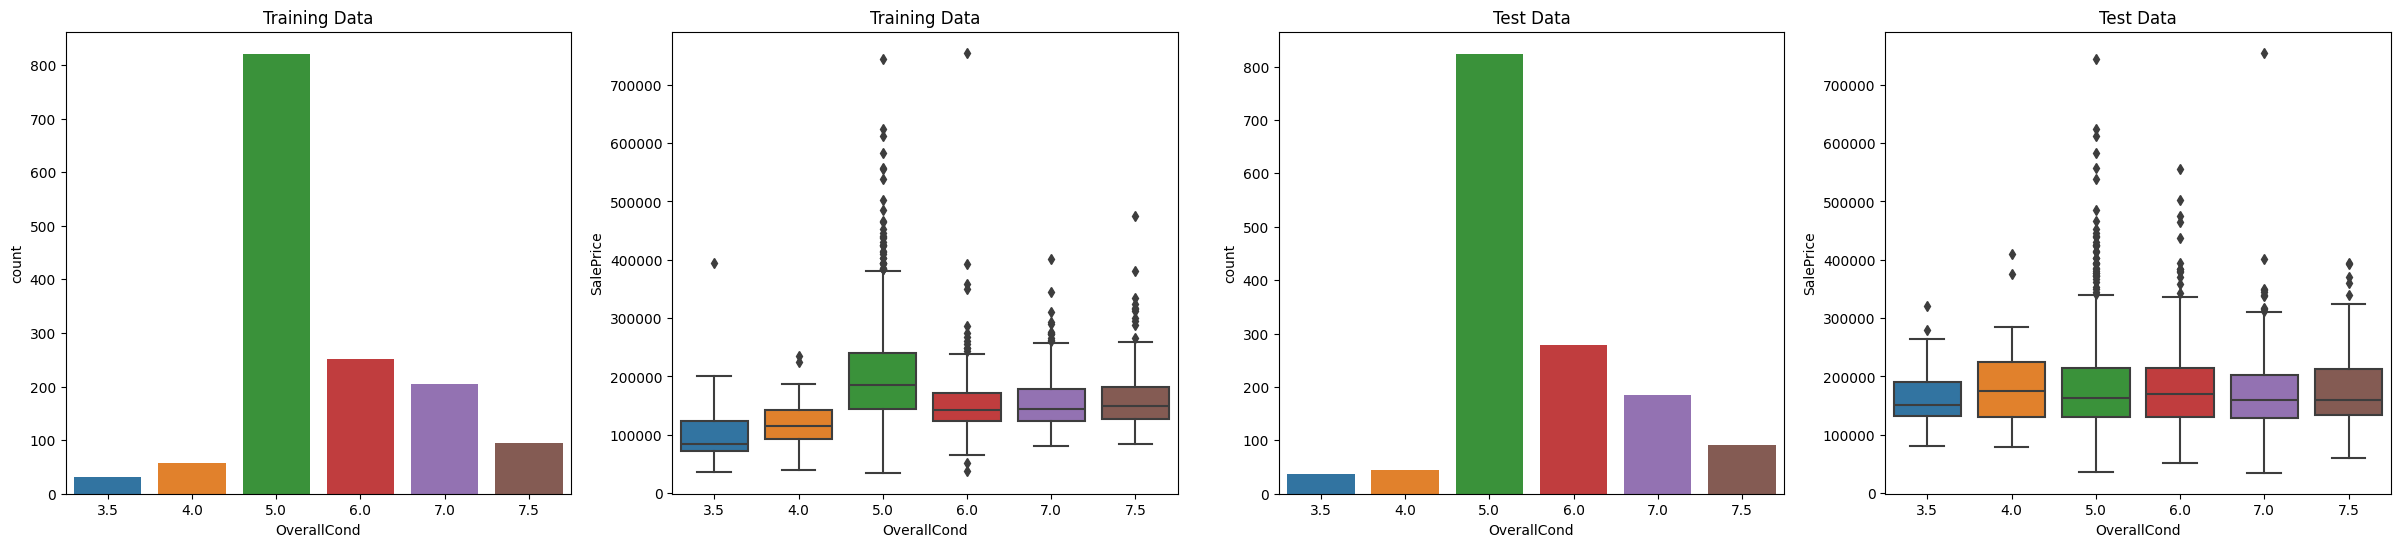

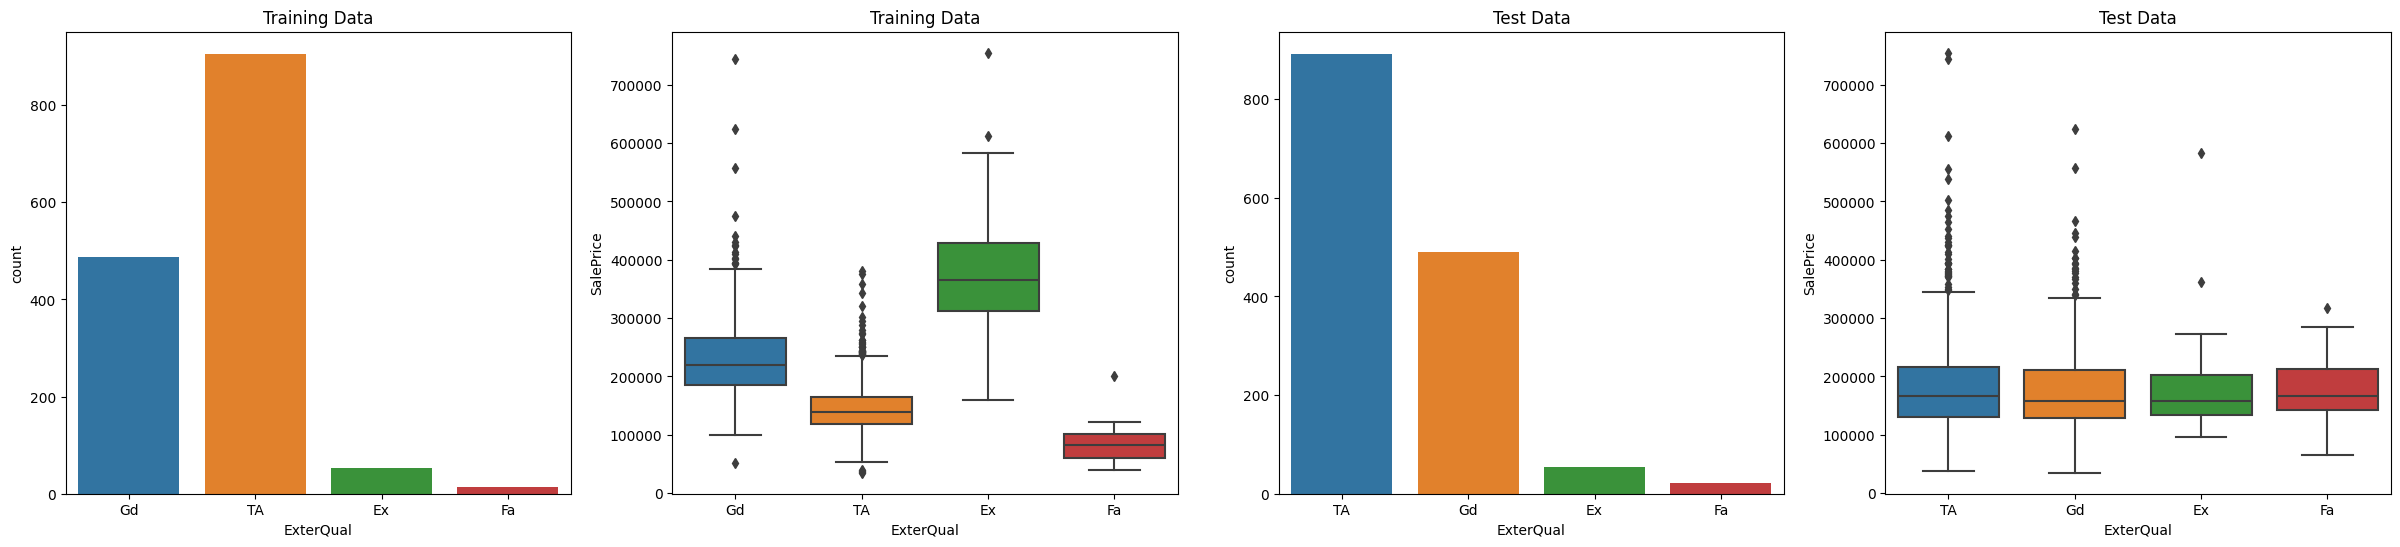

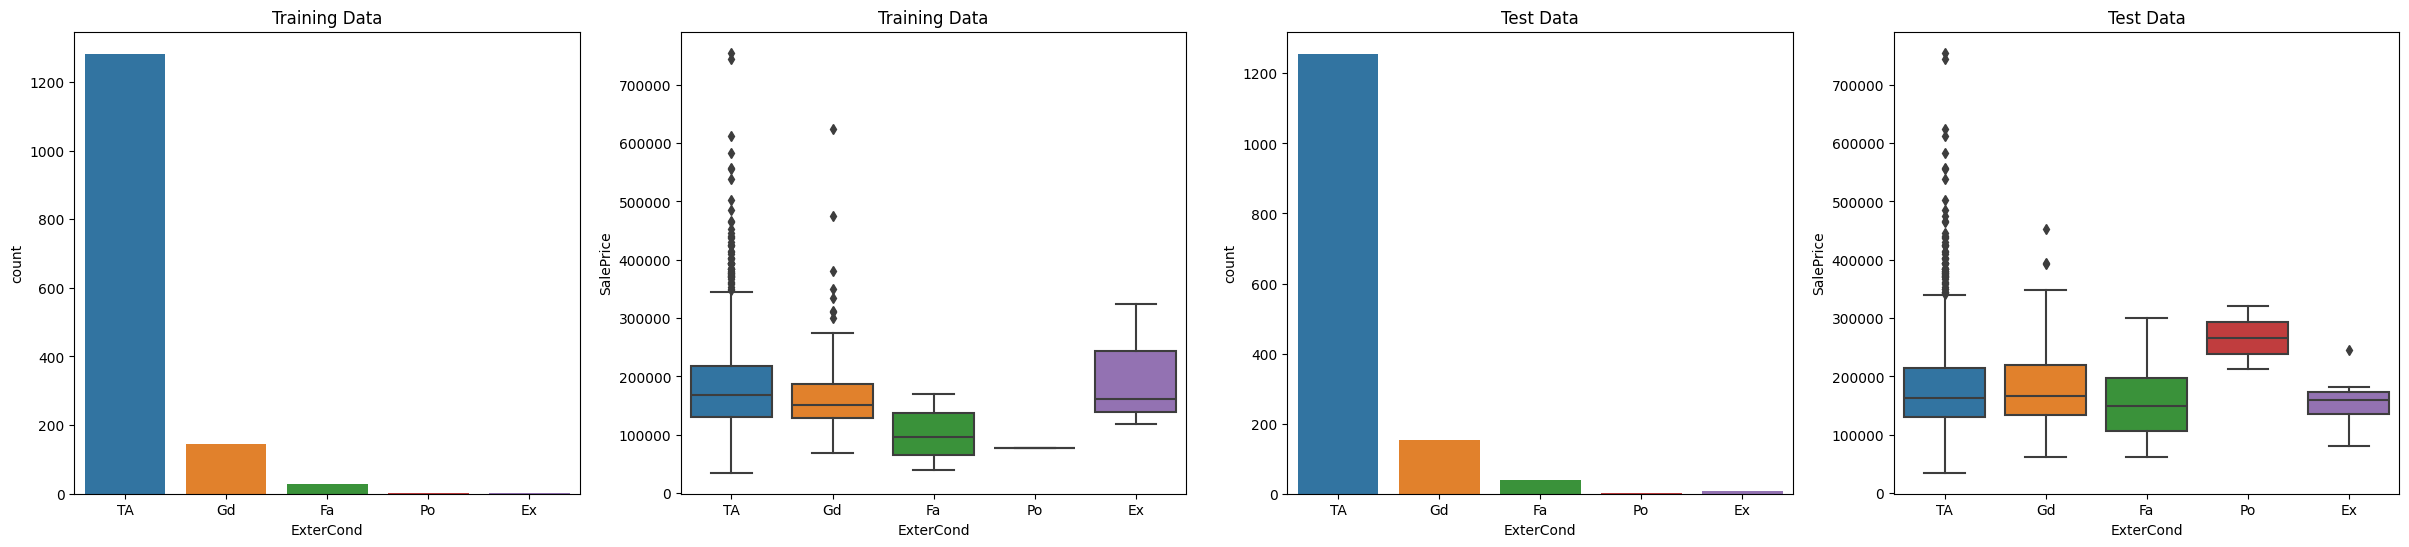

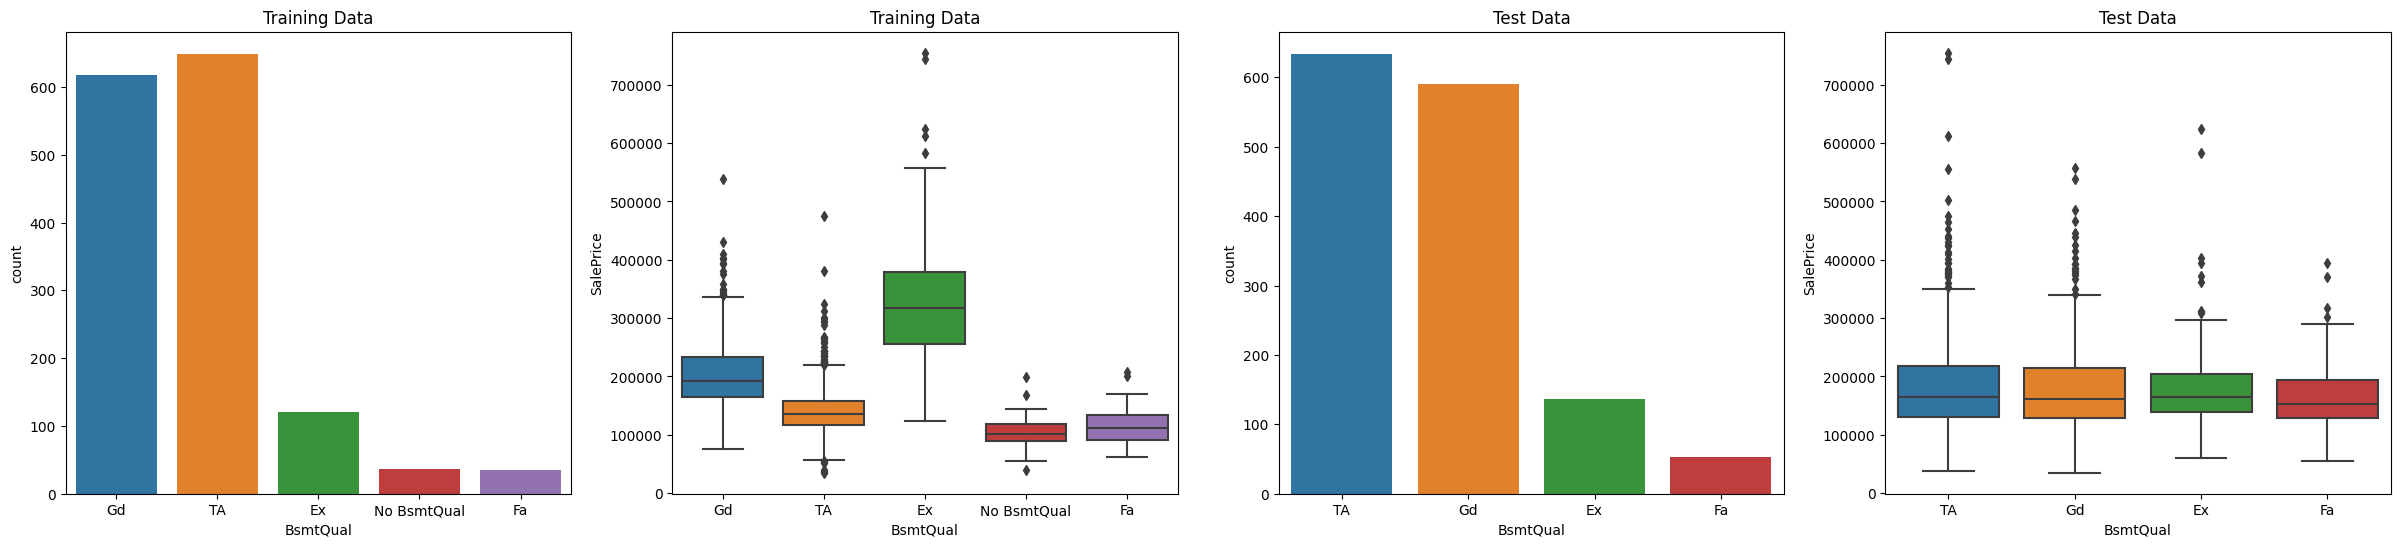

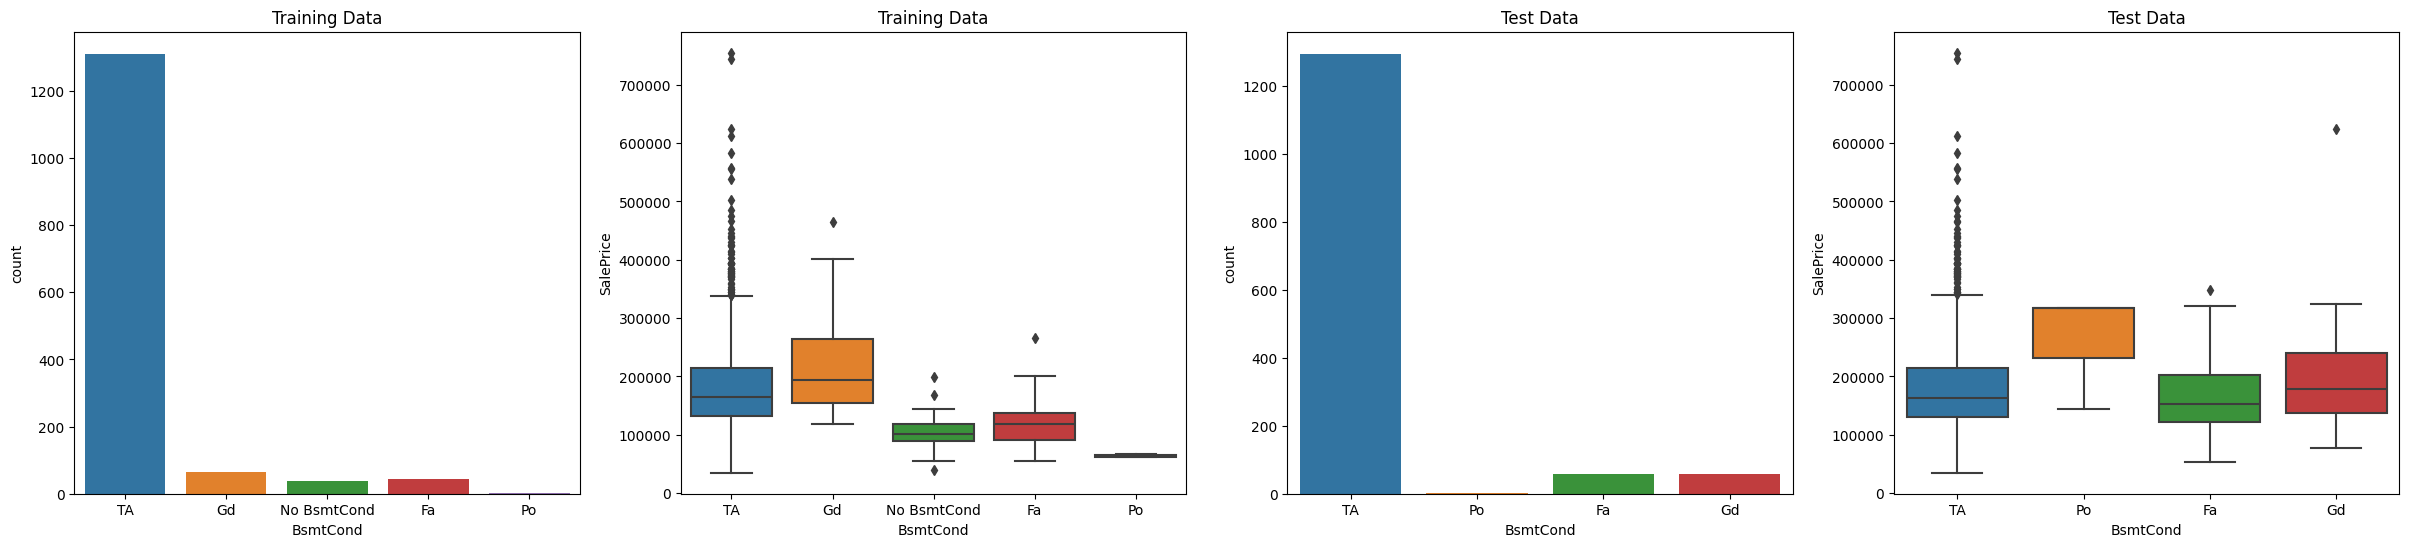

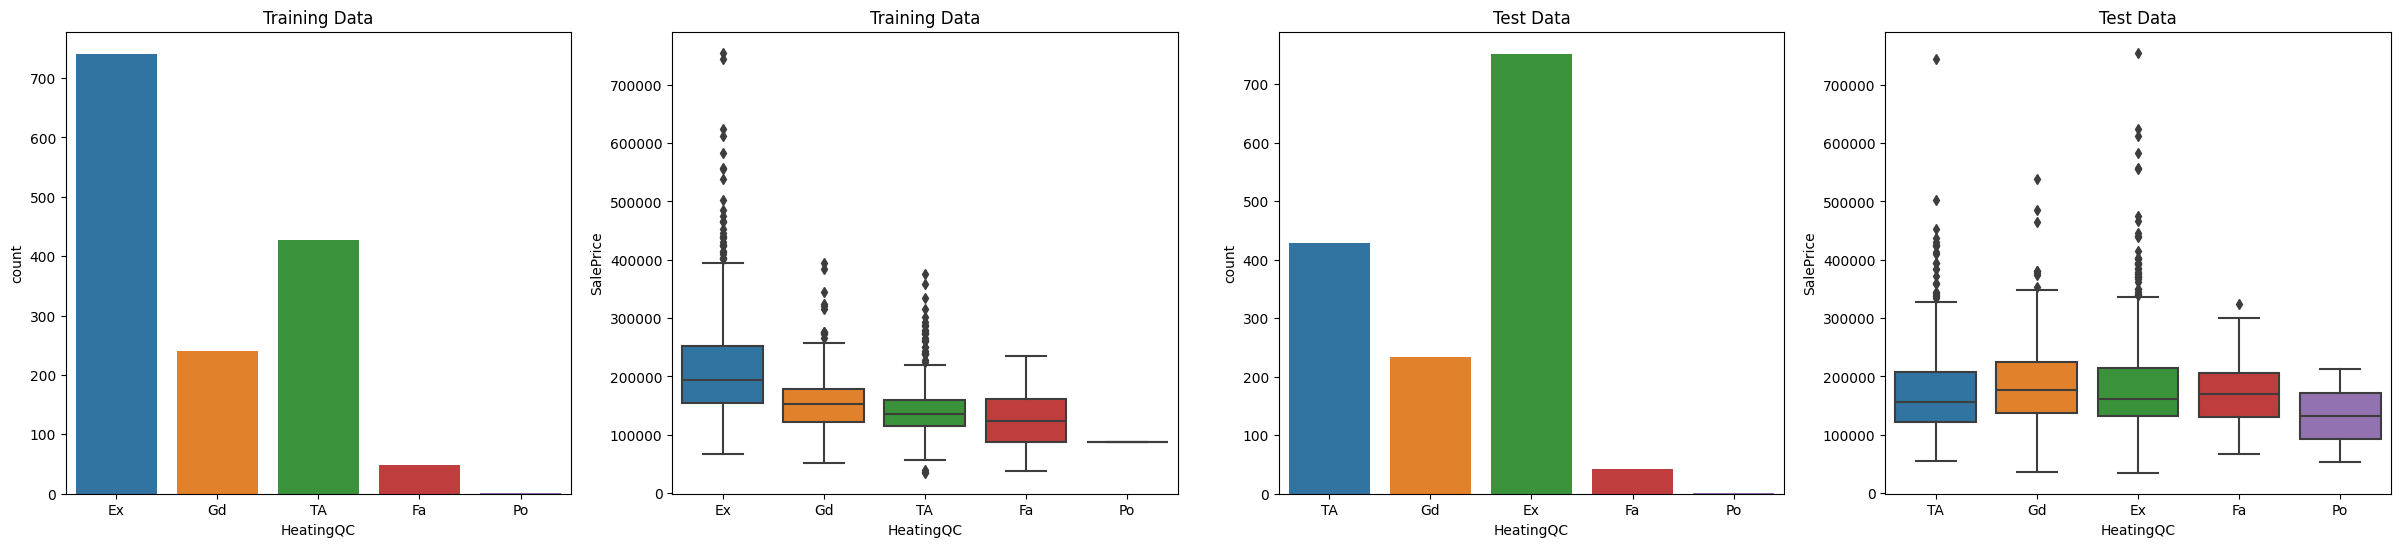

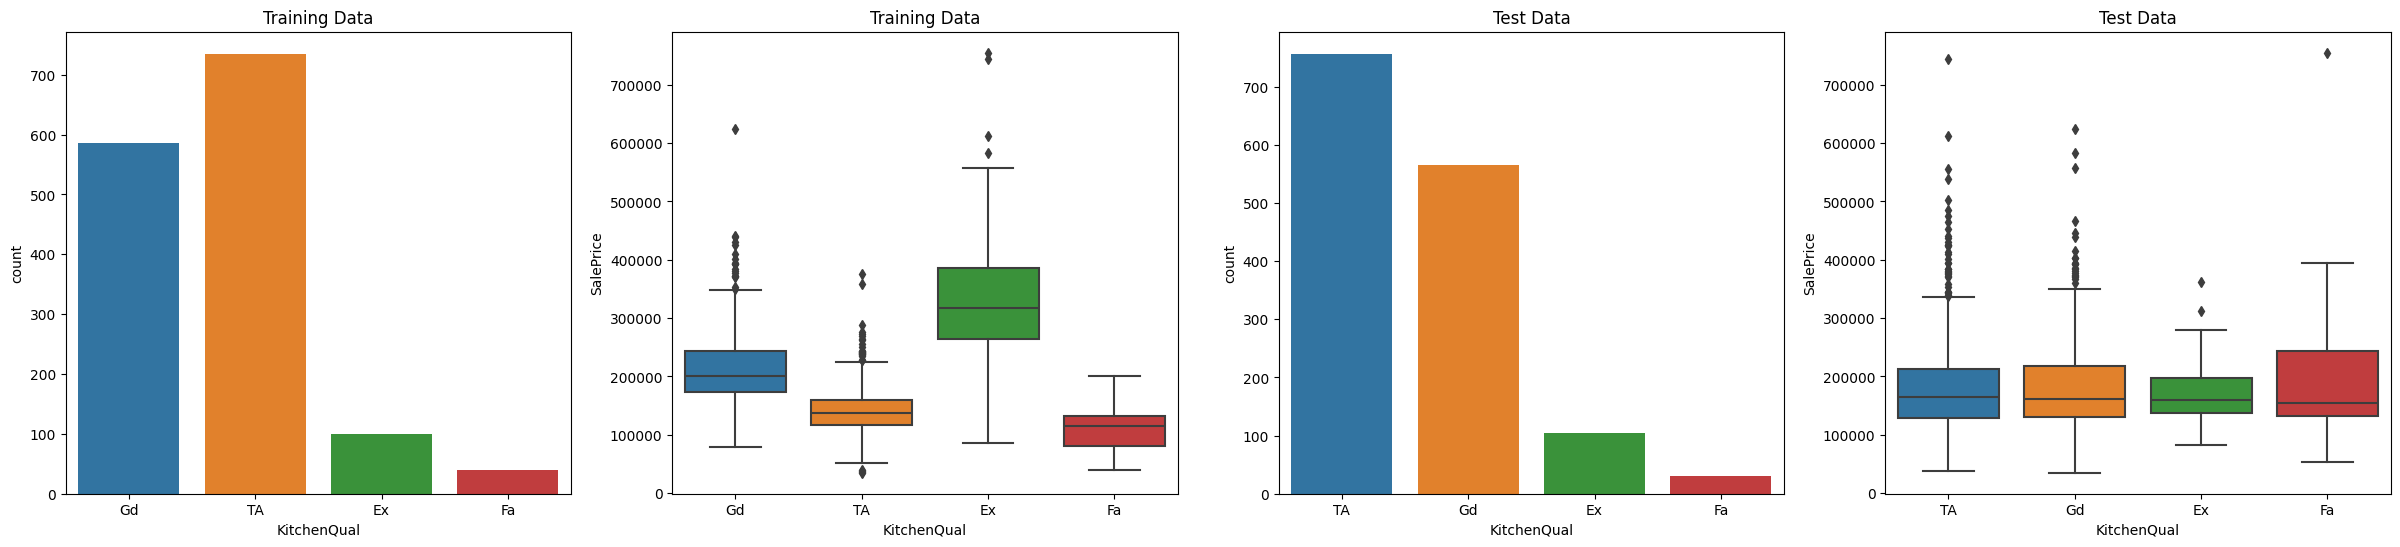

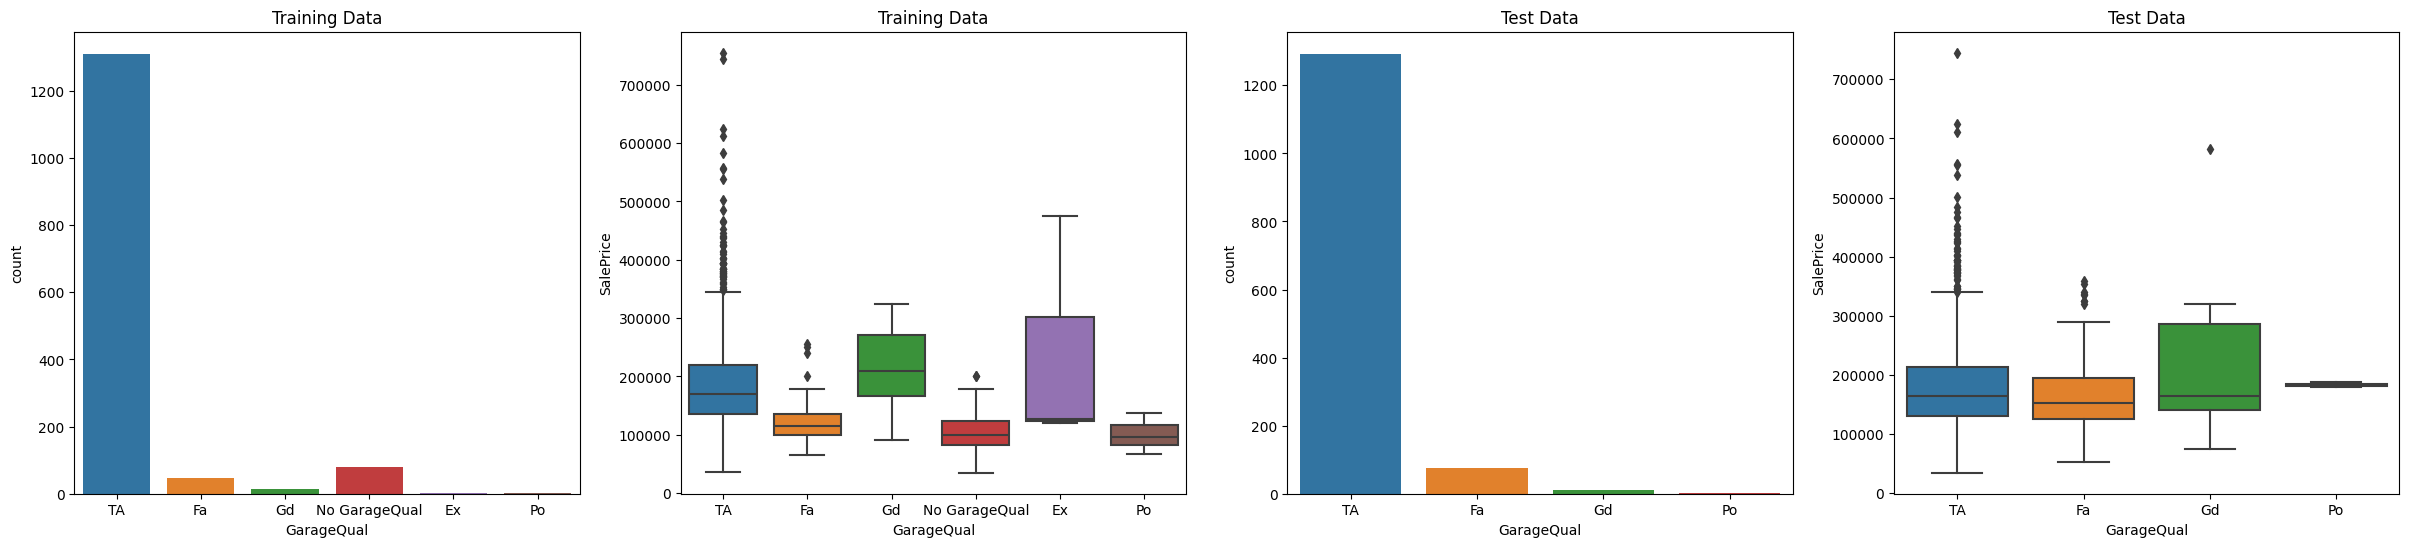

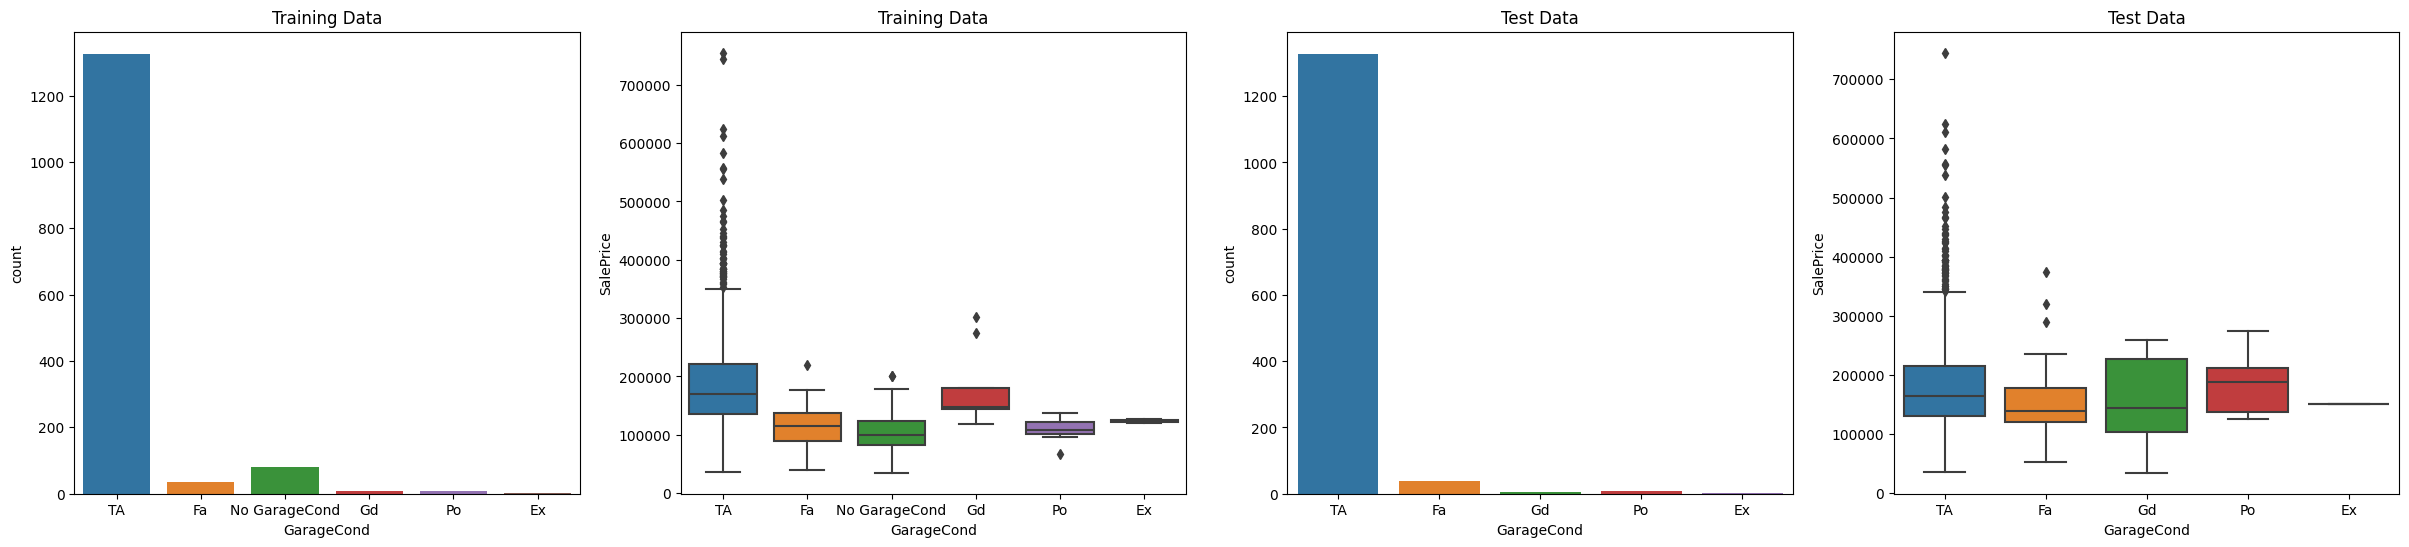

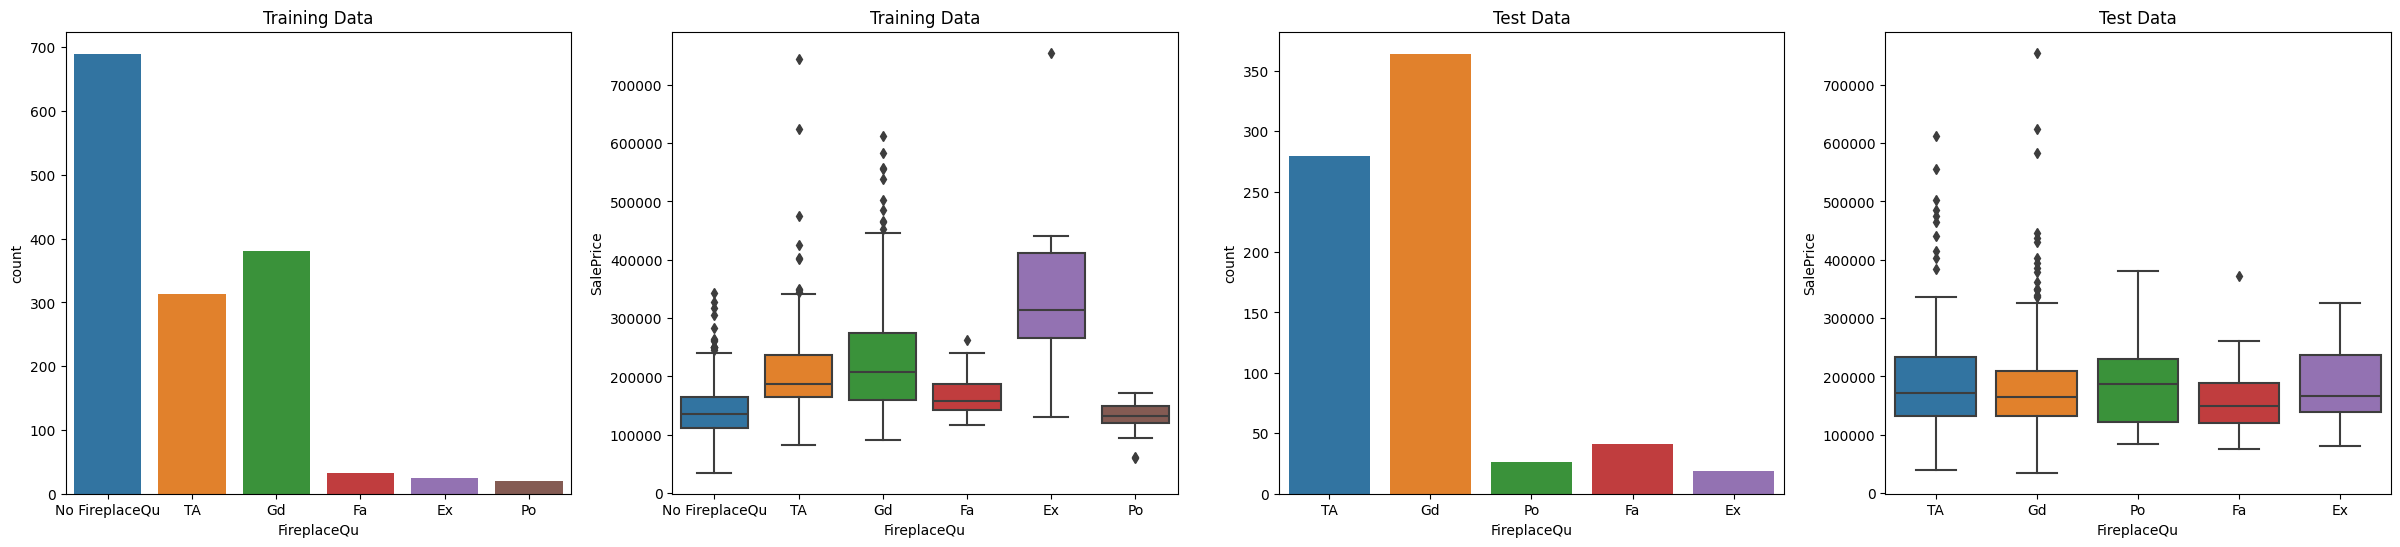

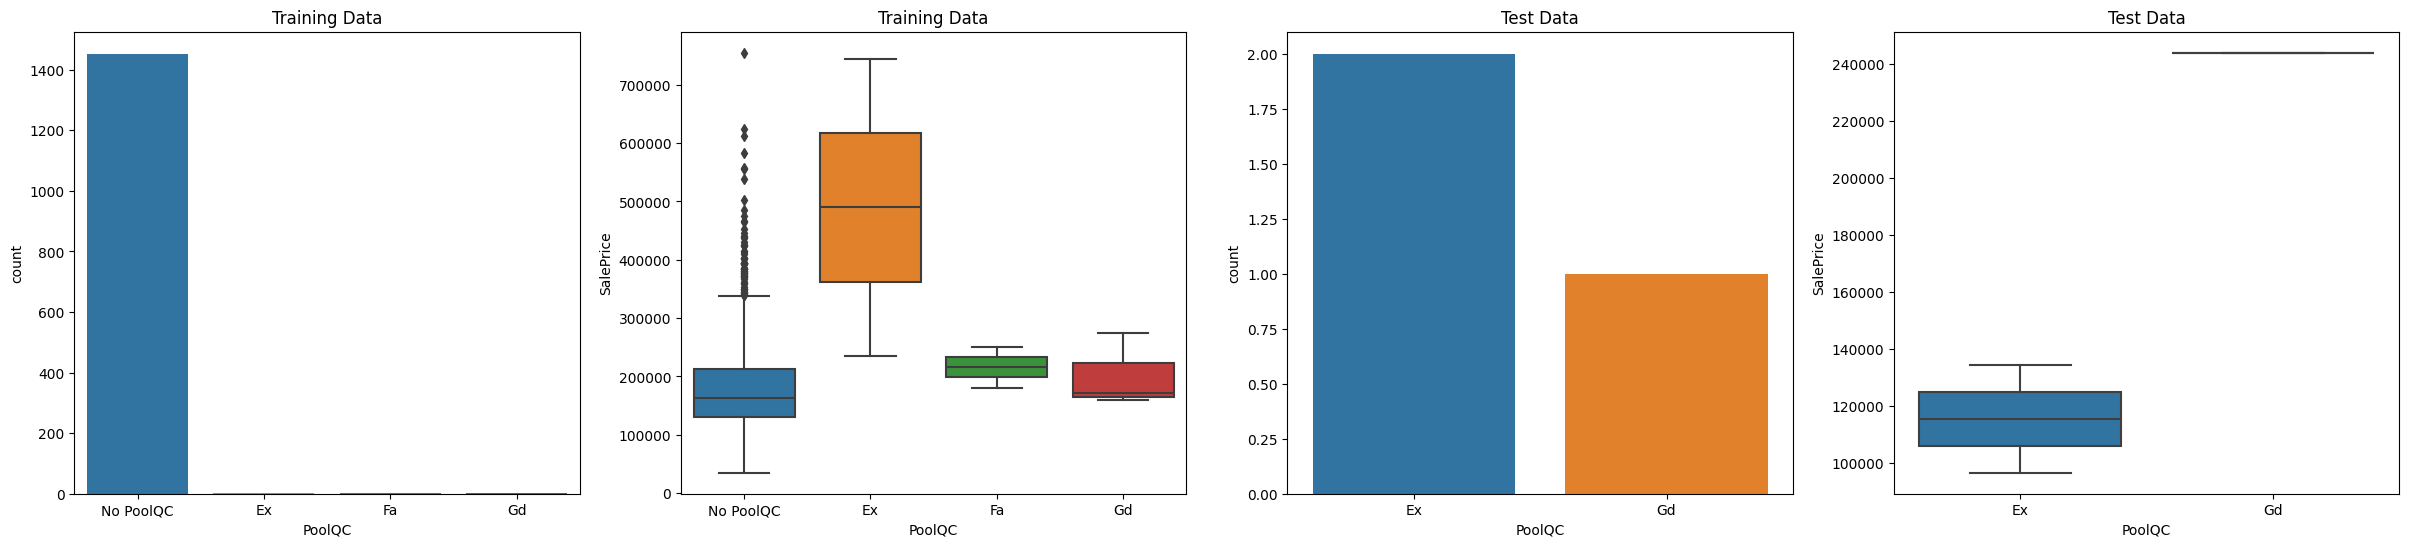

In [37]:
# Visualize all the quality features. For each feature, display a count plot and a box plot of the feature vs the target variable.
# Display the 2 plots for both the training and test data, so 4 plots for each feature in a row.
quality_features = [ 
    'OverallCond', 
    'ExterQual', 
    'ExterCond', 
    'BsmtQual',
    'BsmtCond',
    'HeatingQC', 
    'KitchenQual', 
    'GarageQual',
    'GarageCond', 
    'FireplaceQu', 
    'PoolQC'
    ]

for feature in quality_features:
    fig, axs = plt.subplots(ncols=4, figsize=(30, 6))
    sns.countplot(x=feature, data=df, ax=axs[0])
    axs[0].set_title('Training Data')
    sns.boxplot(x=feature, y=y, data=df, ax=axs[1])
    axs[1].set_title('Training Data')
    sns.countplot(x=feature, data=df_test, ax=axs[2])
    axs[2].set_title('Test Data')
    sns.boxplot(x=feature, y=y, data=df_test, ax=axs[3])
    axs[3].set_title('Test Data')    
    plt.show()

- 'PoolQC' has only 7 values with actual values (the rest are homes with no pools), so we will drop the column.
- We will quantile-bin the rest of the quality features based on their respective distributions.

In [38]:
# Drop the 'PoolQC' feature from the training and test data as well as the list of categorical features and the list of quality features
df = df.drop('PoolQC', axis=1)
df_test = df_test.drop('PoolQC', axis=1)
categorical_features = categorical_features.drop('PoolQC')
quality_features.remove('PoolQC')

In [39]:
# Quantile-bin the 'OverallCond' feature into 4 bins
df['OverallCond_binned'] = pd.qcut(df['OverallCond'], q=6, duplicates='drop', labels=['1', '2', '3', '4'])

# Show the new 'OverallCond' unique values
df['OverallCond_binned'].unique()

['1', '4', '2', '3']
Categories (4, object): ['1' < '2' < '3' < '4']

In [40]:
# Map the 'OverallCond' bins to the categorical values 'poor', 'fair', 'good', and 'excellent' in the training data
df['OverallCond_binned'] = df['OverallCond_binned'].map({'1': 'poor', '2': 'fair', '3': 'good', '4': 'excellent'})

In [41]:
# Create the same 4 bins for the test data based on the cutoff points found in the training data
df_test['OverallCond_binned'] = pd.cut(df_test['OverallCond'], bins=[0, 3, 4, 5, 10], labels=['1', '2', '3', '4'])

# Map the 'OverallCond' bins to the categorical values 'poor', 'fair', 'good', and 'excellent' in the test data
df_test['OverallCond_binned'] = df_test['OverallCond_binned'].map({'1': 'poor', '2': 'fair', '3': 'good', '4': 'excellent'})

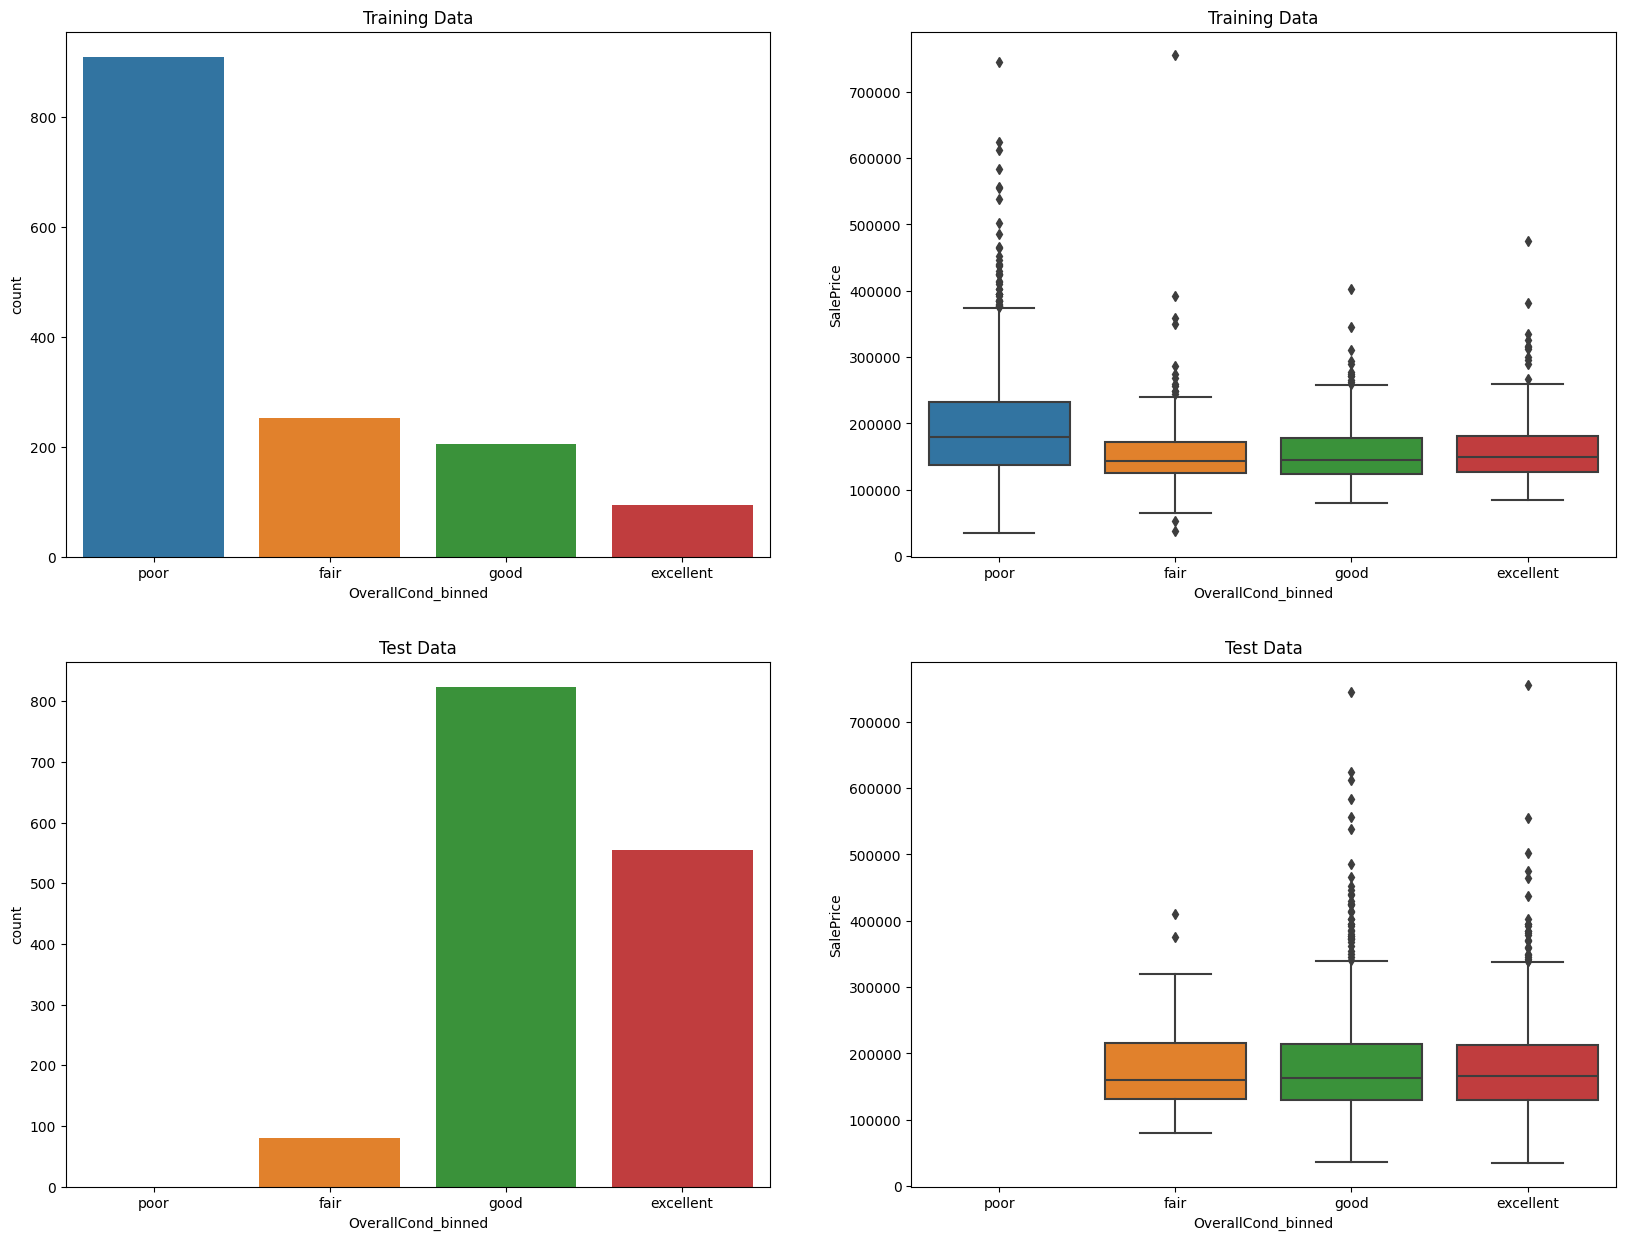

In [42]:
# Visualize the count plot and box plot of the 'OverallCond' feature vs the target variable for the training and test data
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))
sns.countplot(x='OverallCond_binned', data=df, ax=axs[0][0])
axs[0][0].set_title('Training Data')
sns.boxplot(x='OverallCond_binned', y=y, data=df, ax=axs[0][1])
axs[0][1].set_title('Training Data')
sns.countplot(x='OverallCond_binned', data=df_test, ax=axs[1][0])
axs[1][0].set_title('Test Data')
sns.boxplot(x='OverallCond_binned', y=y, data=df_test, ax=axs[1][1])
axs[1][1].set_title('Test Data')
plt.show()

In [43]:
# For the rest of the quality features, convert the features to numerical features by mapping the categorical values to numerical values
quality_features.remove('OverallCond')

# Convert the quality features if possible in the training and test data
df, categorical_features, new_quality_feature_list_train = convert_quality_features(df=df, feature_list=quality_features, categorical_features=categorical_features)
df_test, categorical_features, new_quality_feature_list_test = convert_quality_features(df=df_test, feature_list=quality_features, categorical_features=categorical_features)        

ExterQual_binned: 4
ExterQual binned successfully
ExterCond_binned: 1
Not enough unique values in ExterCond to bin
BsmtQual_binned: 4
BsmtQual binned successfully
BsmtCond_binned: 1
Not enough unique values in BsmtCond to bin
HeatingQC_binned: 5
Error in binning HeatingQC: Bin labels must be one fewer than the number of bin edges
KitchenQual_binned: 4
KitchenQual binned successfully
GarageQual_binned: 1
Not enough unique values in GarageQual to bin
GarageCond_binned: 1
Not enough unique values in GarageCond to bin
FireplaceQu_binned: 5
Error in binning FireplaceQu: Bin labels must be one fewer than the number of bin edges
ExterQual_binned: 4
ExterQual binned successfully
ExterCond_binned: 1
Not enough unique values in ExterCond to bin
BsmtQual_binned: 4
BsmtQual binned successfully
BsmtCond_binned: 1
Not enough unique values in BsmtCond to bin
HeatingQC_binned: 5
Error in binning HeatingQC: Bin labels must be one fewer than the number of bin edges
KitchenQual_binned: 4
KitchenQual binn

In [44]:
# Display number of unique values for each new quality feature
for feature in new_quality_feature_list_train:
    print(f'{feature}: {df[feature].nunique()}')

ExterQual_binned: 3
BsmtQual_binned: 3
KitchenQual_binned: 3


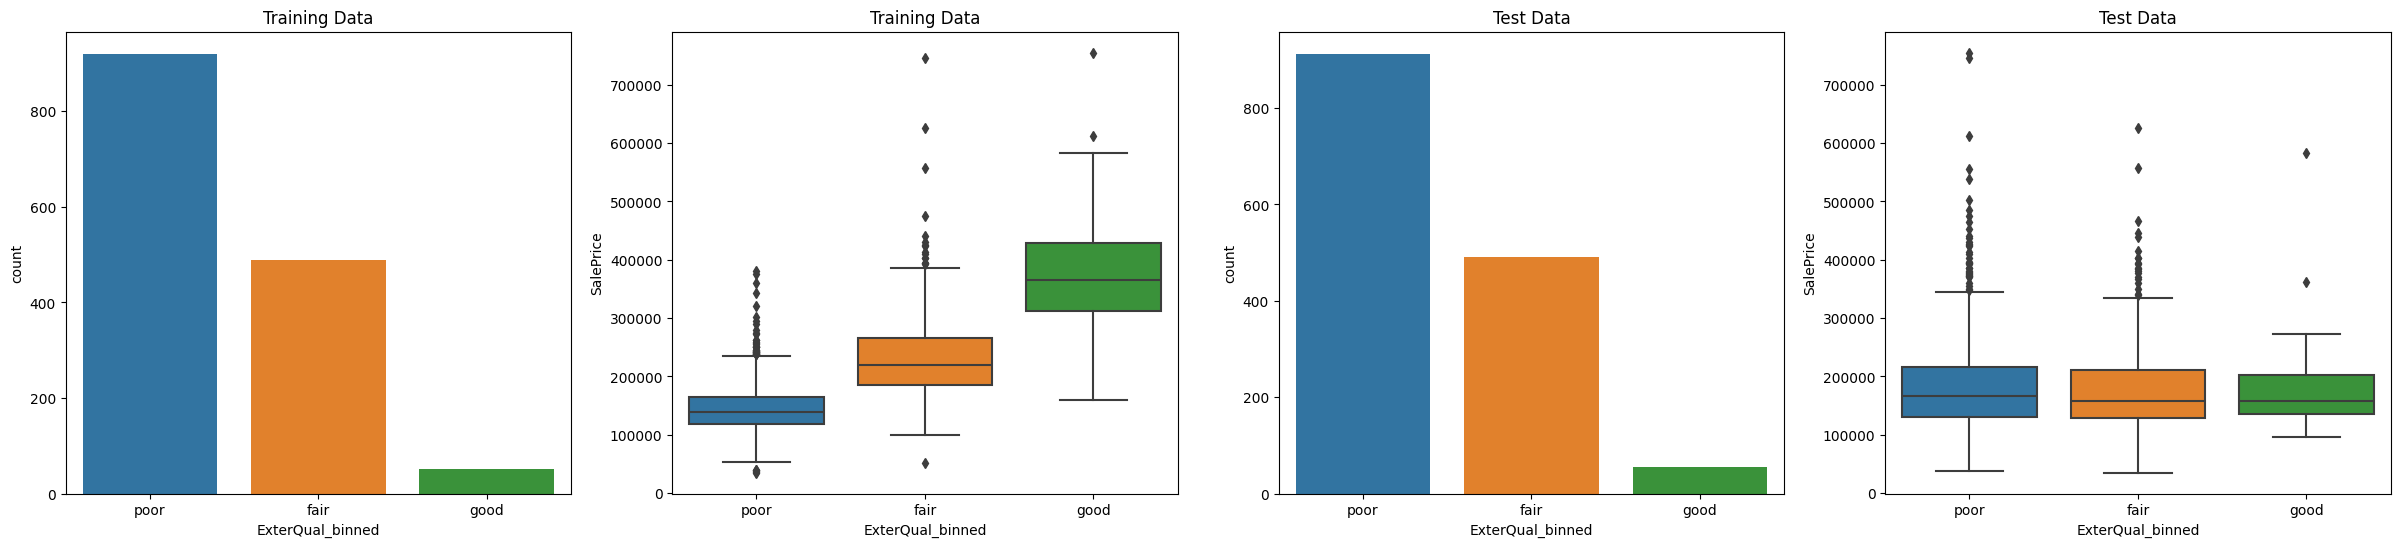

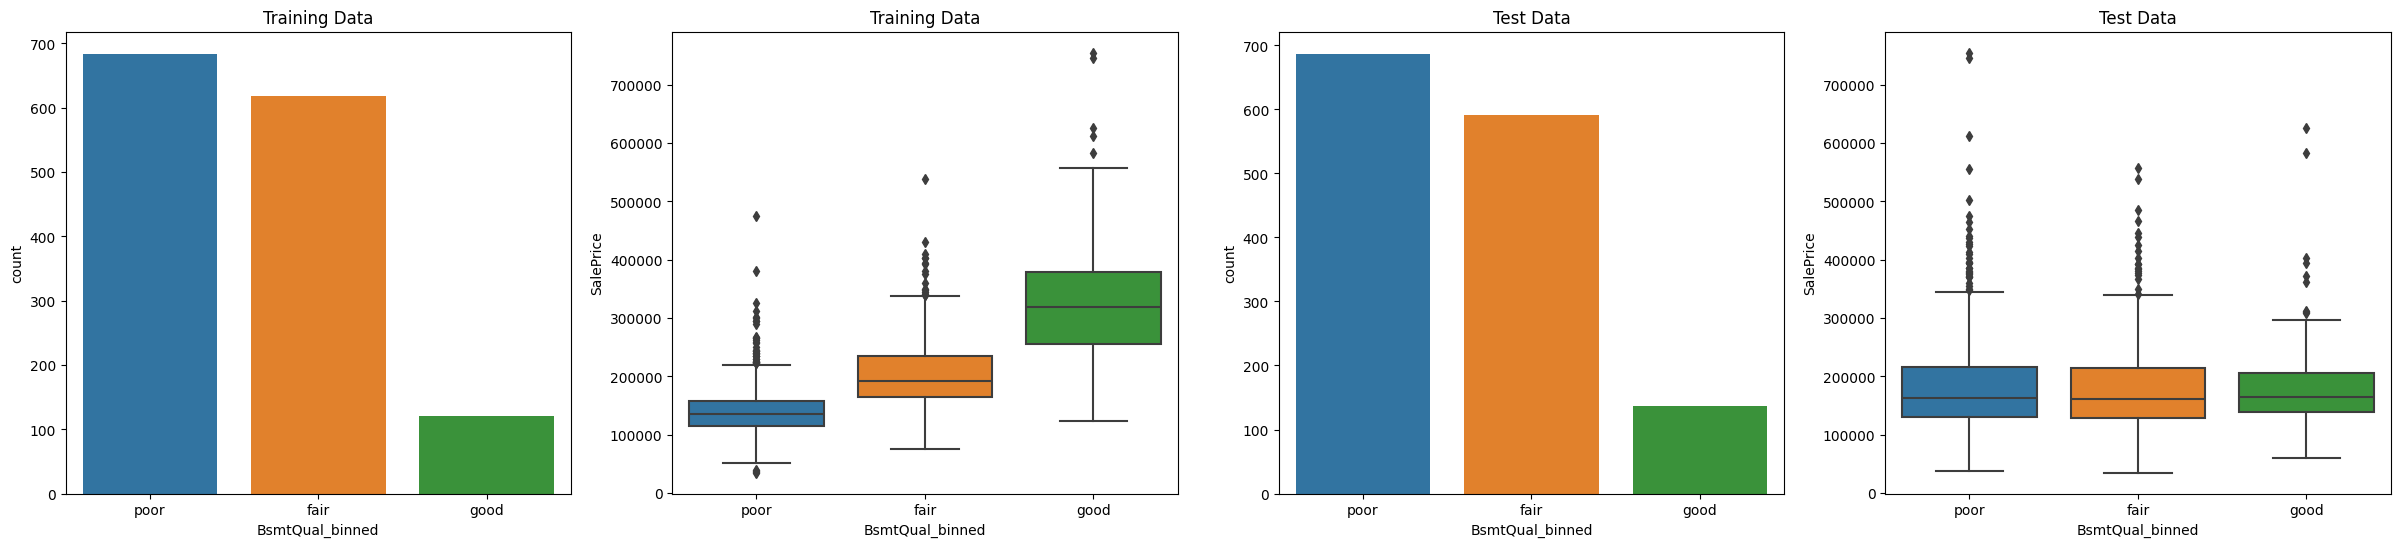

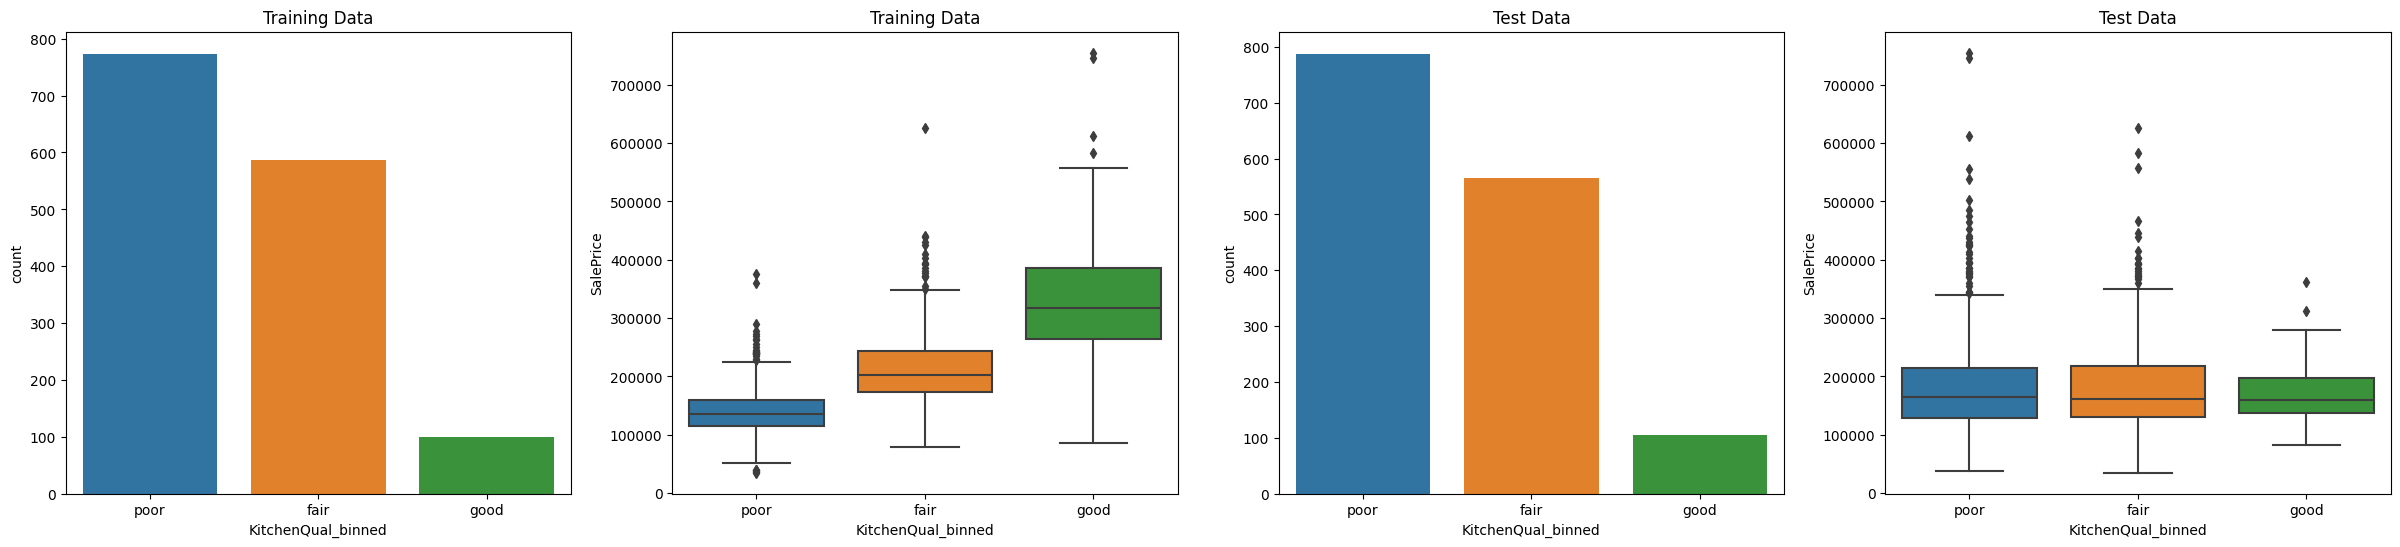

In [45]:
# Visualize the new quality features. For each feature, display a count plot and a box plot of the feature vs the target variable 
# for the training and test data.
# Each row should include 4 plots, 2 for the training data and 2 for the test data:
# 1. Count plot for the training data
# 2. Box plot for the training data
# 3. Count plot for the test data
# 4. Box plot for the test data


for feature in new_quality_feature_list_train:
    fig, axs = plt.subplots(ncols=4, figsize=(30, 6))
    sns.countplot(x=feature, data=df, ax=axs[0])
    axs[0].set_title('Training Data')
    sns.boxplot(x=feature, y=y, data=df, ax=axs[1])
    axs[1].set_title('Training Data')
    sns.countplot(x=feature, data=df_test, ax=axs[2])
    axs[2].set_title('Test Data')
    sns.boxplot(x=feature, y=y, data=df_test, ax=axs[3])
    axs[3].set_title('Test Data')    
    plt.show()

In [46]:
# Convert the 'FireplaceQu' feature by manually binning the values in the training and test data
# If the value is 'no fireplaceQu', convert to 'no fireplace'. Otherwise, convert all values to 'fireplace'
df['FireplaceQu'].value_counts()

FireplaceQu
No FireplaceQu    690
Gd                380
TA                313
Fa                 33
Ex                 24
Po                 20
Name: count, dtype: int64

In [47]:
# Convert the 'FireplaceQu' feature in the training data
df['Have_Fireplace'] = df['FireplaceQu'].map({'No FireplaceQu': 'No Fireplace', 'Po': 'Fireplace', 'Fa': 'Fireplace', 'TA': 'Fireplace', 'Gd': 'Fireplace', 'Ex': 'Fireplace'})

# Convert the 'FireplaceQu' feature in the test data
df_test['Have_Fireplace'] = df_test['FireplaceQu'].map({'No FireplaceQu': 'No Fireplace', 'Po': 'Fireplace', 'Fa': 'Fireplace', 'TA': 'Fireplace', 'Gd': 'Fireplace', 'Ex': 'Fireplace'})

# Drop the 'FireplaceQu' feature from the training and test data as well as the list of categorical features and the list of quality features
df = df.drop('FireplaceQu', axis=1)
df_test = df_test.drop('FireplaceQu', axis=1)
categorical_features = categorical_features.drop('FireplaceQu')
quality_features.remove('FireplaceQu')
categorical_features = categorical_features.append(pd.Index(['Have_Fireplace']))

df['Have_Fireplace'].value_counts()

Have_Fireplace
Fireplace       770
No Fireplace    690
Name: count, dtype: int64

In [48]:
# Remove quality features that could not be binned from the Dataframe and the list of categorical features
df = df.drop(['ExterCond', 'BsmtCond', 'GarageCond', 'GarageQual'], axis=1)
df_test = df_test.drop(['ExterCond', 'BsmtCond', 'GarageCond', 'GarageQual'], axis=1)
categorical_features = categorical_features.drop(['ExterCond', 'BsmtCond', 'GarageCond', 'GarageQual'])

In [49]:
df['HeatingQC'].value_counts()

HeatingQC
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: count, dtype: int64

In [50]:
# Convert the 'HeatingQC' feature in the training and test data into a numerical feature
df['HeatingQC'] = df['HeatingQC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test['HeatingQC'] = df_test['HeatingQC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

# Remove outliers from the 'HeatingQC' feature in the training and test data
outlier_removal(data=df, column='HeatingQC')
remove_outliers_zscore(df=df, column='HeatingQC')
outlier_removal(data=df_test, column='HeatingQC')
remove_outliers_zscore(df=df_test, column='HeatingQC')

# Convert the 'HeatingQC' feature in the training and test data into a categorical feature
df['HeatingQC'] = df['HeatingQC'].map({1: 'Poor', 2: 'Fair', 3: 'Average', 4: 'Good', 5: 'Excellent'})
df_test['HeatingQC'] = df_test['HeatingQC'].map({1: 'Poor', 2: 'Fair', 3: 'Average', 4: 'Good', 5: 'Excellent'})

# Add the new feature to the list of categorical features
categorical_features = categorical_features.append(pd.Index(['HeatingQC']))

## Part 2: Baseline Model Creation and Evaluation
- Baseline Model: Construct a baseline model using the Random Forest algorithm and the features engineered in Part 1.
- Evaluation:
    - Perform k-fold cross-validation.
    - Use default scoring and negative mean squared error metrics.
- Task: Plot and analyze the feature importance graph to understand the impact of each feature.


In [51]:
# Move suspected categorical features from the numerical list to the categorical
suspected_categorical = [
    'MSSubClass',
    'MoSold',
    'YrSold',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'PoolArea',
    'MiscVal',
    'OverallQual',
    'OverallCond'
]

In [52]:
# Remove target from base DataFrame
X = df.drop('SalePrice', axis=1)

# Drop columns with more than 50% missing values
X = X.drop(['Alley', 'Fence', 'MiscFeature', 'MasVnrType'], axis=1)
df_test = df_test.drop(['Alley', 'Fence', 'MiscFeature', 'MasVnrType'], axis=1)

# Remove dropped columns from categorical features
categorical_features = categorical_features.drop(['Alley', 'Fence', 'MiscFeature', 'MasVnrType'])

In [53]:
# Remove duplicate feature names in the list of categorical features
categorical_features = categorical_features.drop_duplicates()

# Remove duplicate feature names in the list of numerical features
numerical_features = numerical_features.drop_duplicates()

In [54]:
# Check if there features that occur in both the numerical and categorical features lists
for feature in numerical_features:
    if feature in categorical_features:
        print(feature)

In [55]:
# Build the data pipeline
rf_pipeline_base = build_pipeline(numerical_columns=numerical_features, categorical_columns=categorical_features)

# Fit the pipeline
rf_pipeline_base.fit(X, y)

# Access the transformed dataframe
# Access the preprocessor
preprocessor = rf_pipeline_base.named_steps['preprocessor']

# Access the column transformer
column_transformer = preprocessor.named_transformers_['cat']

# Access the one hot encoder
one_hot = column_transformer.named_steps['onehot']

# Get the feature names from the one hot encoder
cat_one_hot_features = one_hot.get_feature_names_out(categorical_features)

# Create a DataFrame of the transformed data
processed_df = pd.DataFrame(
    data=preprocessor.transform(X),
    columns=(list(numerical_features) + list(cat_one_hot_features))
)

# Remove duplicate features from the transformed dataframe
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features)

transformed_X = duplicate_feature_remover.transform(processed_df)

# Refit the model from the pipeline on the transformed dataframe
rf_model_base = rf_pipeline_base.named_steps['model']

rf_model_base.fit(transformed_X, y)

# Cross validation
current_scores = cross_validate_estimator(estimator=rf_model_base, X=transformed_X, y=y, cv=5)

scores['Base RF model'] = current_scores

Cross-validation scores: [0.86612343 0.85379026 0.87279047 0.88493229 0.828898  ], scores average: 0.8613068916039841, std: 0.01907913634793958

MSE Cross-validation scores: [7.40689506e+08 9.60695913e+08 9.63968111e+08 5.82916299e+08
 1.14730213e+09], scores average: 879114391.3966099, std: 196303397.34549168

Log RMSE Cross-validation scores: [0.13956633 0.15425233 0.14489083 0.13586364 0.15247203], scores average: 0.1454090307600067, std: 0.007121937270130721


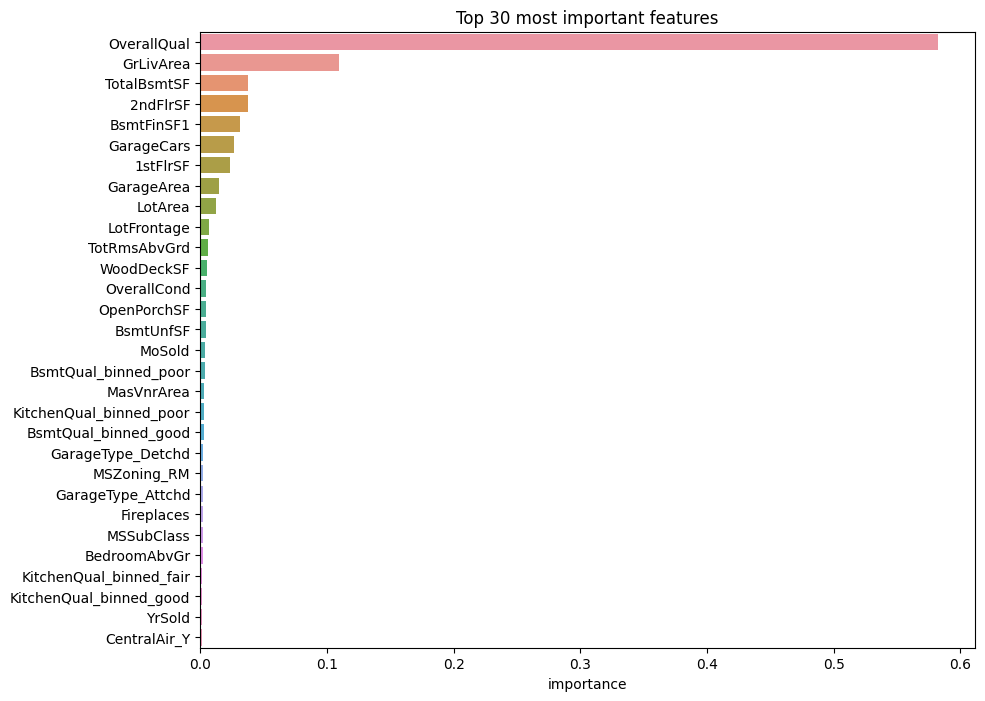

In [56]:
display_feature_importance(
    rf_model_base,
    feature_names=transformed_X.columns,
    n=30
)

### Quality features revisited:

We will choose the strongest quality features + 'Neighborhood' and 'MSSubClass' to create new "Tier" features.

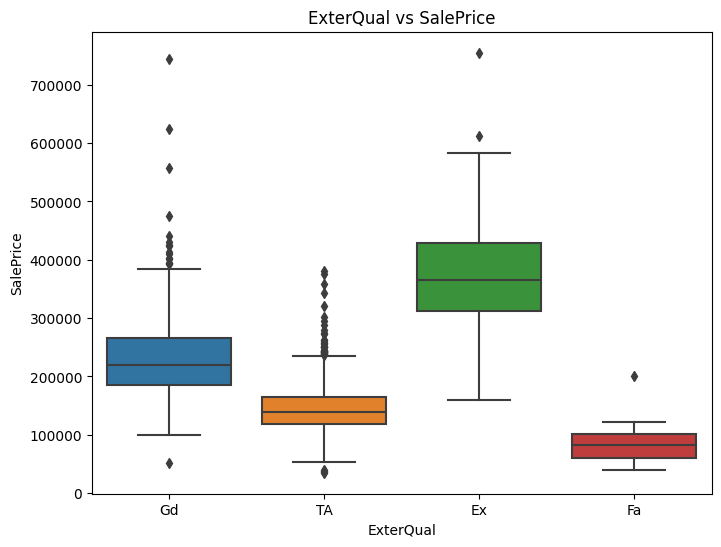

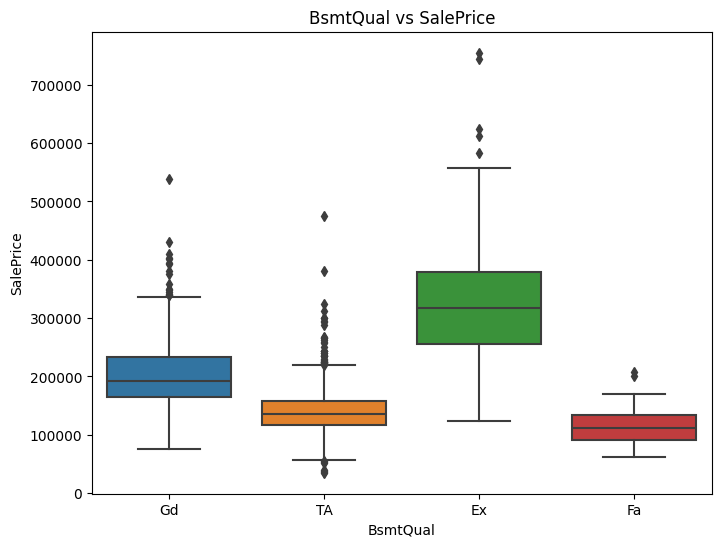

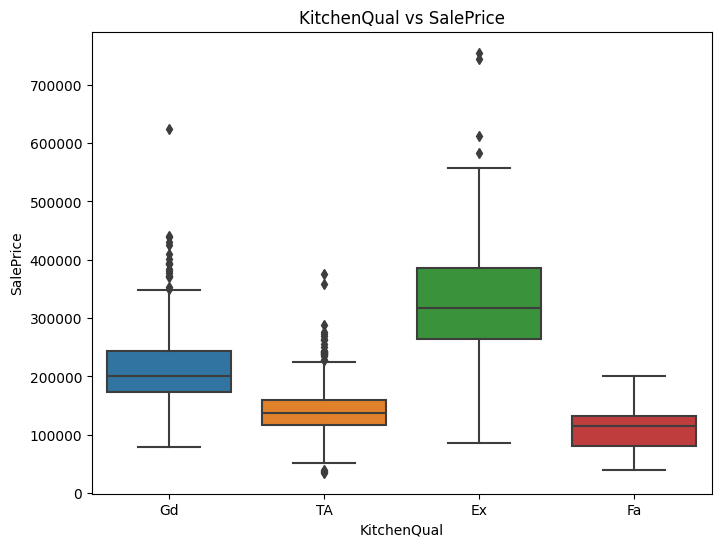

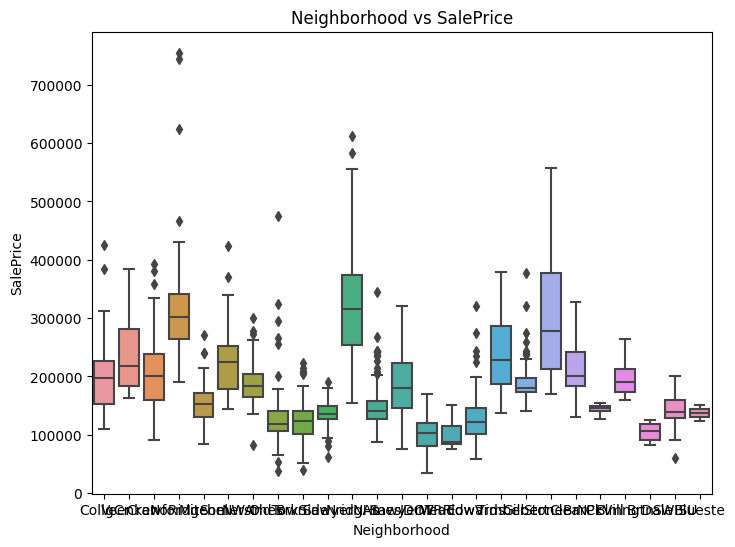

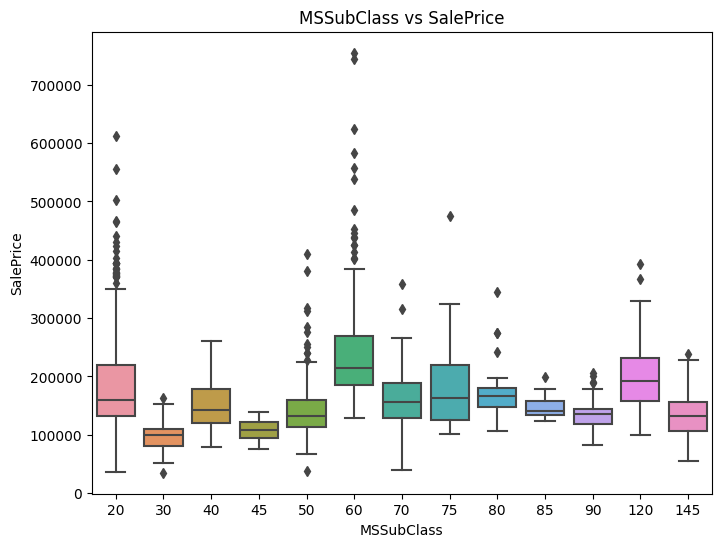

In [57]:
strong_cat_features = ['ExterQual', 'BsmtQual','KitchenQual', 'Neighborhood', 'MSSubClass']

# Reclaim the original features from the original dataframes
df[['ExterQual', 'BsmtQual','KitchenQual']] = df_orig[['ExterQual', 'BsmtQual','KitchenQual']]
df_test[['ExterQual', 'BsmtQual','KitchenQual']] = df_test_orig[['ExterQual', 'BsmtQual','KitchenQual']]

# Delete the 'ExterQual_binned', 'BsmtQual_binned','KitchenQual_binned'
df = df.drop(['ExterQual_binned', 'BsmtQual_binned','KitchenQual_binned'], axis=1)
df_test = df_test.drop(['ExterQual_binned', 'BsmtQual_binned','KitchenQual_binned'], axis=1)

for feature in strong_cat_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=feature, y=y, data=df)
    plt.title(f'{feature} vs SalePrice')
    plt.show()

In [58]:
# Creating the "Tier" features based on their relationship with the target variable

X['Neighborhood_tier'] = 0  
X.loc[df['Neighborhood'] == 'MeadowV', 'Neighborhood_tier'] = 1
X.loc[df['Neighborhood'].isin(['IDOTRR', 'BrDale']), 'Neighborhood_tier'] = 2
X.loc[df['Neighborhood'].isin(['OldTown', 'Edwards', 'BrkSide']), 'Neighborhood_tier'] = 3
X.loc[df['Neighborhood'].isin(['Sawyer', 'Blueste', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel']), 'Neighborhood_tier'] = 4
X.loc[df['Neighborhood'].isin(['SawyerW', 'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor']), 'Neighborhood_tier'] = 5
X.loc[df['Neighborhood'].isin(['Veenker', 'Somerst', 'Timber']), 'Neighborhood_tier'] = 6
X.loc[df['Neighborhood'].isin(['StoneBr', 'NoRidge', 'NridgHt']), 'Neighborhood_tier'] = 7

# Duplicate in the test data
df_test['Neighborhood_tier'] = 0
df_test.loc[df_test['Neighborhood'] == 'MeadowV', 'Neighborhood_tier'] = 1
df_test.loc[df_test['Neighborhood'].isin(['IDOTRR', 'BrDale']), 'Neighborhood_tier'] = 2
df_test.loc[df_test['Neighborhood'].isin(['OldTown', 'Edwards', 'BrkSide']), 'Neighborhood_tier'] = 3
df_test.loc[df_test['Neighborhood'].isin(['Sawyer', 'Blueste', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel']), 'Neighborhood_tier'] = 4
df_test.loc[df_test['Neighborhood'].isin(['SawyerW', 'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor']), 'Neighborhood_tier'] = 5
df_test.loc[df_test['Neighborhood'].isin(['Veenker', 'Somerst', 'Timber']), 'Neighborhood_tier'] = 6
df_test.loc[df_test['Neighborhood'].isin(['StoneBr', 'NoRidge', 'NridgHt']), 'Neighborhood_tier'] = 7

X['MSSubClass_tier'] = 0  
X.loc[df['MSSubClass'].isin([180, 30, 45]), 'MSSubClass_tier'] = 1
X.loc[df['MSSubClass'].isin([190, 50, 90]), 'MSSubClass_tier'] = 2
X.loc[df['MSSubClass'].isin([85, 40, 160]), 'MSSubClass_tier'] = 3
X.loc[df['MSSubClass'].isin([70, 80]), 'MSSubClass_tier'] = 4
X.loc[df['MSSubClass'].isin([20, 75]), 'MSSubClass_tier'] = 5
X.loc[df['MSSubClass'].isin([120, 60]), 'MSSubClass_tier'] = 6

# Duplicate in the test data
df_test['MSSubClass_tier'] = 0
df_test.loc[df_test['MSSubClass'].isin([180, 30, 45]), 'MSSubClass_tier'] = 1
df_test.loc[df_test['MSSubClass'].isin([190, 50, 90]), 'MSSubClass_tier'] = 2
df_test.loc[df_test['MSSubClass'].isin([85, 40, 160]), 'MSSubClass_tier'] = 3
df_test.loc[df_test['MSSubClass'].isin([70, 80]), 'MSSubClass_tier'] = 4
df_test.loc[df_test['MSSubClass'].isin([20, 75]), 'MSSubClass_tier'] = 5

X['ExterQual_tier'] = 0  
X.loc[df['ExterQual'] == 'Ex', 'ExterQual_tier'] = 2
X.loc[df['ExterQual'] == 'Gd', 'ExterQual_tier'] = 1
X.loc[df['ExterQual'] == 'Fa', 'ExterQual_tier'] = -1
X.loc[df['ExterQual'] == 'Po', 'ExterQual_tier'] = -2

# Remove outliers from the 'ExterQual_tier' feature in the training data
outlier_removal(data=X, column='ExterQual_tier')
remove_outliers_zscore(df=X, column='ExterQual_tier')

# Duplicate in the test data
df_test['ExterQual_tier'] = 0
df_test.loc[df_test['ExterQual'] == 'Ex', 'ExterQual_tier'] = 2
df_test.loc[df_test['ExterQual'] == 'Gd', 'ExterQual_tier'] = 1
df_test.loc[df_test['ExterQual'] == 'Fa', 'ExterQual_tier'] = -1
df_test.loc[df_test['ExterQual'] == 'Po', 'ExterQual_tier'] = -2

# Remove outliers from the 'ExterQual_tier' feature in the test data
outlier_removal(data=df_test, column='ExterQual_tier')
remove_outliers_zscore(df=df_test, column='ExterQual_tier')

X['BsmtQual_tier'] = 0  
X.loc[df['BsmtQual'] == 'Ex', 'BsmtQual_tier'] = 2
X.loc[df['BsmtQual'] == 'Gd', 'BsmtQual_tier'] = 1
X.loc[df['BsmtQual'] == 'Fa', 'BsmtQual_tier'] = -1
X.loc[df['BsmtQual'] == 'Po', 'BsmtQual_tier'] = -2

# Remove outliers from the 'BsmtQual_tier' feature in the training data
outlier_removal(data=X, column='BsmtQual_tier')
remove_outliers_zscore(df=X, column='BsmtQual_tier')

# Duplicate in the test data
df_test['BsmtQual_tier'] = 0
df_test.loc[df_test['BsmtQual'] == 'Ex', 'BsmtQual_tier'] = 2
df_test.loc[df_test['BsmtQual'] == 'Gd', 'BsmtQual_tier'] = 1
df_test.loc[df_test['BsmtQual'] == 'Fa', 'BsmtQual_tier'] = -1
df_test.loc[df_test['BsmtQual'] == 'Po', 'BsmtQual_tier'] = -2

# Remove outliers from the 'BsmtQual_tier' feature in the test data
outlier_removal(data=df_test, column='BsmtQual_tier')
remove_outliers_zscore(df=df_test, column='BsmtQual_tier')

X['KitchenQual_tier'] = 0  
X.loc[df['KitchenQual'] == 'Ex', 'KitchenQual_tier'] = 2
X.loc[df['KitchenQual'] == 'Gd', 'KitchenQual_tier'] = 1
X.loc[df['KitchenQual'] == 'Fa', 'KitchenQual_tier'] = -1
X.loc[df['KitchenQual'] == 'Po', 'KitchenQual_tier'] = -2

# Remove outliers from the 'KitchenQual_tier' feature in the training data
outlier_removal(data=X, column='KitchenQual_tier')
remove_outliers_zscore(df=X, column='KitchenQual_tier')

# Duplicate in the test data
df_test['KitchenQual_tier'] = 0
df_test.loc[df_test['KitchenQual'] == 'Ex', 'KitchenQual_tier'] = 2
df_test.loc[df_test['KitchenQual'] == 'Gd', 'KitchenQual_tier'] = 1
df_test.loc[df_test['KitchenQual'] == 'Fa', 'KitchenQual_tier'] = -1
df_test.loc[df_test['KitchenQual'] == 'Po', 'KitchenQual_tier'] = -2

# Remove outliers from the 'KitchenQual_tier' feature in the test data
remove_outliers_zscore(df=df_test, column='KitchenQual_tier')
outlier_removal(data=df_test, column='KitchenQual_tier')

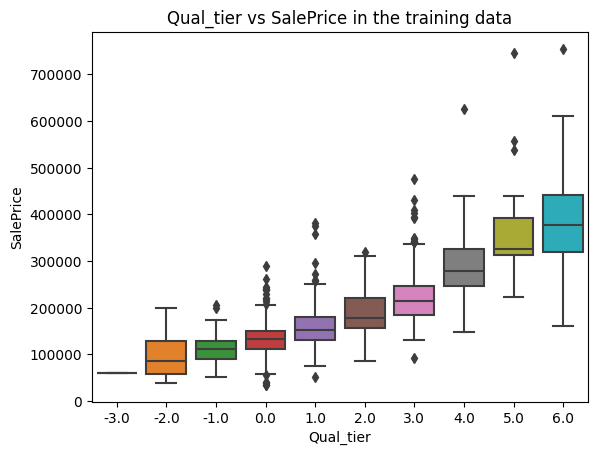

In [59]:
X['Qual_tier'] = X['KitchenQual_tier'] + X['BsmtQual_tier'] + X['ExterQual_tier']

# Remove outliers from the 'Qual_tier' feature in the training data
remove_outliers_zscore(df=X, column='Qual_tier')
outlier_removal(data=X, column='Qual_tier')

# Duplicate in the test data
df_test['Qual_tier'] = df_test['KitchenQual_tier'] + df_test['BsmtQual_tier'] + df_test['ExterQual_tier']

# Remove outliers from the 'Qual_tier' feature in the test data
remove_outliers_zscore(df=df_test, column='Qual_tier')
outlier_removal(data=df_test, column='Qual_tier')

plt.title('Qual_tier vs SalePrice in the training data')
sns.boxplot(x=X['Qual_tier'],y=y)
plt.show()

In [60]:
# Add the new features to the list of numerical features
numerical_features = numerical_features.append(pd.Index([
    'Neighborhood_tier', 'MSSubClass_tier', 'Qual_tier', 'ExterQual_tier', 'BsmtQual_tier', 'KitchenQual_tier'
    ]))

# Remove original features from the list of categorical features, numerical features, and the training and test data
df_test = df_test.drop(['Neighborhood', 'MSSubClass', 'ExterQual', 'BsmtQual', 'KitchenQual'], axis=1)

for feature in strong_cat_features:
    if feature in categorical_features:
        categorical_features = categorical_features.drop(feature)
    elif feature in numerical_features:
        numerical_features = numerical_features.drop(feature)

In [61]:
categorical_features = categorical_features.drop(['ExterQual_binned', 'BsmtQual_binned', 'KitchenQual_binned'])

## Part 3: Categorical Feature Transformation and Analysis
- Feature Transformation:
    - Convert 'OverallQual' and 'GarageCars' into categorical features.
    - Analyze how this transformation affects feature importance.
- Sale Price Estimation:
    - Calculate the mean SalePrice per GrLivArea.
    - Create a new column estimating the apartment price (GrLivArea * mean SalePrice).
- Prediction and Kaggle Submission:
    - Predict prices on the test dataset using the new features.
    - Submit to Kaggle and document the score received.


In [62]:
# Convert 'OverallQual' and 'GarageCars' to categorical features
numerical_features_1, categorical_features_1 = convert_to_categorical(
    df=X,
    columns=['OverallQual', 'GarageCars'],
    num_features=numerical_features,
    cat_features=categorical_features
)

In [63]:
# Calculate the mean SalePrice per GrLivArea
mean_SalePrice_per_GrLivArea = y.sum() / X['GrLivArea'].sum()

# Create a new feature of estimated SalePrice
X['estimated_SalePrice'] = X['GrLivArea'] * mean_SalePrice_per_GrLivArea

df_test_2 = df_test.copy()

df_test_2['estimated_SalePrice'] = df_test['GrLivArea'] * mean_SalePrice_per_GrLivArea

# Add the new feature to the numerical feature index
numerical_features_1 = numerical_features_1.append(pd.Index(['estimated_SalePrice']))


Cross-validation scores: [0.89533577 0.82705628 0.89231954 0.89913127 0.86785183], scores average: 0.8763389390875339, std: 0.026968726467636452

MSE Cross-validation scores: [5.79068420e+08 1.13635606e+09 8.15980790e+08 5.10986332e+08
 8.86102329e+08], scores average: 785698785.4757545, std: 224553527.17670414

Log RMSE Cross-validation scores: [0.12805984 0.16253853 0.13810877 0.13452936 0.1409499 ], scores average: 0.14083728267621579, std: 0.011674367509991294


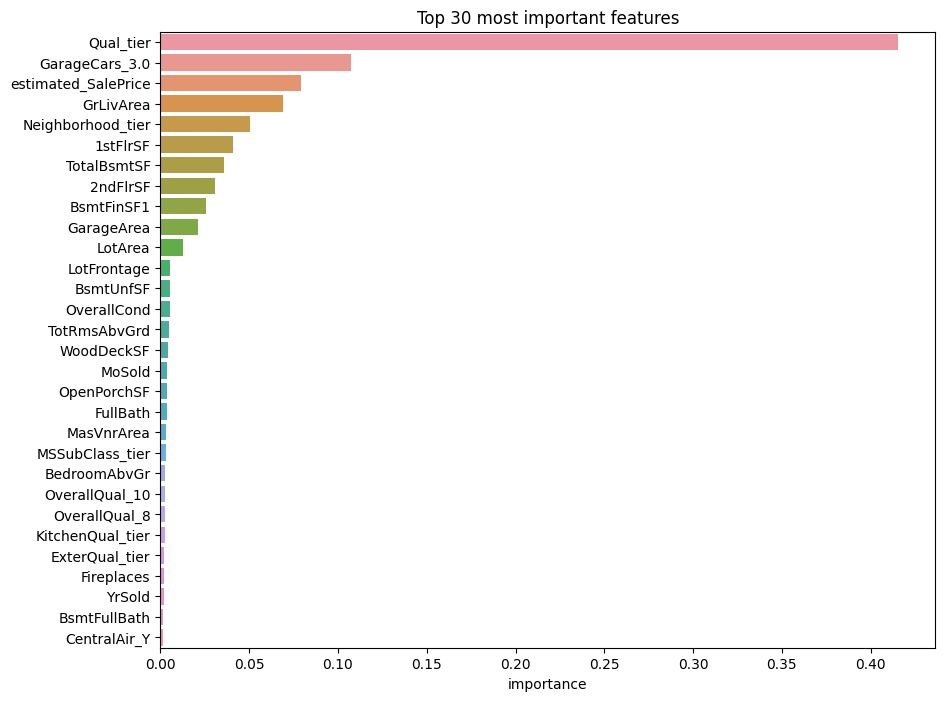

In [64]:
# Rebuild the model with the new feature
title = "Estimated SalePrice added as a feature"
rf_pipeline_v1 = build_pipeline(numerical_columns=numerical_features_1, categorical_columns=categorical_features_1)
rf_pipeline_v1.fit(X, y)

# Cross validation
current_scores = cross_validate_estimator(estimator=rf_pipeline_v1, X=X, y=y, cv=5)

scores[title] = current_scores

# Display feature importance
rf_model_v1 = rf_pipeline_v1.named_steps['model']
X_transformed = rf_pipeline_v1.named_steps['preprocessor'].transform(X)
cat_one_hot_features = rf_pipeline_v1.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(
    categorical_features_1
    )
X_transformed = pd.DataFrame(
    data=X_transformed,
    columns=(list(numerical_features_1) + list(cat_one_hot_features))
)

display_feature_importance(
    rf_model_v1,
    feature_names=X_transformed.columns,
    n=30
)

In [65]:
# # Predict SalePrice
# # exports to csv, so kept as comment when not needed

# model_predictions = rf_pipeline_v1.predict(df_test_2)
# submission = pd.DataFrame({'Id': df_test_2['Id'], 'SalePrice': model_predictions})
# submission.to_csv('submission.csv', index=False)


In [66]:
# # Predict SalePrice based on base model
# # exports to csv, so kept as comment when not needed
# model_prediction(
#     model=rf_model_base, 
#     pipeline=rf_pipeline_base, 
#     X_test=df_test, 
#     original_data=df_test_orig, 
#     numerical_features=numerical_features_1, 
#     categorical_features=categorical_features_1
#     )

Score: 0.15136

### Some Preliminary Conclusions
- There are a few features that basically have the same data:
    -   GarageArea and GarageCars - keep GarageArea
-  There is no sense to have duplicate features after all. We will drop the following features:
    -  All the 'No Garage' features except one
    -  All the 'No Basement' features except one
- More features that should be categorical:
    - 'MSSubClass'
    - 'MoSold'
    - 'YrSold'
    - 'BsmtFullBath'
    - 'BsmtHalfBath'
    - 'FullBath'
    - 'HalfBath'
    - 'BedroomAbvGr'
    - 'KitchenAbvGr'
    - 'TotRmsAbvGrd'
    - 'Fireplaces'
    - 'MiscVal'
- We will attempt to keep 'OverallQual' as a numerical feature and see how that affects the model.

GarageCars feature removed
Cross-validation scores: [0.89398367 0.8512372  0.88569083 0.89105427 0.84525421], scores average: 0.8734440338200458, std: 0.020831663200634187

MSE Cross-validation scores: [5.86549102e+08 9.77471250e+08 8.66211806e+08 5.51903282e+08
 1.03762773e+09], scores average: 803952635.1015103, std: 199690830.3395869

Log RMSE Cross-validation scores: [0.12819985 0.16054039 0.139638   0.13521101 0.14638734], scores average: 0.14199531625926118, std: 0.011000985290892641


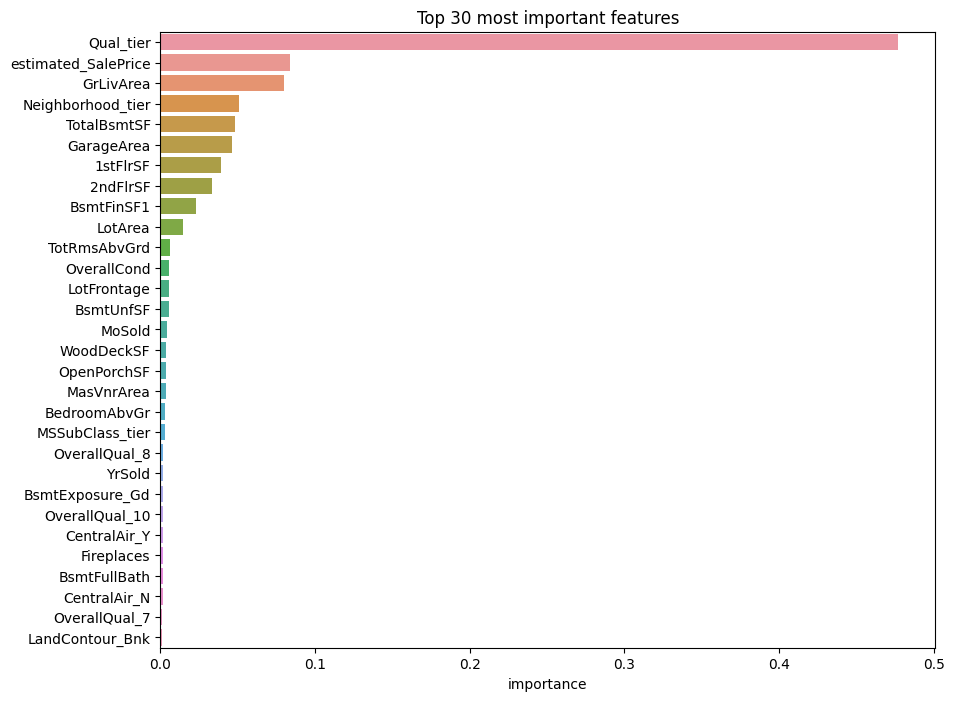

In [67]:
# Remove the 'GarageCars' feature from model prediction
X, df_test, categorical_features_2 = remove_feature(train_data=X, test_data=df_test, feature='GarageCars', feature_index=categorical_features_1)

numerical_features_2 = numerical_features_1
# Rebuild the pipeline
title = "GarageCars feature removed"
rf_model_V3, rf_pipeline_v3 = model_rebuilder(
    X=X,
    y=y,
    numerical_features=numerical_features_2,
    categorical_features=categorical_features_2,
    n_features=30,
    title=title
)

In [68]:
# Remove 'OverallQual' from the list of suspected categorical features, because it was already converted to categorical
suspected_categorical.remove('OverallQual')

In [69]:
# Convert suspected categorical features to categorical features
numerical_features_3, categorical_features_3 = convert_to_categorical(
    df=X,
    columns=suspected_categorical,
    num_features=numerical_features_2,
    cat_features=categorical_features_2
)

Suspected categorical features converted to categorical
Cross-validation scores: [0.89069052 0.84183156 0.88593726 0.89297419 0.8512116 ], scores average: 0.8725290237680736, std: 0.02156104203138837

MSE Cross-validation scores: [6.04768913e+08 1.03927262e+09 8.64344381e+08 5.42177234e+08
 9.97681221e+08], scores average: 809648874.2291477, std: 202282823.98851213

Log RMSE Cross-validation scores: [0.13375731 0.16321819 0.14159504 0.1365129  0.1466219 ], scores average: 0.14434106844218636, std: 0.010415226770261035


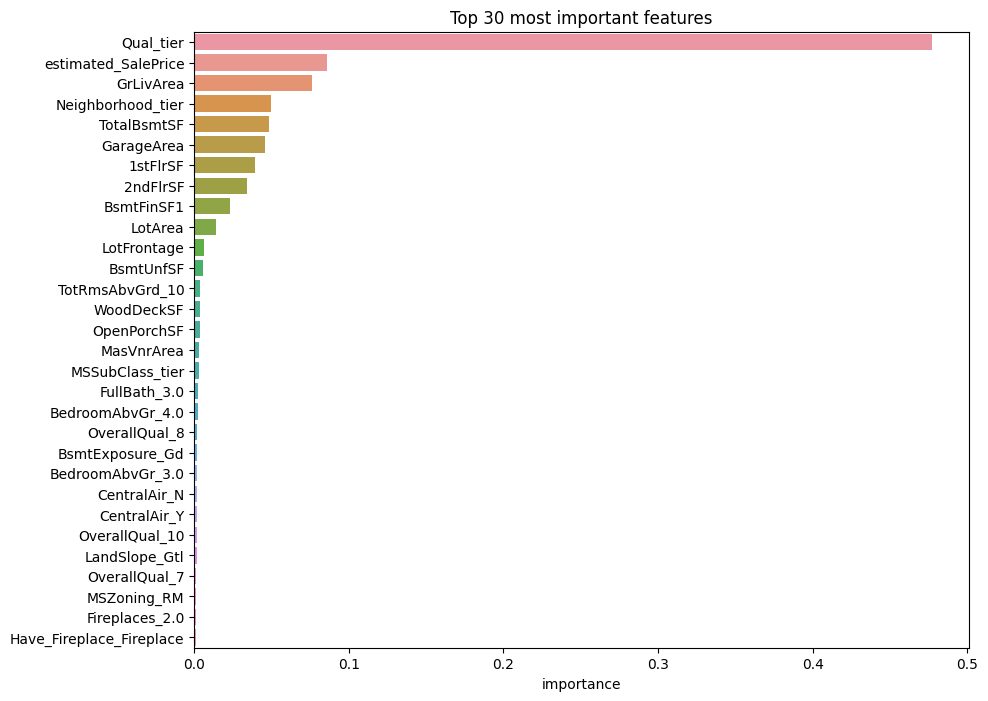

In [70]:
# Rebuild the pipeline
title = "Suspected categorical features converted to categorical"
rf_model_v4, rf_pipeline_v4 = model_rebuilder(
    X=X,
    y=y,
    numerical_features=numerical_features_3,
    categorical_features=categorical_features_3,
    n_features=30,
    title=title
)

In [71]:
X_vars = X.copy()
X_vars = X_vars.drop('Id', axis=1)
df_test_vars = df_test.copy()

In [72]:
# Convert the binned quality features to numerical features via mapping
binned_quality_features = [
    'OverallQual',
    'OverallCond',
    'ExterQual_binned',
    'BsmtQual_binned',
    'HeatingQC',
    'KitchenQual_binned',
]

# Display a list of unique values for each quality feature
for feature in binned_quality_features:
    print(f'{feature}: {X_vars[feature].unique().tolist()}')

OverallQual: [7, 6, 8, 5, 9, 4, 10, 3, 2]
OverallCond: [5.0, 7.5, 6.0, 7.0, 4.0, 3.5]
ExterQual_binned: ['fair', 'poor', 'good']
BsmtQual_binned: ['fair', 'poor', 'good', nan]
HeatingQC: ['Excellent', 'Good', 'Average', 'Fair', 'Poor']
KitchenQual_binned: ['fair', 'poor', 'good']


In [73]:
# Map the binned quality features to numerical values
X_vars['OverallQual'] = X_vars['OverallQual'].map({2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9})
df_test_vars['OverallQual'] = df_test_vars['OverallQual'].map({2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9})

X_vars['OverallCond'] = X_vars['OverallCond'].map({3.5: 1, 4.0: 2, 5.0: 3, 6.0: 4, 7.0: 5, 7.5: 6})
df_test_vars['OverallCond'] = df_test_vars['OverallCond'].map({3.5: 1, 4.0: 2, 5.0: 3, 6.0: 4, 7.0: 5, 7.5: 6})

X_vars['HeatingQC'] = X_vars['HeatingQC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
df_test_vars['HeatingQC'] = df_test_vars['HeatingQC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [74]:
# Add the new feature to the numerical features list
numerical_features_4 = numerical_features_3.append(pd.Index(['OverallQual', 'OverallCond', 'HeatingQC']))

# Remove the binned quality features from the list of categorical features
categorical_features_4 = categorical_features_3.drop(['HeatingQC', 'OverallQual', 'OverallCond'])

In [75]:
# Rebuild the 'estimated_SalePrice' feature 
# Calculate the mean SalePrice per GrLivArea
mean_SalePrice_per_GrLivArea = y.sum() / X_vars['GrLivArea'].sum()

# Create a new feature of estimated SalePrice
X_vars['estimated_SalePrice'] = X_vars['GrLivArea'] * mean_SalePrice_per_GrLivArea
df_test_vars['estimated_SalePrice'] = df_test_vars['GrLivArea'] * mean_SalePrice_per_GrLivArea

# Add the new feature to the numerical features list
numerical_features_4 = numerical_features_4.append(pd.Index(['estimated_SalePrice']))

In [76]:
numerical_features_4 = numerical_features_4.drop_duplicates()

In [77]:
X_vars[numerical_features_4] = X_vars[numerical_features_4].astype('float64').fillna(0)
X_vars[numerical_features_4].isnull().sum()

LotFrontage            0
LotArea                0
MasVnrArea             0
BsmtFinSF1             0
BsmtFinSF2             0
BsmtUnfSF              0
TotalBsmtSF            0
1stFlrSF               0
2ndFlrSF               0
LowQualFinSF           0
GrLivArea              0
GarageArea             0
WoodDeckSF             0
OpenPorchSF            0
EnclosedPorch          0
3SsnPorch              0
ScreenPorch            0
Neighborhood_tier      0
MSSubClass_tier        0
Qual_tier              0
ExterQual_tier         0
BsmtQual_tier          0
KitchenQual_tier       0
estimated_SalePrice    0
OverallQual            0
OverallCond            0
HeatingQC              0
dtype: int64

### Variance analysis:

In [78]:
X_vars[numerical_features_4].var(axis=0).sort_values(ascending=False)

estimated_SalePrice   3354316198.481
LotArea                 12919397.923
GrLivArea                 231722.508
2ndFlrSF                  189914.337
BsmtFinSF1                187679.079
BsmtUnfSF                 186373.709
TotalBsmtSF               158354.555
1stFlrSF                  131466.433
GarageArea                 42892.783
MasVnrArea                 18149.362
WoodDeckSF                 13609.117
OpenPorchSF                 2756.416
LotFrontage                 1084.946
MSSubClass_tier                3.590
Qual_tier                      2.798
OverallQual                    1.900
Neighborhood_tier              1.753
OverallCond                    1.119
BsmtQual_tier                  0.460
KitchenQual_tier               0.441
ExterQual_tier                 0.330
LowQualFinSF                   0.000
EnclosedPorch                  0.000
3SsnPorch                      0.000
ScreenPorch                    0.000
BsmtFinSF2                     0.000
HeatingQC                      0.000
d

In [79]:
scaler = MinMaxScaler()

X_vars_numerical_scaled = scaler.fit_transform(X_vars[numerical_features_4])

In [80]:
X_vars_numerical_scaled = pd.DataFrame(X_vars_numerical_scaled, columns=numerical_features_4)

variances = X_vars_numerical_scaled.var(axis=0).sort_values(ascending=False).to_frame()

variances.columns = ['variance']

variances

variance
MasVnrArea              0.105
MSSubClass_tier         0.100
OpenPorchSF             0.095
WoodDeckSF              0.077
BsmtUnfSF               0.066
LotFrontage             0.060
BsmtFinSF1              0.059
2ndFlrSF                0.057
BsmtQual_tier           0.051
LotArea                 0.049
KitchenQual_tier        0.049
GarageArea              0.049
Neighborhood_tier       0.049
OverallCond             0.045
estimated_SalePrice     0.040
GrLivArea               0.040
1stFlrSF                0.040
TotalBsmtSF             0.039
ExterQual_tier          0.037
Qual_tier               0.035
OverallQual             0.030
ScreenPorch             0.000
3SsnPorch               0.000
EnclosedPorch           0.000
BsmtFinSF2              0.000
LowQualFinSF            0.000
HeatingQC               0.000

In [81]:
high_variance_columns = variances[variances['variance'] >= 0.010].index

low_variance_columns = variances[variances['variance'] < 0.010].index

# Remove low variance features from the numerical features list and the dataframe
numerical_features_5 = numerical_features_4.drop(low_variance_columns)
categorical_features_5 = categorical_features_4

X_vars = X_vars.drop(low_variance_columns, axis=1)
df_test_vars = df_test_vars.drop(low_variance_columns, axis=1)

High variance features selected
Cross-validation scores: [0.88280281 0.85683287 0.87708896 0.8788298  0.8392788 ], scores average: 0.8669666489501257, std: 0.016512359162795965

MSE Cross-validation scores: [6.48408670e+08 9.40703952e+08 9.31395025e+08 6.13830630e+08
 1.07769502e+09], scores average: 842406659.5211489, std: 180457264.3498883

Log RMSE Cross-validation scores: [0.13141175 0.16028653 0.14242795 0.13746824 0.15389236], scores average: 0.14509736533025186, std: 0.010589505506722557


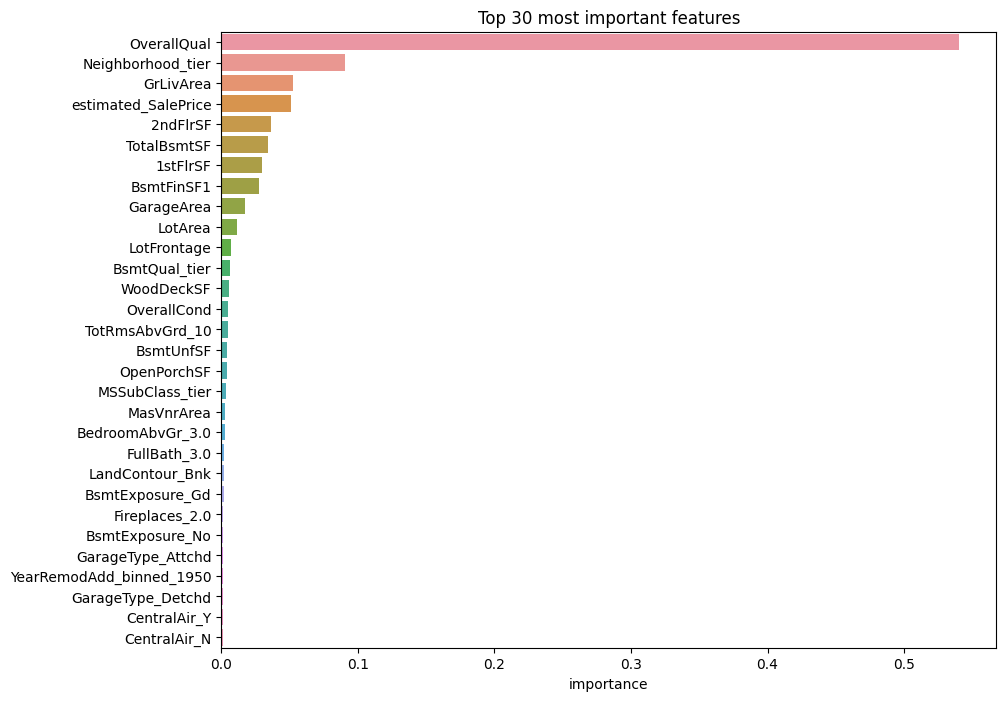

In [82]:
X_high_variance = X_vars[high_variance_columns]

title = "High variance features selected"
rf_model_v5, rf_pipeline_v5 = model_rebuilder(
    X=X_vars,
    y=y,
    numerical_features=high_variance_columns,
    categorical_features=categorical_features_5,
    n_features=30,
    title=title
)

### Scores for the different pipelines:

In [83]:
# Convert scores to a DataFrame
scores_df = pd.DataFrame(scores)
scores_df = scores_df.transpose()

# Rename columns
scores_df.columns = ['Average CV Score', 'CV Score Std', 'Average Negative MSE', 'Negative MSE Std', 'Average RMSE', 'RMSE Std']

# Sort the DataFrame by average RMSE and RMSE Std
scores_df[['Average RMSE', 'RMSE Std']].sort_values(by=['Average RMSE', 'RMSE Std'], ascending=True)

Average RMSE  RMSE Std
Estimated SalePrice added as a feature                     0.141     0.012
GarageCars feature removed                                 0.142     0.011
Suspected categorical features converted to cat...         0.144     0.010
High variance features selected                            0.145     0.011
Base RF model                                              0.145     0.007

In [84]:
# Sort the DataFrame by average cv score and cv score std
scores_df[['Average CV Score', 'CV Score Std']].sort_values(by=['Average CV Score', 'CV Score Std'], ascending=[False, True])

Average CV Score  \
Estimated SalePrice added as a feature                         0.876   
GarageCars feature removed                                     0.873   
Suspected categorical features converted to cat...             0.873   
High variance features selected                                0.867   
Base RF model                                                  0.861   

                                                    CV Score Std  
Estimated SalePrice added as a feature                     0.027  
GarageCars feature removed                                 0.021  
Suspected categorical features converted to cat...         0.022  
High variance features selected                            0.017  
Base RF model                                              0.019

## Part 4: Advanced Methods and Model Enhancement
- Custom Feature Engineering:
    - Calculate mean price per area for each quality group.
    - Use these values to create estimations based on apartment quality group and living area.
    - Explore and create additional custom features to enhance model performance.
    - Document the impact of these features on the model's accuracy.
- Kaggle Competition and Stacked Regression:
    - Integrate new features into the stacked regression notebook provided (link: Stacked Regressions Notebook).
    - Submit the updated model to Kaggle and report the new score.


In [85]:
X = X_vars.copy()
df_test = df_test_vars.copy()

unique_values = X.nunique().to_frame()
unique_values.columns = ['unique_values']
low_unique_values = unique_values[unique_values['unique_values'] == 1]
print(unique_values[unique_values['unique_values'] == 1])

X = X.drop(low_unique_values.index, axis=1)
df_test = df_test.drop(low_unique_values.index, axis=1)

numerical_features_6 = numerical_features_5
categorical_features_6 = categorical_features_5

# Remove the low unique values from the list of categorical features and the list of numerical features
for feature in low_unique_values.index:
    if feature in categorical_features_6:
        categorical_features_6 = categorical_features_6.drop(feature)
    elif feature in numerical_features_6:
        numerical_features_6 = numerical_features_6.drop(feature)

              unique_values
BsmtHalfBath              1
KitchenAbvGr              1
PoolArea                  1
MiscVal                   1


Low unique values removed
Cross-validation scores: [0.8855112  0.86432956 0.88298834 0.88150167 0.83747037], scores average: 0.8703602303976101, std: 0.018062472221575945

MSE Cross-validation scores: [6.33424128e+08 8.91445631e+08 8.86690707e+08 6.00295352e+08
 1.08982121e+09], scores average: 820335405.3771503, std: 181898729.6865662

Log RMSE Cross-validation scores: [0.13006427 0.15855237 0.13955375 0.13646995 0.15173688], scores average: 0.14327544708375167, std: 0.010389237274025477


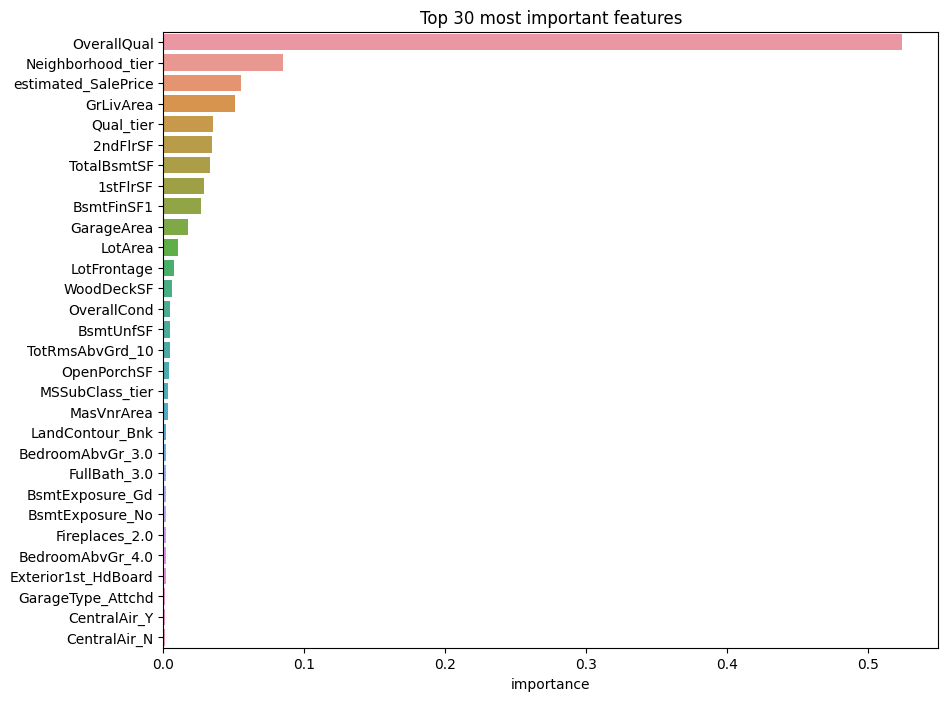

In [86]:
# Rebuild the model with the updated features
title = "Low unique values removed"
rf_model_v6, rf_pipeline_v6 = model_rebuilder(
    X=X,
    y=y,
    numerical_features=numerical_features_6,
    categorical_features=categorical_features_6,
    n_features=30,
    title=title
)

In [87]:
# Create 'Total_SF'
X['Total_SF'] = X['TotalBsmtSF'] + X['GrLivArea'] + X['GarageArea']
df_test['Total_SF'] = df_test['TotalBsmtSF'] + df_test['GrLivArea'] + df_test['GarageArea']

# Remove outliers from the 'Total_SF' feature
outlier_removal(data=X, column='Total_SF')
outlier_removal(data=df_test, column='Total_SF')
remove_outliers_zscore(df=X, column='Total_SF')
remove_outliers_zscore(df=df_test, column='Total_SF')

# Add 'Total_SF' to the numerical features list
numerical_features_7 = numerical_features_6.append(pd.Index(['Total_SF']))
categorical_features_7 = categorical_features_6

Total_SF feature added
Cross-validation scores: [0.8821747  0.86739022 0.88802207 0.90238593 0.86558798], scores average: 0.8811121811260298, std: 0.01364361338651494

MSE Cross-validation scores: [6.51883774e+08 8.71335067e+08 8.48546156e+08 4.94498693e+08
 9.01282236e+08], scores average: 753509184.9844968, std: 156311226.7608464

Log RMSE Cross-validation scores: [0.12928845 0.15384082 0.14476099 0.13211421 0.13999169], scores average: 0.13999923220275123, std: 0.008844867729909773


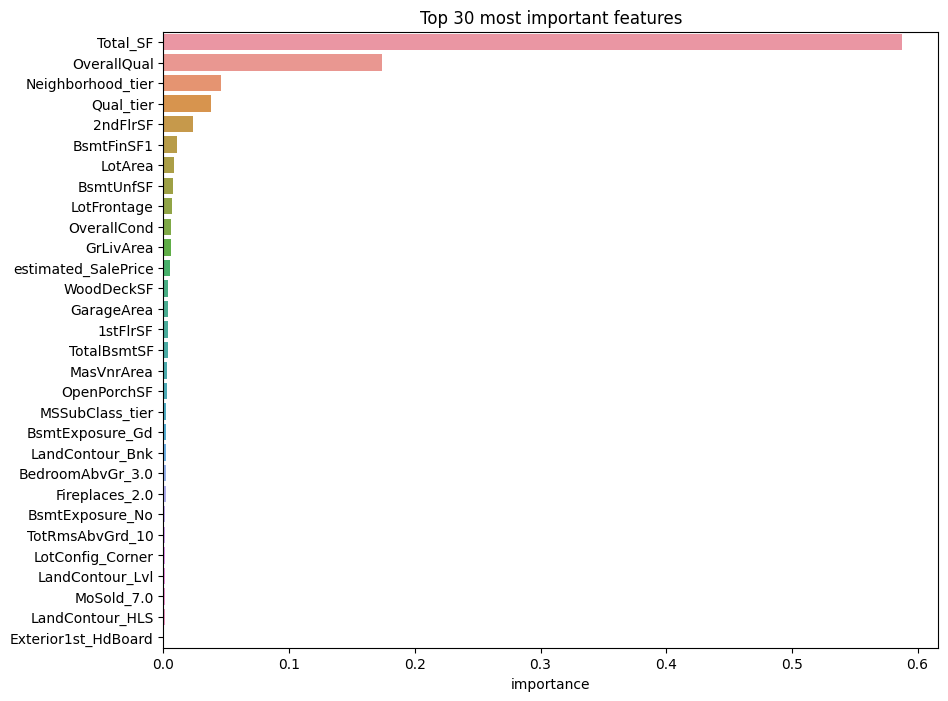

In [88]:
# Rebuild the model with the new feature
title = "Total_SF feature added"
rf_model_v7, rf_pipeline_v7 = model_rebuilder(
    X=X,
    y=y,
    numerical_features=numerical_features_7,
    categorical_features=categorical_features_7,
    n_features=30,
    title=title
)

In [89]:
# Change 'estimated_SalePrice' to 'Estimated_SalePrice' based on 'Total_SF'
mean_SalePrice_per_Total_SF = y.sum() / X['Total_SF'].sum()

X['estimated_SalePrice'] = X['Total_SF'] * mean_SalePrice_per_Total_SF
df_test['estimated_SalePrice'] = df_test['Total_SF'] * mean_SalePrice_per_Total_SF

# Remove outliers from the 'estimated_SalePrice' feature
remove_outliers_zscore(df=X, column='estimated_SalePrice')
remove_outliers_zscore(df=df_test, column='estimated_SalePrice')
outlier_removal(data=X, column='estimated_SalePrice')
outlier_removal(data=df_test, column='estimated_SalePrice')


Estimated_SalePrice feature changed
Cross-validation scores: [0.8864204  0.86763645 0.88842469 0.89978006 0.86206211], scores average: 0.8808647416230947, std: 0.01395947284676823

MSE Cross-validation scores: [6.28393876e+08 8.69717198e+08 8.45495165e+08 5.07699656e+08
 9.24924543e+08], scores average: 755246087.773668, std: 159630842.04537284

Log RMSE Cross-validation scores: [0.1278038  0.15314484 0.14550057 0.13264393 0.14049273], scores average: 0.13991717563586864, std: 0.009012334132929551


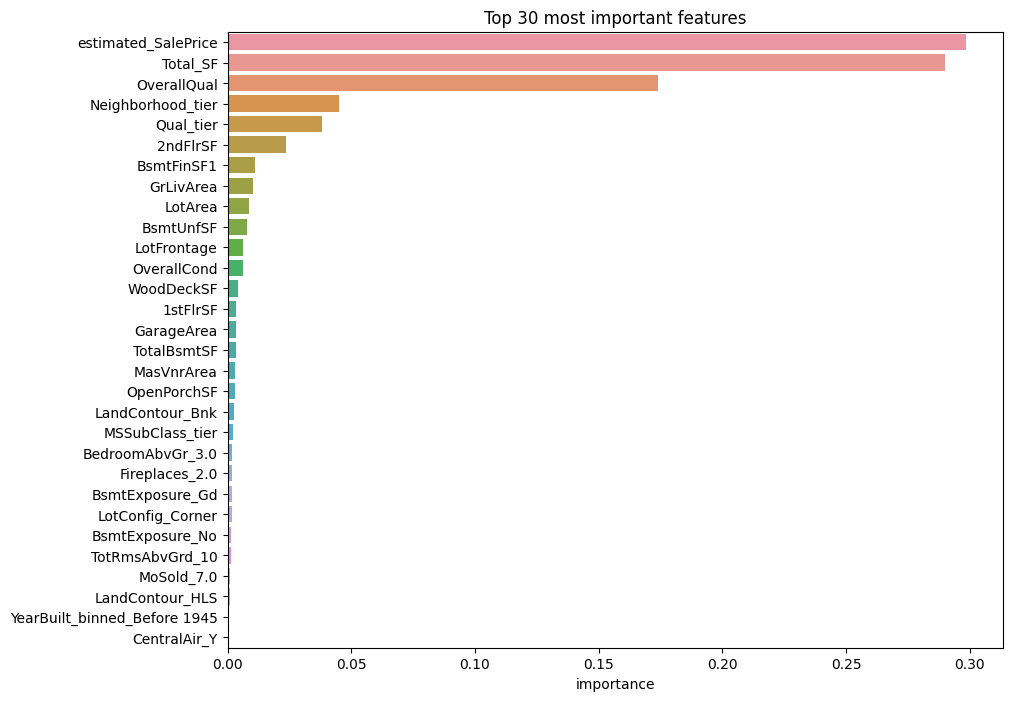

In [90]:
# Rebuild the model with the new feature
title = "Estimated_SalePrice feature changed"
rf_model_v8, rf_pipeline_v8 = model_rebuilder(
    X=X,
    y=y,
    numerical_features=numerical_features_7,
    categorical_features=categorical_features_7,
    n_features=30,
    title=title
)

In [91]:
# # Predict SalePrice
# # exports to csv, so kept as comment when not needed

# model_prediction(
#     model=rf_model_v8, 
#     pipeline=rf_pipeline_v8, 
#     X_test=df_test, 
#     original_data=df_test_orig, 
#     numerical_features=numerical_features_7, 
#     categorical_features=categorical_features_7
#     )

In [92]:
X['GarageCars'] = df['GarageCars']
df_test['GarageCars'] = df_test_orig['GarageCars']

# Fill null values in the 'GarageCars' feature with 0   
X['GarageCars'] = X['GarageCars'].fillna(0)
df_test['GarageCars'] = df_test['GarageCars'].fillna(0)

#Remove outliers from the 'GarageCars' feature
remove_outliers_zscore(df=X, column='GarageCars')
remove_outliers_zscore(df=df_test, column='GarageCars')
outlier_removal(data=X, column='GarageCars')
outlier_removal(data=df_test, column='GarageCars')

In [93]:
OverallQual_pivot = X.pivot_table(index=['OverallQual','GarageCars'] , values='estimated_SalePrice' , aggfunc=['median'])
OverallQual_pivot = OverallQual_pivot.reset_index()
OverallQual_pivot.columns = OverallQual_pivot.columns.droplevel(-1)
OverallQual_pivot.head()

OverallQual  GarageCars     median
0        1.000       0.000  63670.132
1        1.000       1.000  67081.032
2        2.000       0.000  98616.897
3        2.000       1.000 132666.056
4        2.000       2.000  89640.844

In [94]:
X = X.merge(OverallQual_pivot, how='left', left_on=['OverallQual','GarageCars'], right_on=['OverallQual','GarageCars'])

In [95]:
X = X.drop(['GarageCars'], axis=1)
X = X.rename(columns={'median': 'OverallQual_GarageCars_median'})

# Add the new feature to the numerical features list
numerical_features_8 = numerical_features_7.append(pd.Index(['OverallQual_GarageCars_median']))
categorical_features_8 = categorical_features_7

# Remove outliers from the 'OverallQual_GarageCars_median' feature
outlier_removal(data=X, column='OverallQual_GarageCars_median')

OverallQual_GarageCars_median feature added
Cross-validation scores: [0.88324105 0.86837614 0.88751598 0.90269831 0.8530535 ], scores average: 0.8789769992337965, std: 0.016959969193646958

MSE Cross-validation scores: [6.45984023e+08 8.64856898e+08 8.52381145e+08 4.92916245e+08
 9.85330557e+08], scores average: 768293773.6731119, std: 175665902.73265514

Log RMSE Cross-validation scores: [0.12858768 0.1567481  0.14824031 0.13281868 0.14298624], scores average: 0.14187620193939915, std: 0.010213040942317217


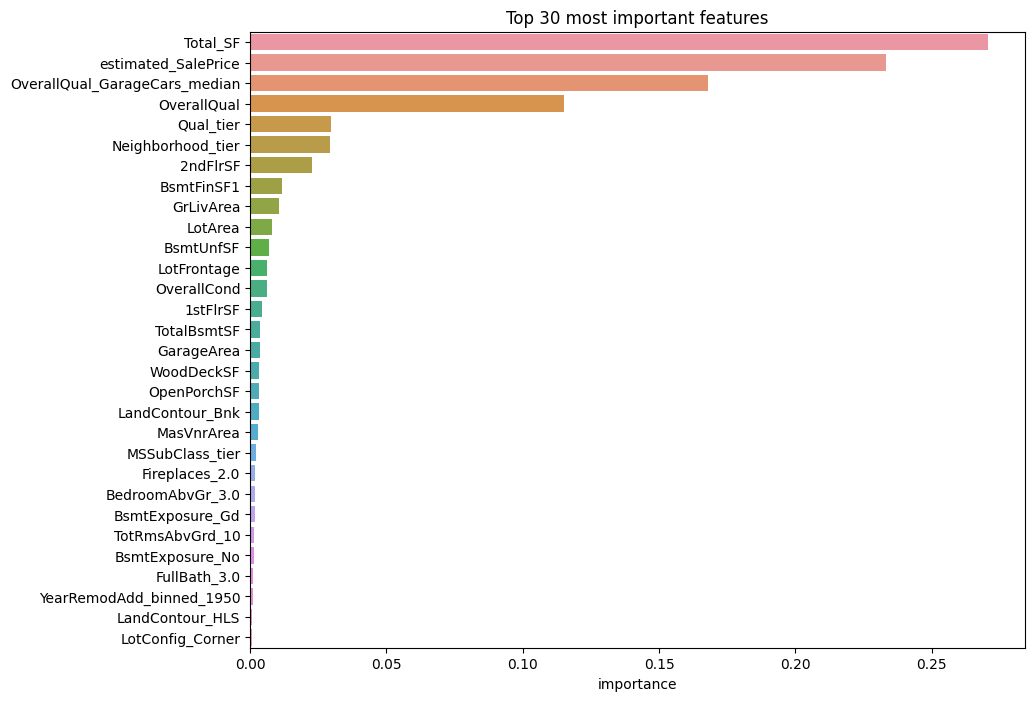

In [96]:
# Rebuild the model with the new features
title = "OverallQual_GarageCars_median feature added"
rf_model_v9, rf_pipeline_v9 = model_rebuilder(
    X=X,
    y=y,
    numerical_features=numerical_features_8,
    categorical_features=categorical_features_8,
    n_features=30,
    title=title
)

In [97]:
df_test = df_test.merge(OverallQual_pivot, how='left', left_on=['OverallQual','GarageCars'], right_on=['OverallQual','GarageCars'])
df_test = df_test.drop(['GarageCars', 'Id'], axis=1)
df_test = df_test.rename(columns={'median': 'OverallQual_GarageCars_median'})
outlier_removal(data=df_test, column='OverallQual_GarageCars_median')

In [98]:
for feature in df_test.columns:
    if feature not in X.columns:
        print(feature)

In [99]:
# # Predict SalePrice
# # exports to csv, so kept as comment when not needed

# model_prediction(
#     model=rf_model_v9, 
#     pipeline=rf_pipeline_v9, 
#     X_test=df_test, 
#     original_data=df_test_orig, 
#     numerical_features=numerical_features_8, 
#     categorical_features=categorical_features_8
#     )

In [100]:
# Convert to 'category' dtype
X[categorical_features_8] = X[categorical_features_8].astype('category')

# Show missing values in the training data
X['Have_Fireplace'].value_counts()

Have_Fireplace
Fireplace       770
No Fireplace    690
Name: count, dtype: int64

In [101]:
# Show missing values in the test data
df_test['Have_Fireplace'] = df_test['Have_Fireplace'].fillna('No Fireplace')
df_test[categorical_features_8] = df_test[categorical_features_8].astype('category')

## XGBoost:

Cross-validation scores: [0.89736247 0.89844008 0.9115453  0.92709889 0.88935885], scores average: 0.9047611179194073, std: 0.013243312064659243

MSE Cross-validation scores: [5.67855438e+08 6.67316699e+08 6.70291870e+08 3.69306441e+08
 7.41889810e+08], scores average: 603332051.4118114, std: 129462335.30739243

Log RMSE Cross-validation scores: [0.11823532 0.13901786 0.13177366 0.11914459 0.12674372], scores average: 0.12698302960771185, std: 0.007820589949388274


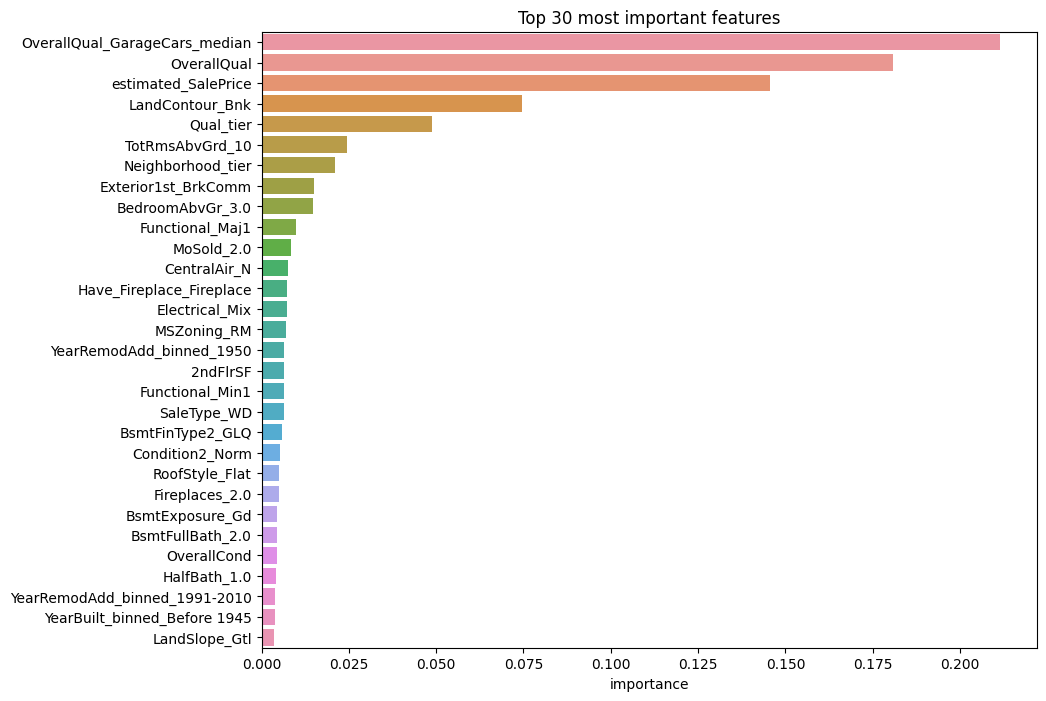

In [102]:
# Build an XGB pipeline
xgb_pipeline = build_XGB_pipeline(numerical_columns=numerical_features_8, categorical_columns=categorical_features_8)

# Fit the pipeline
xgb_pipeline.fit(X, y)

# Access the transformed dataframe
# Access the preprocessor
preprocessor = xgb_pipeline.named_steps['preprocessor']

# Access the column transformer
column_transformer = preprocessor.named_transformers_['cat']

# Access the one hot encoder
one_hot = column_transformer.named_steps['onehot']

# Get the feature names from the one hot encoder
cat_one_hot_features = one_hot.get_feature_names_out(categorical_features_8)

# Create a DataFrame of the transformed data
processed_X = pd.DataFrame(
    data=preprocessor.transform(X),
    columns=(list(numerical_features_8) + list(cat_one_hot_features))
)

# Remove duplicate features from the XGB pipeline
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features_8)

transformed_X = duplicate_feature_remover.transform(processed_X)

# Refit the model from the pipeline on the transformed dataframe
xgb_model = xgb_pipeline.named_steps['model']

xgb_model.fit(transformed_X, y)

# Cross validation
current_scores = cross_validate_estimator(estimator=xgb_model, X=transformed_X, y=y, cv=5)

scores['XGB model'] = current_scores

# Display feature importance
display_feature_importance(
    xgb_model,
    feature_names=transformed_X.columns,
    n=30
)

In [103]:
# Predict SalePrice
# exports to csv, so kept as comment when not needed
# Access the preprocessor from the pipeline
preprocessor = xgb_pipeline.named_steps['preprocessor']
    
# Transform the test data
X_test_processed = preprocessor.transform(df_test)
    
# Get the feature names from ColumnTransformer
column_transformer = preprocessor.named_transformers_['cat']
    
# Access the one hot encoder
one_hot_encoder = column_transformer.named_steps['onehot']
    
# Get the feature names from the one hot encoder
cat_one_hot_features = one_hot_encoder.get_feature_names_out(categorical_features_8)
    
# Create a DataFrame of the transformed test data
X_test_processed = pd.DataFrame(
    data=X_test_processed,
    columns=(list(numerical_features_8) + list(cat_one_hot_features))
)   
    
# Remove duplicate features from the transformed test data
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features_8)
X_test_transformed = duplicate_feature_remover.transform(X_test_processed)    
        
# # Model predictions
# predictions = xgb_model.predict(X_test_transformed)

# ## Prepare submission file
# submission = pd.DataFrame({
#     'Id': df_test_orig['Id'],
#     'SalePrice': predictions
# })

# # Get file name from user
# file_name = input('File Name: ')

# # Save submission file as csv
# submission.to_csv(f'{file_name}.csv', index=False)

### Add more features:

In [104]:
# Create 'estimated_SalePrice_per_YearBuilt' feature
OverallQual_pivot_2 = X.pivot_table(index=['OverallQual','YearBuilt_binned'] , values='estimated_SalePrice' , aggfunc=['median'])
OverallQual_pivot_2 = OverallQual_pivot_2.reset_index()
OverallQual_pivot_2.columns = OverallQual_pivot_2.columns.droplevel(-1)
OverallQual_pivot_2.head()

OverallQual YearBuilt_binned     median
0        1.000        1945-1991  56736.132
1        1.000        1992-2010  63670.132
2        2.000        1945-1991  89640.844
3        2.000        1992-2010 129494.517
4        3.000        1945-1991 130182.681

In [105]:
X = X.merge(OverallQual_pivot_2, how='left', left_on=['OverallQual','YearBuilt_binned'], right_on=['OverallQual','YearBuilt_binned'])

# Rename the new feature
X = X.rename(columns={'median': 'OverallQual_YearBuilt_binned_median'})

# Add the new feature to the numerical features list
numerical_features_9 = numerical_features_8.append(pd.Index(['OverallQual_YearBuilt_binned_median']))
categorical_features_9 = categorical_features_8

# Remove outliers from the 'OverallQual_YearBuilt_binned_median' feature
remove_outliers_zscore(df=X, column='OverallQual_YearBuilt_binned_median')
outlier_removal(data=X, column='OverallQual_YearBuilt_binned_median')

In [106]:
# Add the new feature to the test data
df_test = df_test.merge(OverallQual_pivot_2, how='left', left_on=['OverallQual','YearBuilt_binned'], right_on=['OverallQual','YearBuilt_binned'])
df_test = df_test.rename(columns={'median': 'OverallQual_YearBuilt_binned_median'})

# Remove outliers from the 'OverallQual_YearBuilt_binned_median' feature
remove_outliers_zscore(df=df_test, column='OverallQual_YearBuilt_binned_median')
outlier_removal(data=df_test, column='OverallQual_YearBuilt_binned_median')

Cross-validation scores: [0.89714966 0.90140559 0.90863493 0.92542232 0.88971259], scores average: 0.9044650166732037, std: 0.012141707099291282

MSE Cross-validation scores: [5.69032875e+08 6.47831279e+08 6.92346073e+08 3.77799722e+08
 7.39517847e+08], scores average: 605305559.22787, std: 126863737.42976393

Log RMSE Cross-validation scores: [0.12426174 0.14159717 0.13293887 0.11966071 0.12911466], scores average: 0.1295146299344671, std: 0.007517523112688316


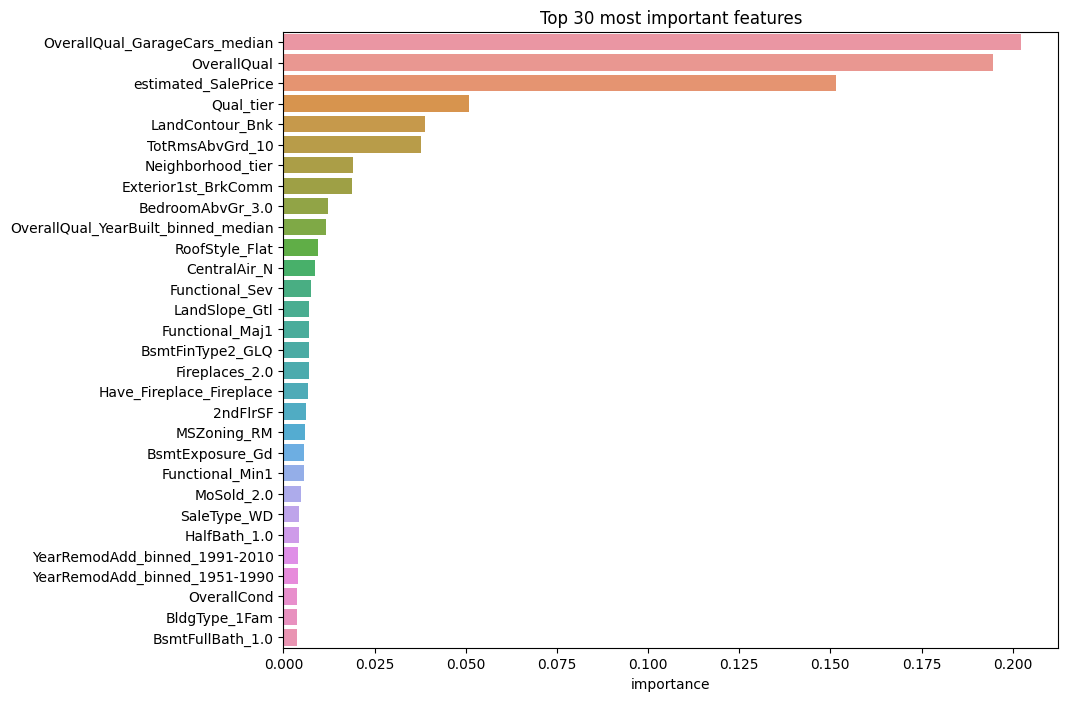

In [107]:
# Build an XGB pipeline
xgb_pipeline_v1 = build_XGB_pipeline(numerical_columns=numerical_features_9, categorical_columns=categorical_features_9)

# Fit the pipeline
xgb_pipeline_v1.fit(X, y)

# Access the transformed dataframe
# Access the preprocessor
preprocessor_v1 = xgb_pipeline_v1.named_steps['preprocessor']

# Access the column transformer
column_transformer_v1 = preprocessor_v1.named_transformers_['cat']

# Access the one hot encoder
one_hot_v1 = column_transformer_v1.named_steps['onehot']

# Get the feature names from the one hot encoder
cat_one_hot_features_v1 = one_hot_v1.get_feature_names_out(categorical_features_9)

# Create a DataFrame of the transformed data
processed_X_v1 = pd.DataFrame(
    data=preprocessor_v1.transform(X),
    columns=(list(numerical_features_9) + list(cat_one_hot_features_v1))
)

# Remove duplicate features from the XGB pipeline
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features_9)

transformed_X_v1 = duplicate_feature_remover.transform(processed_X_v1)

# Refit the model from the pipeline on the transformed dataframe
xgb_model_v1 = xgb_pipeline_v1.named_steps['model']

xgb_model_v1.fit(transformed_X_v1, y)

# Cross validation
current_scores = cross_validate_estimator(estimator=xgb_model_v1, X=transformed_X_v1, y=y, cv=5)

scores['XGB model_v1'] = current_scores

# Display feature importance
display_feature_importance(
    xgb_model_v1,
    feature_names=transformed_X_v1.columns,
    n=30
)

### Hyperparameter tuning:

In [108]:
# Enhance the XGB model with hyperparameter tuning
# Create a parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'model__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'model__subsample': [0.5, 0.75, 1.0, 1.25, 1.5],
    'model__colsample_bytree': [0.5, 0.75, 1.0, 1.25, 1.5],
    'model__gamma': [0, 1, 2, 3, 4, 5],
    'model__reg_alpha': [0, 1, 2, 3, 4, 5],
    'model__reg_lambda': [0, 1, 2, 3, 4, 5],
    'model__min_child_weight': [0, 1, 2, 3, 4, 5]
}

log_rmse_scorer = make_scorer(log_rmse, greater_is_better=False)

# Create a RandomizedSearchCV object
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring=log_rmse_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
xgb_random_search.fit(X, y)

# Display the best parameters
xgb_random_search.best_params_

model_subsample = xgb_random_search.best_params_['model__subsample']
model_reg_lambda = xgb_random_search.best_params_['model__reg_lambda']
model_reg_alpha = xgb_random_search.best_params_['model__reg_alpha']
model_n_estimators = xgb_random_search.best_params_['model__n_estimators']
model_min_child_weight = xgb_random_search.best_params_['model__min_child_weight']
model_max_depth = xgb_random_search.best_params_['model__max_depth']
model_learning_rate = xgb_random_search.best_params_['model__learning_rate']
model_gamma = xgb_random_search.best_params_['model__gamma']
model_colsample_bytree = xgb_random_search.best_params_['model__colsample_bytree']

# Display the best parameters
xgb_random_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'model__subsample': 0.5,
 'model__reg_lambda': 3,
 'model__reg_alpha': 3,
 'model__n_estimators': 600,
 'model__min_child_weight': 2,
 'model__max_depth': 4,
 'model__learning_rate': 0.15,
 'model__gamma': 0,
 'model__colsample_bytree': 0.75}

Cross-validation scores: [0.87882706 0.91296921 0.91395108 0.92414358 0.8698646 ], scores average: 0.8999511052444655, std: 0.02145772237215572

MSE Cross-validation scores: [6.70404996e+08 5.71850585e+08 6.52061351e+08 3.84277621e+08
 8.72605977e+08], scores average: 630240106.0781432, std: 157947763.93521503

Log RMSE Cross-validation scores: [0.13487184 0.13553673 0.1298273  0.12299094 0.13327334], scores average: 0.13130003098610854, std: 0.004600244325331518


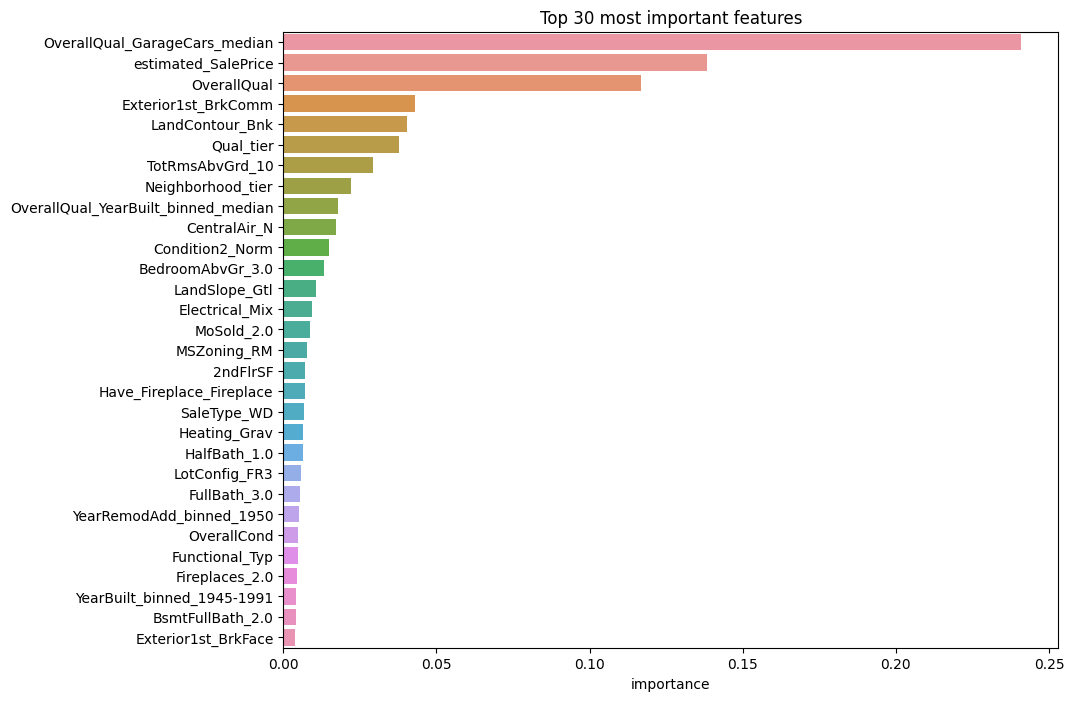

In [109]:
# Incorporate the best parameters into the XGB pipeline
xgb_pipeline_v2 = build_XGB_pipeline(
    numerical_columns=numerical_features_9, 
    categorical_columns=categorical_features_9,
    n_estimators=model_n_estimators,
    max_depth=model_max_depth,
    learning_rate=model_learning_rate,
    subsample=model_subsample,
    colsample_bytree=model_colsample_bytree,
    gamma=model_gamma,
    reg_alpha=model_reg_alpha,
    reg_lambda=model_reg_lambda,
    min_child_weight=model_min_child_weight   
    )

# Fit the pipeline
xgb_pipeline_v2.fit(X, y)

# Access the transformed dataframe
# Access the preprocessor
preprocessor_v2 = xgb_pipeline_v2.named_steps['preprocessor']

# Access the column transformer
column_transformer_v2 = preprocessor_v2.named_transformers_['cat']

# Access the one hot encoder
one_hot_v2 = column_transformer_v2.named_steps['onehot']

# Get the feature names from the one hot encoder
cat_one_hot_features_v2 = one_hot_v2.get_feature_names_out(categorical_features_9)

# Create a DataFrame of the transformed data
processed_X_v2 = pd.DataFrame(
    data=preprocessor_v2.transform(X),
    columns=(list(numerical_features_9) + list(cat_one_hot_features_v2))
)

# Remove duplicate features from the XGB pipeline
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features_9)

transformed_X_v2 = duplicate_feature_remover.transform(processed_X_v2)

# Refit the model from the pipeline on the transformed dataframe
xgb_model_v2 = xgb_pipeline_v2.named_steps['model']

xgb_model_v2.fit(transformed_X_v2, y)

# Cross validation
current_scores = cross_validate_estimator(estimator=xgb_model_v2, X=transformed_X_v2, y=y, cv=5)

scores['XGB model_v2'] = current_scores

# Display feature importance
display_feature_importance(
    xgb_model_v2,
    feature_names=transformed_X_v2.columns,
    n=30
)

In [110]:
# Predict SalePrice
# exports to csv, so kept as comment when not needed
# Access the preprocessor from the pipeline
preprocessor = xgb_pipeline_v2.named_steps['preprocessor']

# Transform the test data
X_test_processed = preprocessor.transform(df_test)

# Get the feature names from ColumnTransformer
column_transformer = preprocessor.named_transformers_['cat']

# Access the one hot encoder
one_hot_encoder = column_transformer.named_steps['onehot']

# Get the feature names from the one hot encoder
cat_one_hot_features = one_hot_encoder.get_feature_names_out(categorical_features_9)

# Create a DataFrame of the transformed test data
X_test_processed = pd.DataFrame(
    data=X_test_processed,
    columns=(list(numerical_features_9) + list(cat_one_hot_features))
)

# Remove duplicate features from the transformed test data
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features_9)
X_test_transformed = duplicate_feature_remover.transform(X_test_processed)

# Model predictions
predictions = xgb_model_v2.predict(X_test_transformed)

# Prepare submission file
# submission = pd.DataFrame({
#     'Id': df_test_orig['Id'],
#     'SalePrice': predictions
# })

# # Get file name from user
# file_name = input('File Name: ')

# # Save submission file as csv
# submission.to_csv(f'{file_name}.csv', index=False)

In [111]:
# Implement GridSearchCV - use the parameter grid from the RandomizedSearchCV
# DEfine a new parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [2, 3, 4],
    'model__learning_rate': [0.05, 0.1, 0.15]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline_v2,
    param_grid=param_grid,
    scoring=log_rmse_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
xgb_grid_search.fit(X, y)

model_n_estimators_grid = xgb_grid_search.best_params_['model__n_estimators']
model_max_depth = xgb_grid_search.best_params_['model__max_depth']
model_learning_rate = xgb_grid_search.best_params_['model__learning_rate']

# Display the best parameters
xgb_grid_search.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


{'model__learning_rate': 0.05,
 'model__max_depth': 4,
 'model__n_estimators': 300}

Cross-validation scores: [0.8979206  0.90154688 0.91019083 0.92609615 0.89041298], scores average: 0.9052334883192547, std: 0.012219189885176346

MSE Cross-validation scores: [5.64767556e+08 6.46902915e+08 6.80555725e+08 3.74386171e+08
 7.34821485e+08], scores average: 600286770.3483156, std: 125704776.87057321

Log RMSE Cross-validation scores: [0.1232679  0.14212276 0.13123027 0.11949588 0.12822743], scores average: 0.12886884855761022, std: 0.007757281334061592


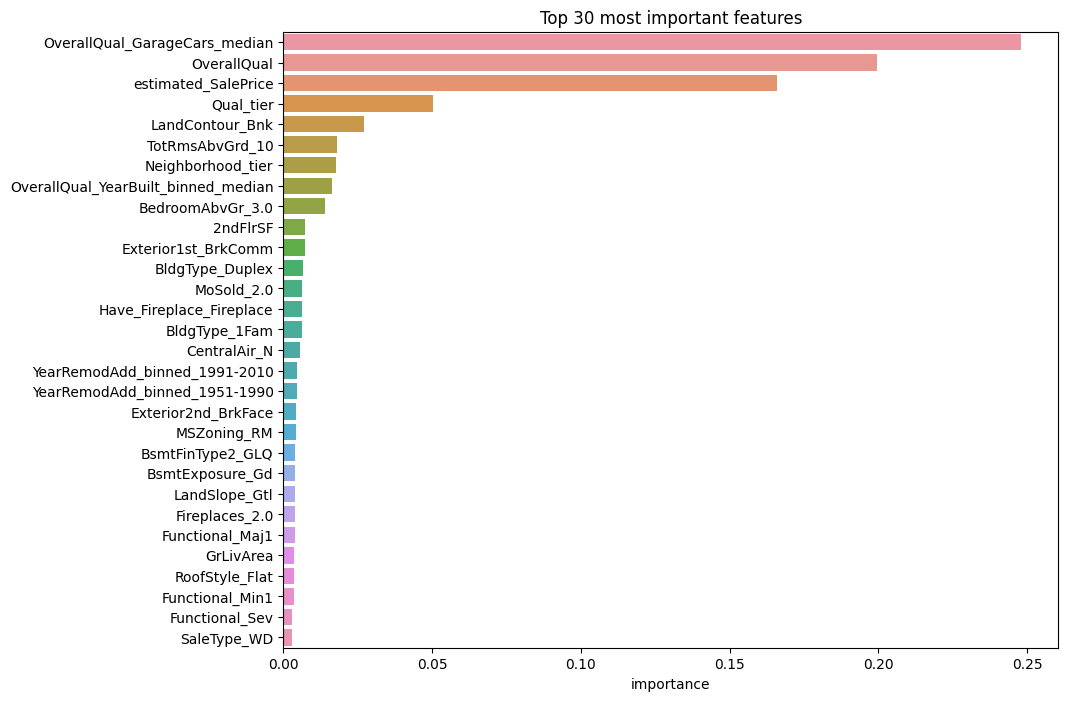

In [112]:
# Incorporate the best parameters into the XGB pipeline
xgb_pipeline_v3 = build_XGB_pipeline(
    numerical_columns=numerical_features_9, 
    categorical_columns=categorical_features_9,
    n_estimators=model_n_estimators_grid,
    max_depth=model_max_depth,
    learning_rate=model_learning_rate,  
    )

# Fit the pipeline
xgb_pipeline_v3.fit(X, y)

# Access the transformed dataframe
# Access the preprocessor
preprocessor_v3 = xgb_pipeline_v3.named_steps['preprocessor']

# Access the column transformer
column_transformer_v3 = preprocessor_v3.named_transformers_['cat']

# Access the one hot encoder
one_hot_v3 = column_transformer_v3.named_steps['onehot']

# Get the feature names from the one hot encoder
cat_one_hot_features_v3 = one_hot_v3.get_feature_names_out(categorical_features_9)

# Create a DataFrame of the transformed data
processed_X_v3 = pd.DataFrame(
    data=preprocessor_v3.transform(X),
    columns=(list(numerical_features_9) + list(cat_one_hot_features_v3))
)

# Remove duplicate features from the XGB pipeline
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features_9)

transformed_X_v3 = duplicate_feature_remover.transform(processed_X_v3)

# Refit the model from the pipeline on the transformed dataframe
xgb_model_v3 = xgb_pipeline_v3.named_steps['model']

xgb_model_v3.fit(transformed_X_v3, y)

# Cross validation
current_scores = cross_validate_estimator(estimator=xgb_model_v3, X=transformed_X_v3, y=y, cv=5)

scores['XGB model_v3'] = current_scores

# Display feature importance
display_feature_importance(
    xgb_model_v3,
    feature_names=transformed_X_v3.columns,
    n=30
)

## Build a Stack of Models:

In [113]:
# Lasso model
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))

In [114]:
# ElasticNet model
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [115]:
# Kernel Ridge model

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [116]:
# Gradient Boosting Regression model
GBoost = GradientBoostingRegressor(
    n_estimators=3000, 
    learning_rate=0.05,
    max_depth=4, 
    max_features='sqrt',
    min_samples_leaf=15, 
    min_samples_split=10,
    loss='huber', random_state =5
    )

In [117]:
# LightGBM model
model_lgb = LGBMRegressor(
    objective='regression',
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=720,
    max_bin = 55, 
    bagging_fraction = 0.8,
    bagging_freq = 5, 
    feature_fraction = 0.2319,
    feature_fraction_seed=9, 
    bagging_seed=9,
    min_data_in_leaf =6, 
    min_sum_hessian_in_leaf = 11
    )

In [118]:
# Merge transformed_X_v3 and y into a single dataframe
X = transformed_X_v3.copy()

In [119]:
# List of models
models = [[lasso, 'lasso'], [ENet, 'ENet'], [KRR, 'KRR'], [GBoost, 'GBoost'], [model_lgb, 'model_lgb'], [xgb_model_v3, 'xgb_model_v3']]
scores = dict()
for model in models:
    print(f'Cross validating {model[1]}:')
    model_scores = cross_validate_estimator(estimator=model[0], X=X, y=y, cv=5)
    scores[model[1]] = model_scores
    print()

Cross validating lasso:


Cross-validation scores: [0.87366409 0.7586377  0.80718715 0.85438458 0.78259491], scores average: 0.8152936851593486, std: 0.04308138376171193

MSE Cross-validation scores: [6.98969823e+08 1.58591197e+09 1.46109686e+09 7.37666610e+08
 1.45778145e+09], scores average: 1188285340.5334485, std: 386690606.2095869

Log RMSE Cross-validation scores: [0.23177201        nan        nan        nan 0.17457393], scores average: nan, std: nan

Cross validating ENet:
Cross-validation scores: [0.86681213 0.76027092 0.82042038 0.85628597 0.78338684], scores average: 0.8174352485241043, std: 0.04094733068454774

MSE Cross-validation scores: [7.36879203e+08 1.57518060e+09 1.36081806e+09 7.28034436e+08
 1.45247127e+09], scores average: 1170676712.920505, std: 364224590.41193706

Log RMSE Cross-validation scores: [0.23839459        nan        nan        nan 0.17406932], scores average: nan, std: nan

Cross validating KRR:
Cross-validation scores: [0.84245978 0.7399086  0.8494204  0.85639787 0.80932521], 

In [120]:
scores_df = pd.DataFrame(scores)
scores_df = scores_df.transpose()
scores_df.columns = [
    'Average CV Score', 
    'CV Score Std', 
    'Average Negative MSE', 
    'Negative MSE Std', 
    'Average RMSE', 
    'RMSE Std'
    ]
scores_df[[
    'Average CV Score', 
    'CV Score Std', 
    'Average Negative MSE', 
    'Negative MSE Std', 
    'Average RMSE', 
    'RMSE Std'
    ]].sort_values(
        by=[
    'Average CV Score', 
    'CV Score Std', 
    'Average Negative MSE', 
    'Negative MSE Std', 
    'Average RMSE', 
    'RMSE Std'
    ], ascending=False
        )

Average CV Score  CV Score Std  Average Negative MSE  \
xgb_model_v3             0.905         0.012         600286770.348   
model_lgb                0.900         0.026         646432587.615   
GBoost                   0.887         0.032         731316084.165   
KRR                      0.820         0.043        1145532147.826   
ENet                     0.817         0.041        1170676712.921   
lasso                    0.815         0.043        1188285340.533   

              Negative MSE Std  Average RMSE  RMSE Std  
xgb_model_v3     125704776.871         0.129     0.008  
model_lgb        228044433.177         0.126     0.011  
GBoost           267369458.314         0.129     0.011  
KRR              342049806.445           NaN       NaN  
ENet             364224590.412           NaN       NaN  
lasso            386690606.210           NaN       NaN

In [121]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

scores = cross_validate_estimator(estimator=averaged_models, X=X, y=y, cv=5)

Cross-validation scores: [0.90417745 0.80667369 0.87971196 0.90032876 0.84249091], scores average: 0.8666765536769081, std: 0.03713219379987948

MSE Cross-validation scores: [5.30150691e+08 1.27028336e+09 9.11518486e+08 5.04920050e+08
 1.05615662e+09], scores average: 854605842.3879722, std: 298060687.11591715

Log RMSE Cross-validation scores: [0.2020945         nan 0.1943248  0.14875871 0.15094278], scores average: nan, std: nan


In [122]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, KRR, model_lgb, lasso, xgb_model_v3),
                                                 meta_model=GBoost)

scores = cross_validate_estimator(estimator=stacked_averaged_models, X=X, y=y, cv=5)

Cross-validation scores: [0.89679675 0.83563654 0.87949431 0.90728115 0.84094086], scores average: 0.8720299225020298, std: 0.028992306765722425

MSE Cross-validation scores: [5.70985373e+08 1.07997800e+09 9.13167786e+08 4.69700261e+08
 1.06655029e+09], scores average: 820076341.0421125, std: 253682479.79253072

Log RMSE Cross-validation scores: [0.11979368 0.14638346 0.13716977 0.12339581 0.13695479], scores average: 0.13273950393832695, std: 0.009782149736490959


In [123]:
# Access the preprocessor from the pipeline
preprocessor_v3 = xgb_pipeline_v3.named_steps['preprocessor']
    
# Transform the test data
X_test_processed = preprocessor_v3.transform(df_test)
    
# Get the feature names from ColumnTransformer
column_transformer_v3 = preprocessor_v3.named_transformers_['cat']
    
# Access the one hot encoder
one_hot_encoder_v3 = column_transformer_v3.named_steps['onehot']
    
# Get the feature names from the one hot encoder
cat_one_hot_features = one_hot_encoder_v3.get_feature_names_out(categorical_features_9)
    
# Create a DataFrame of the transformed test data
X_test_processed = pd.DataFrame(
    data=X_test_processed,
    columns=(list(numerical_features_9) + list(cat_one_hot_features))
)   
    
# Remove duplicate features from the transformed test data
duplicate_feature_remover = DuplicateFeatureRemover(categorical_features=categorical_features_9)
X_test_transformed = duplicate_feature_remover.transform(X_test_processed)

In [124]:
stacked_averaged_models.fit(X, y)

stacked_train_pred = stacked_averaged_models.predict(X)
stacked_preds = stacked_averaged_models.predict(X_test_transformed)

score = log_rmse(y, stacked_train_pred)
print('\n\nStacked Averaged models score:')
print(score)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

In [125]:
# sub = pd.DataFrame()
# sub['Id'] = df_test_orig['Id']
# sub['SalePrice'] = stacked_preds
# sub.to_csv('submission_stacked.csv',index=False)

In [126]:
# XGBoost
xgb_model_v3.fit(X, y)
xgb_train_pred = xgb_model_v3.predict(X)
xgb_pred = xgb_model_v3.predict(X_test_transformed)
score = log_rmse(y, xgb_train_pred)
print('\n\nXGBoost score:')
print(score)



XGBoost score:
0.03282342156019762


In [127]:
# sub = pd.DataFrame()
# sub['Id'] = df_test_orig['Id']
# sub['SalePrice'] = stacked_preds
# sub.to_csv('submission_xgboost_final.csv',index=False)

In [128]:
# LightGBM
model_lgb.fit(X, y)
lgb_train_pred = model_lgb.predict(X)
lgb_pred = model_lgb.predict(X_test_transformed)
score = log_rmse(y, lgb_train_pred)
print('\n\nLightGBM score:')
print(score)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

In [129]:
# sub = pd.DataFrame()
# sub['Id'] = df_test_orig['Id']
# sub['SalePrice'] = stacked_preds
# sub.to_csv('submission_lightGBM.csv',index=False)

In [130]:
'''RMSE on the entire Train data when averaging'''
score = log_rmse(y_true=y, y_pred=(stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15))
print('\n\nlog_rmse score on train data:')
print(score)



log_rmse score on train data:
0.07782890431664323


In [131]:
# Ensemble prediction
ensemble_preds = stacked_preds*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [132]:
# sub = pd.DataFrame()
# sub['Id'] = df_test_orig['Id']
# sub['SalePrice'] = ensemble_preds
# sub.to_csv('submission.csv',index=False)

In [134]:
from ipynb_converter import convert_ipynb_to_pdf

convert_ipynb_to_pdf(
    source_file_path=
    r'C:\Users\jorda\Documents\studies\DScourse\Homework\ML_Real_Estate_Price_Prediction_Exercise.ipynb',
    output_directory=
    r'C:\Users\jorda\Documents\studies\DScourse\Homework\PDF'
    )

Converted to PDF:  C:\Users\jorda\Documents\studies\DScourse\Homework\PDF\ML_Real_Estate_Price_Prediction_Exercise.pdf
